In [4]:
# import pandas as pd
import json
import sys
# from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from openff.toolkit import Molecule
from torchmdnet.calculators import TMDNETCalculator
# from ase import build
# import qcelemental as qcel
from pint import UnitRegistry
import ase
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
sys.path.append('../')
from visualization import show_oemol_struc
from cinnabar.stats import bootstrap_statistic
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict
from matplotlib import rcParams
from PIL import Image
import io

In [5]:
def get_relative_energies(energies, conv_factor):
    min_energy = min(energies)
    energies = [conv_factor*(ener - min_energy) for ener in energies]
    return energies
    
rcParams.update({"font.size": 12})
REF_SPEC = 'mp2/heavy-aug-cc-pv[tq]z + d:ccsd(t)/heavy-aug-cc-pvdz'
with open('../data/'+REF_SPEC.replace('/','_')+'_single_points_data.json', 'r') as file:
        ref_dict = json.load(file)
with open('../data/MP2_heavy-aug-cc-pVTZ_torsiondrive_data.json', 'r') as file:
    mp2_data = json.load(file)

pdf = PdfPages("../output/torsion_profiles_aceff.pdf")

In [6]:
def get_atom_charges(input_string, len_atoms):
    charges = np.zeros(len(atoms))
    pattern = re.compile(r'\[.*?\]')
    matches = pattern.findall(input_string)

    separated_strings = []

    for match in matches:
        # Remove square brackets and then split the string before and after the colon
        cleaned_match = match[1:-1]  # Remove square brackets
        parts = cleaned_match.split(':')
        if '+' in parts[0]:
            charges[int(parts[1])-1] = 1
        elif '-' in parts[0]:
            charges[int(parts[1])-1] = -1

    return charges

In [8]:
ureg = UnitRegistry()
electron_volt = 1 * ureg.electron_volt
eV_to_kcalmol_conversion_factor = electron_volt.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude

hartree = 1 * ureg.hartree
HARTREE_TO_KCALMOL = hartree.to(ureg.kilocalorie/(ureg.avogadro_constant*ureg.mole)).magnitude



from huggingface_hub import hf_hub_download

model_file_path = hf_hub_download(
    repo_id="Acellera/AceFF-2.0",
    filename="aceff_v2.0.ckpt"
)

calc = TMDNETCalculator(model_file=model_file_path, device='cpu')

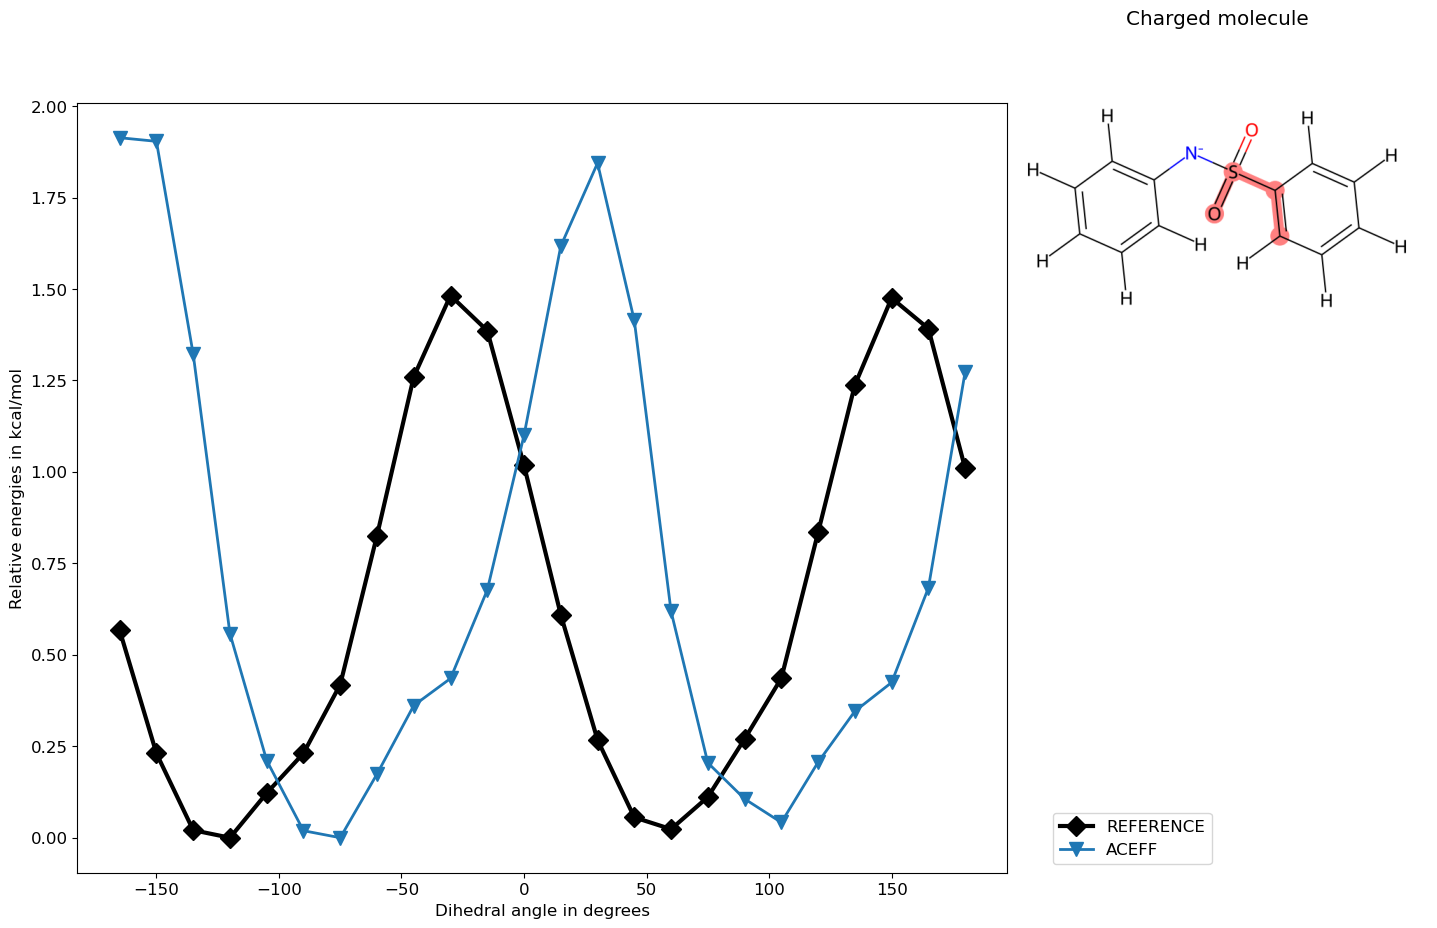

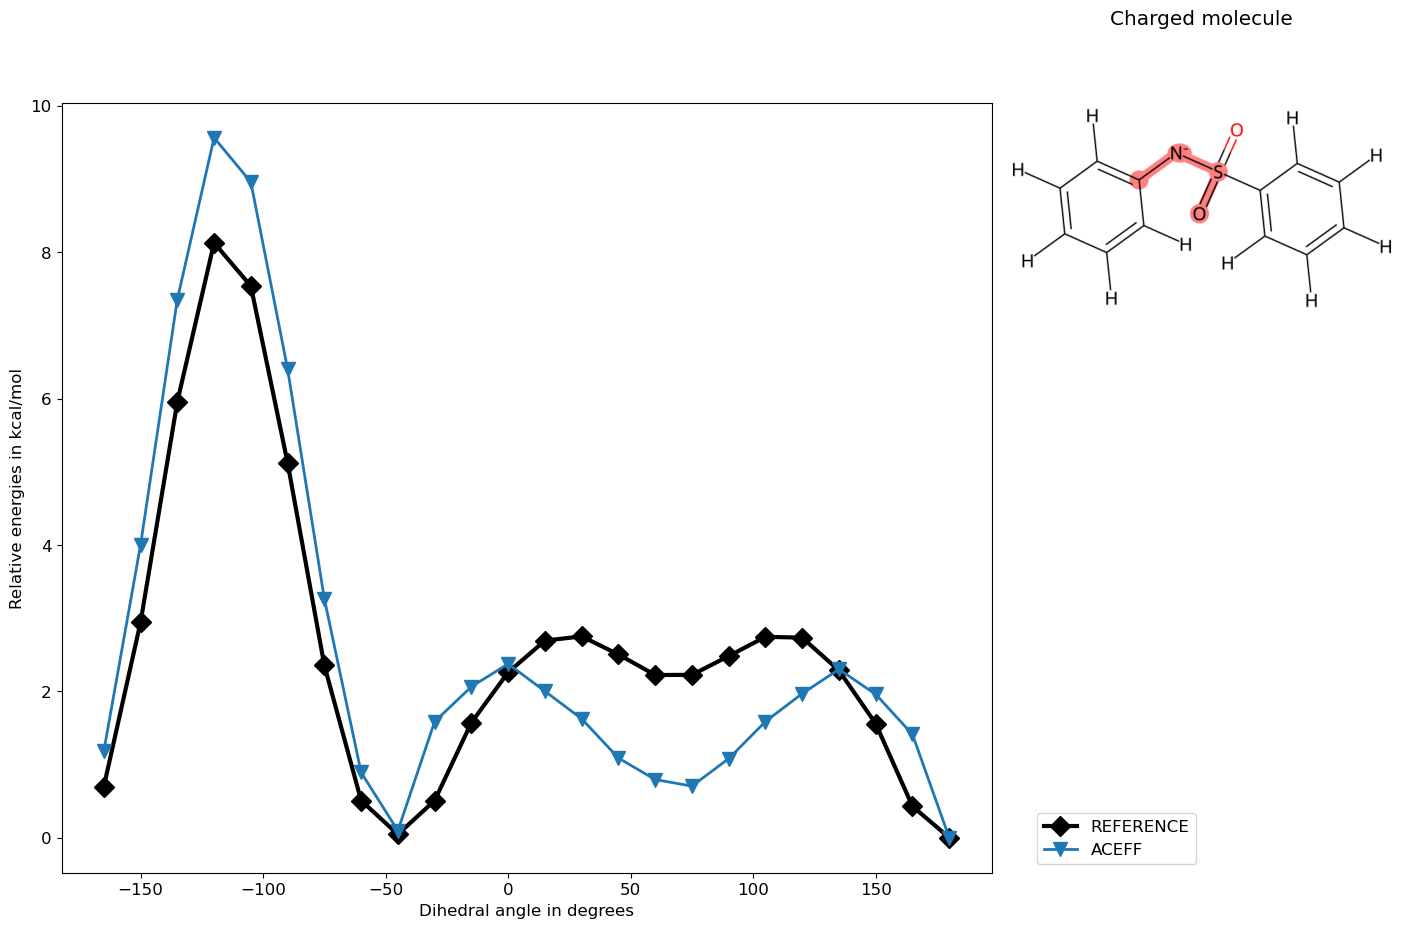

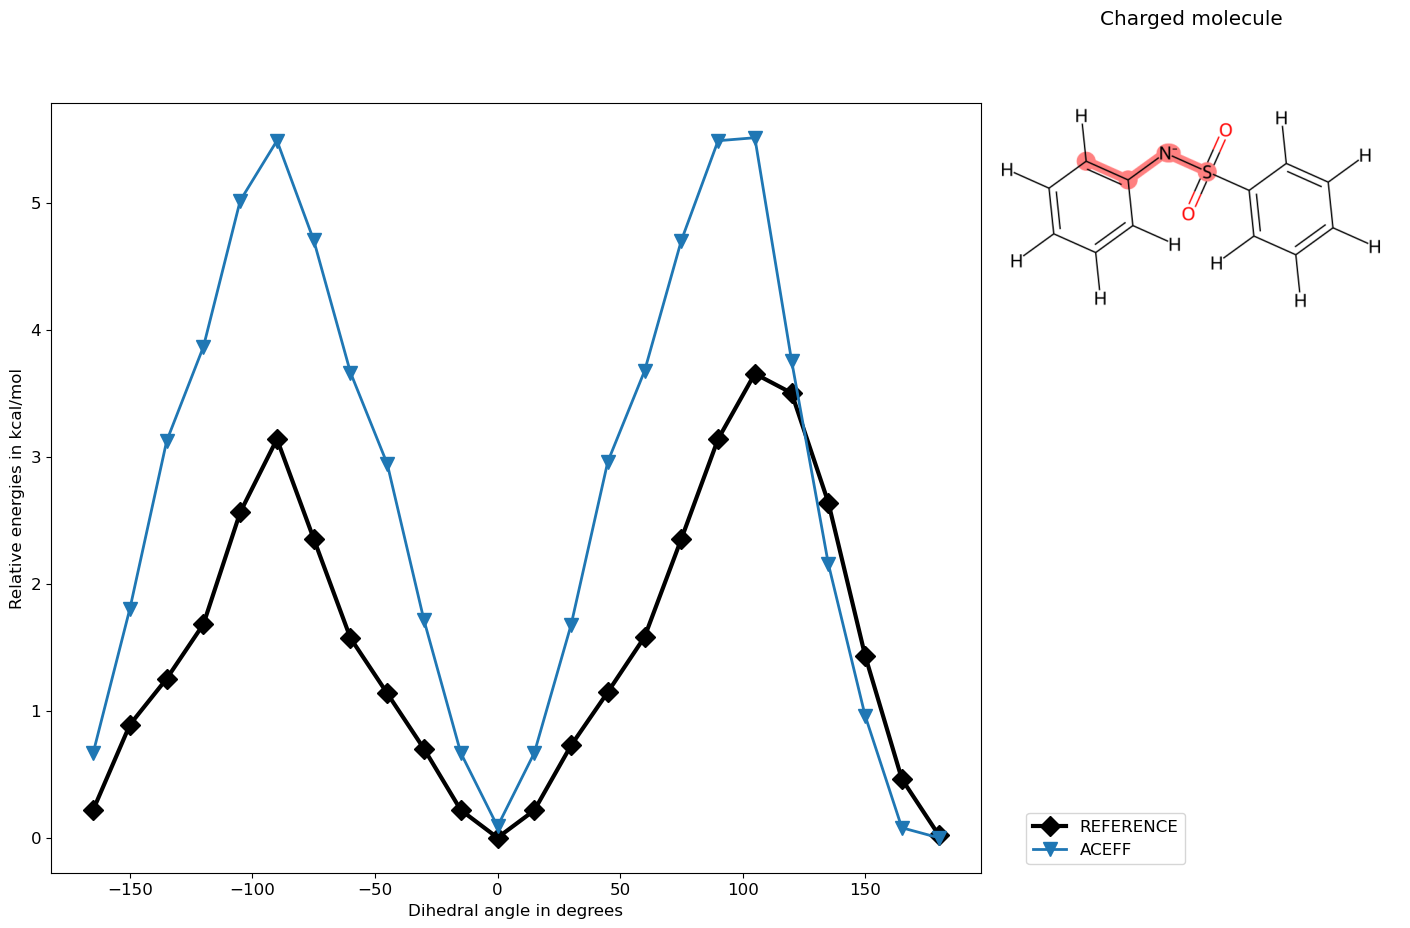

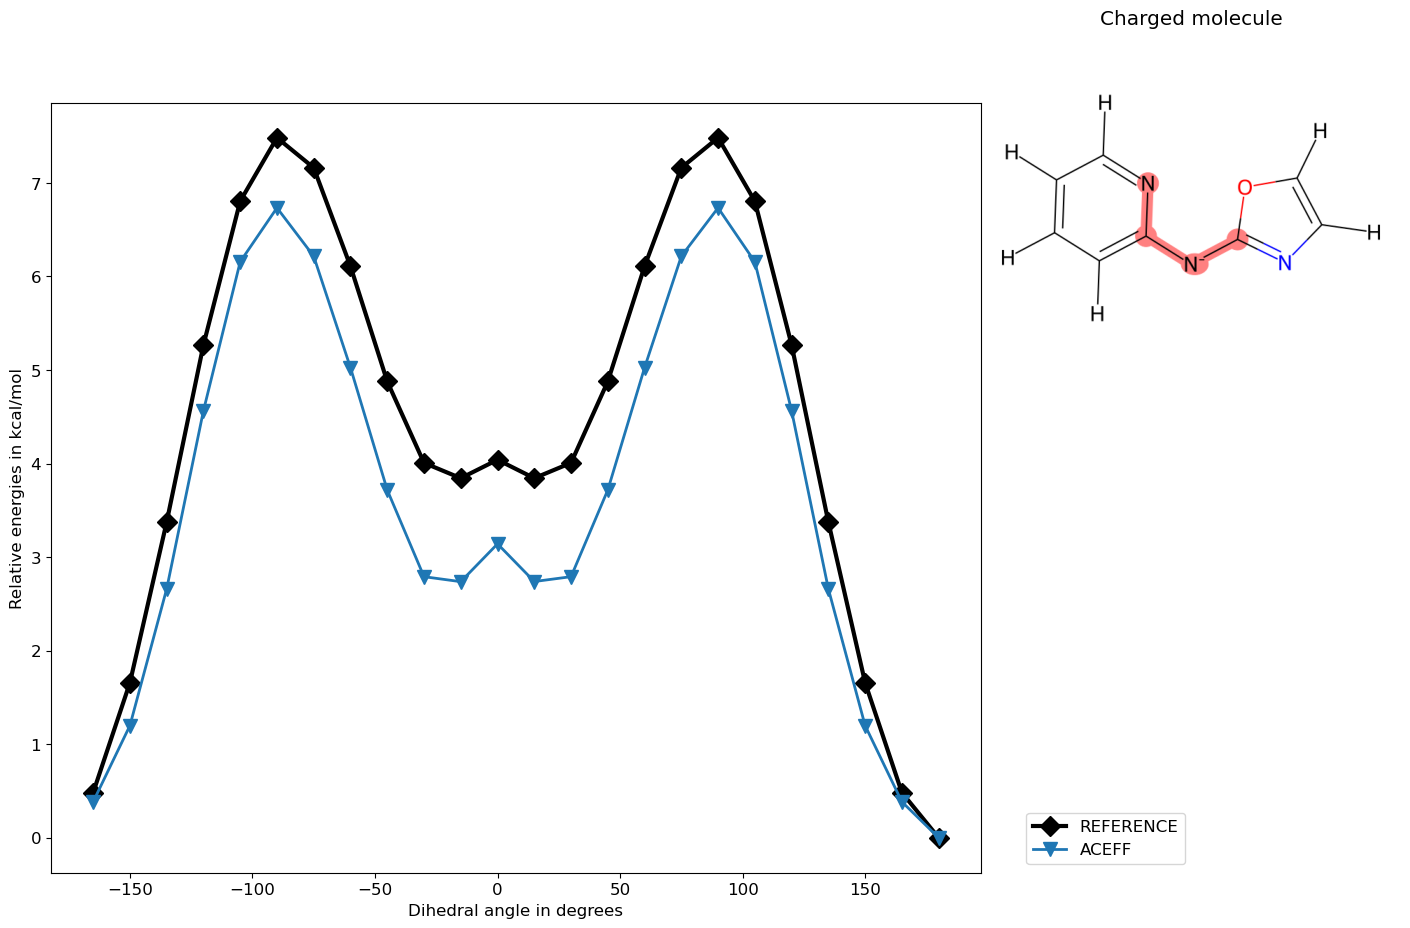

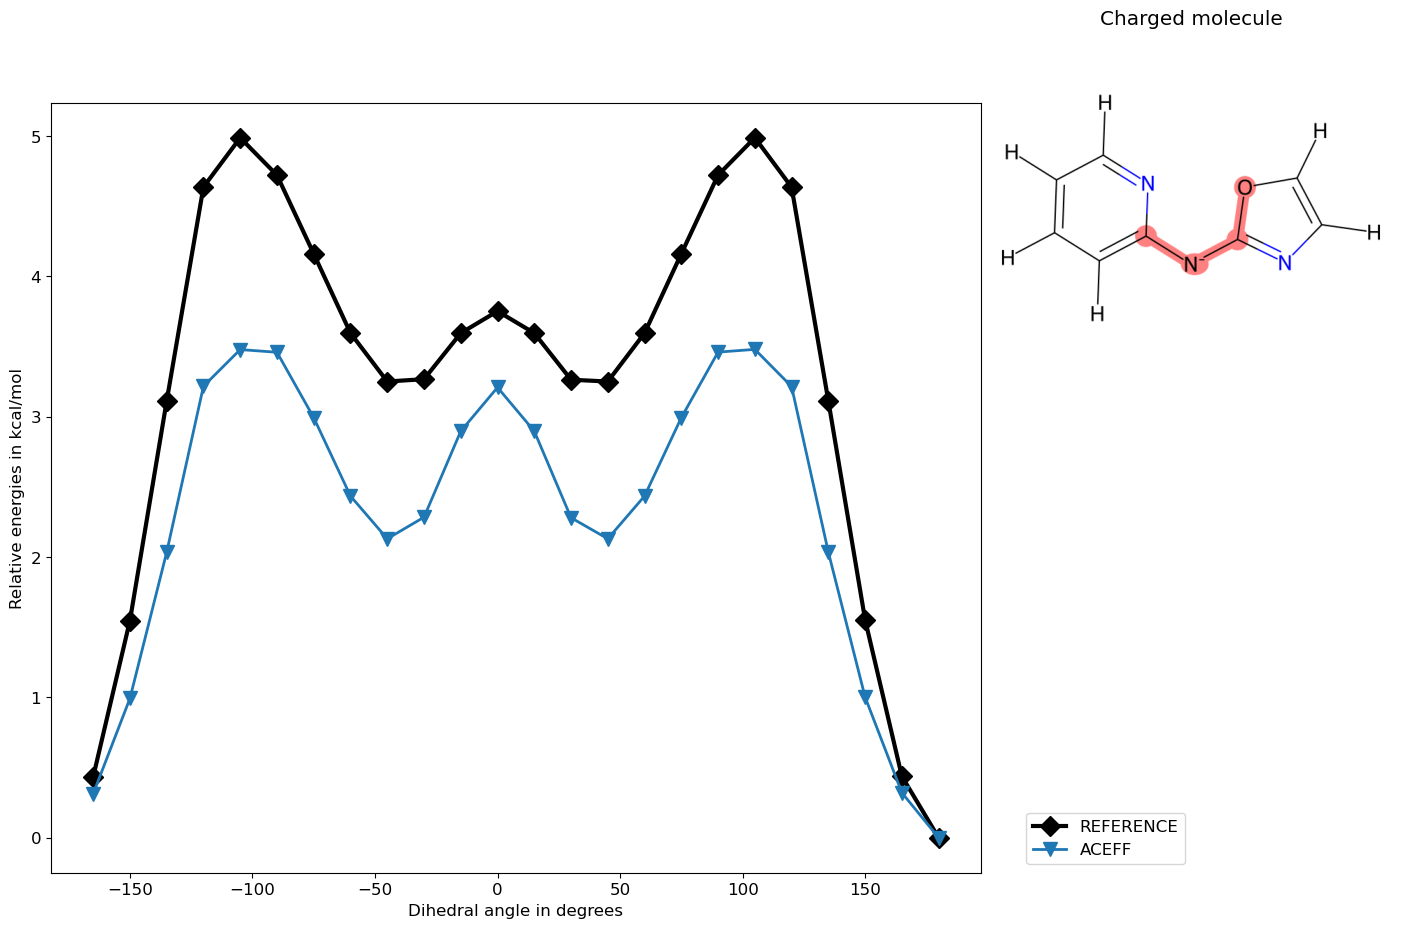

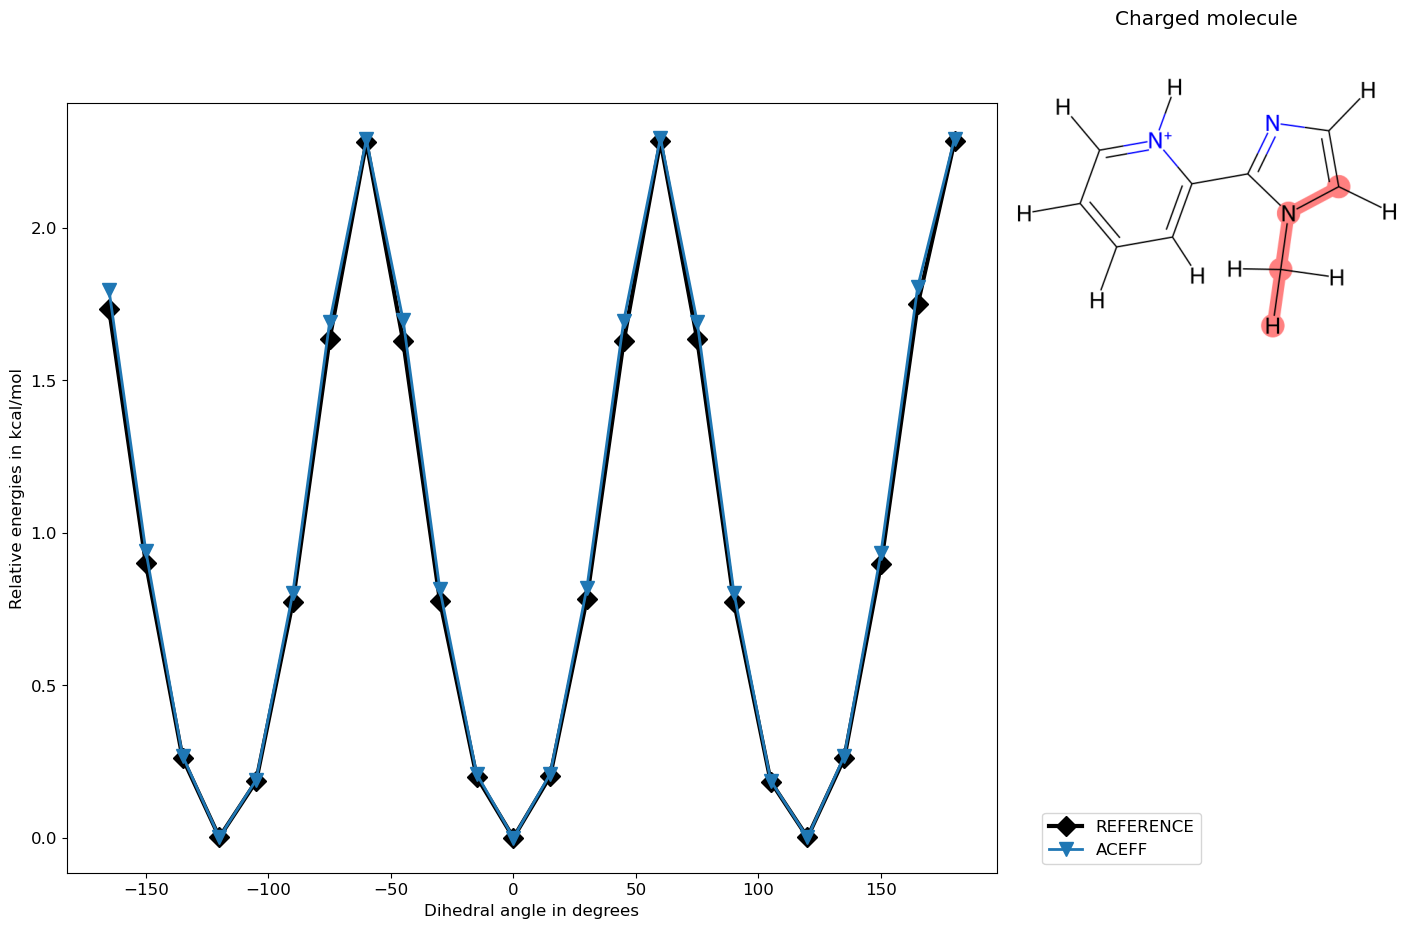

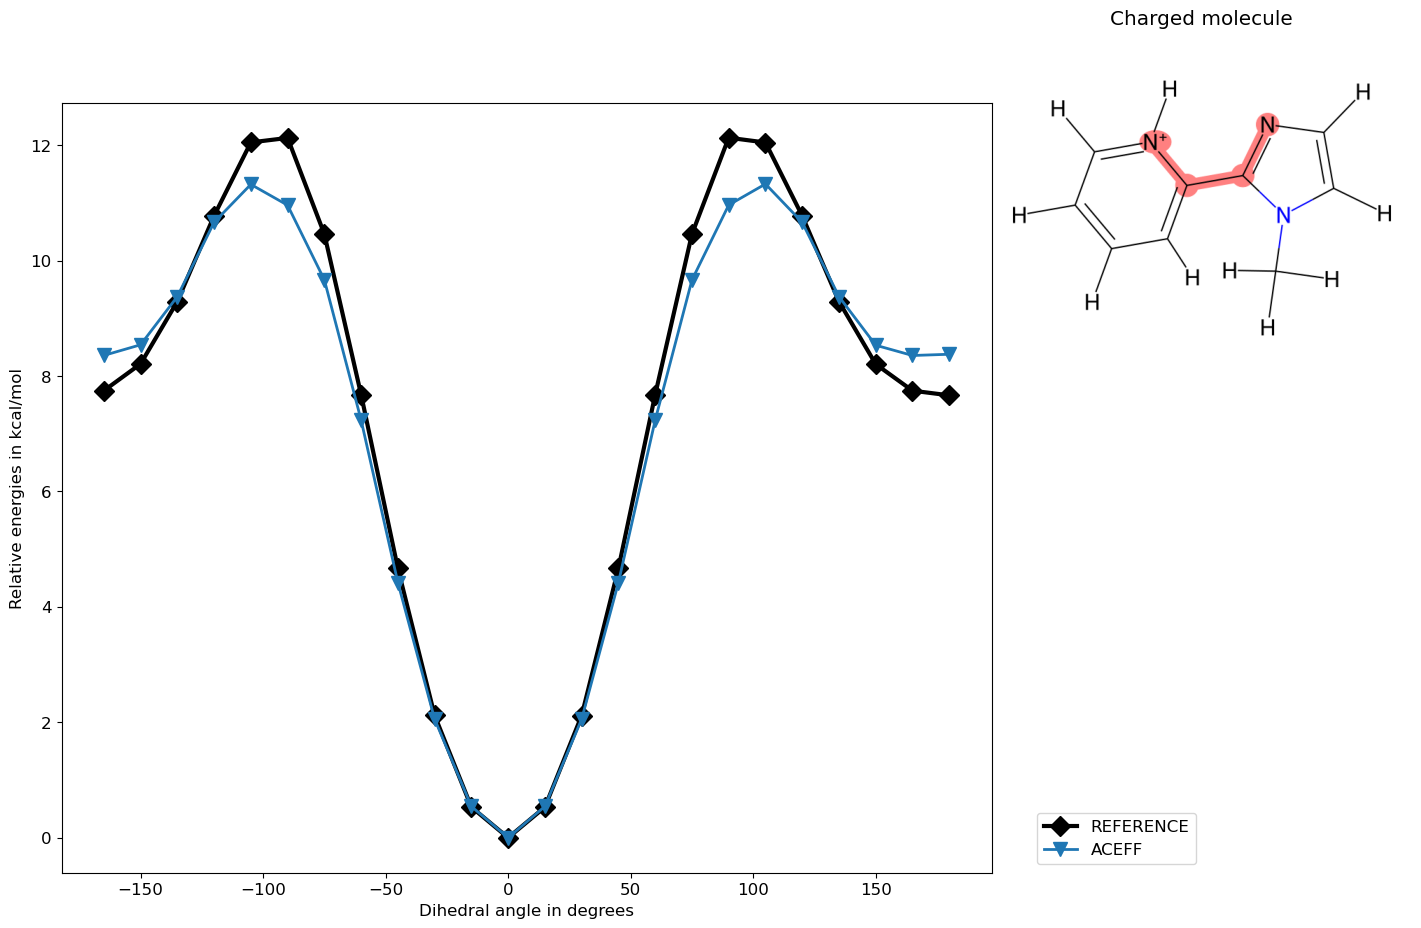

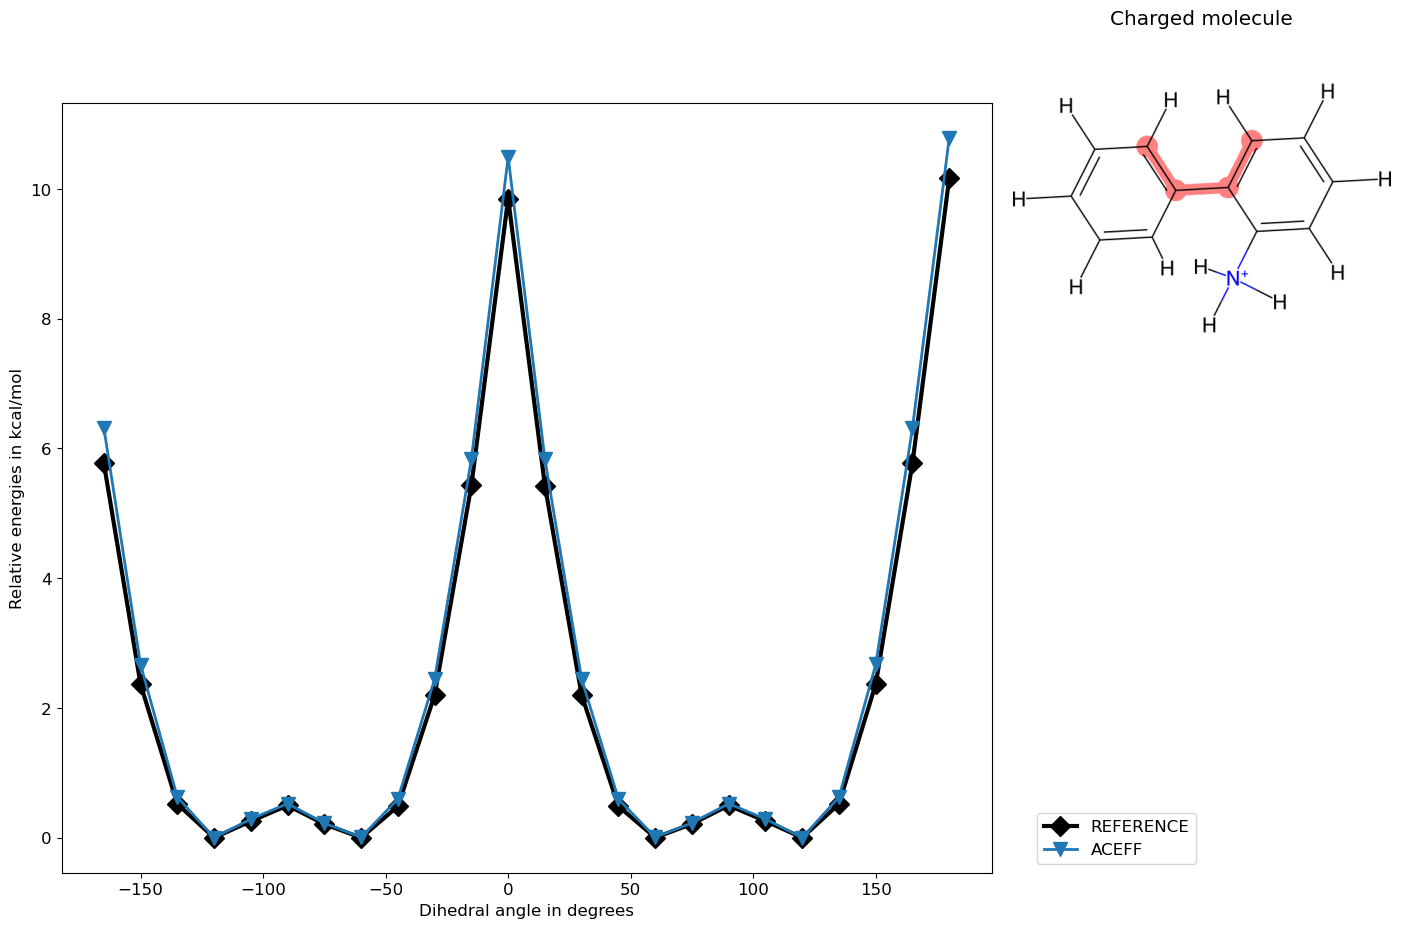

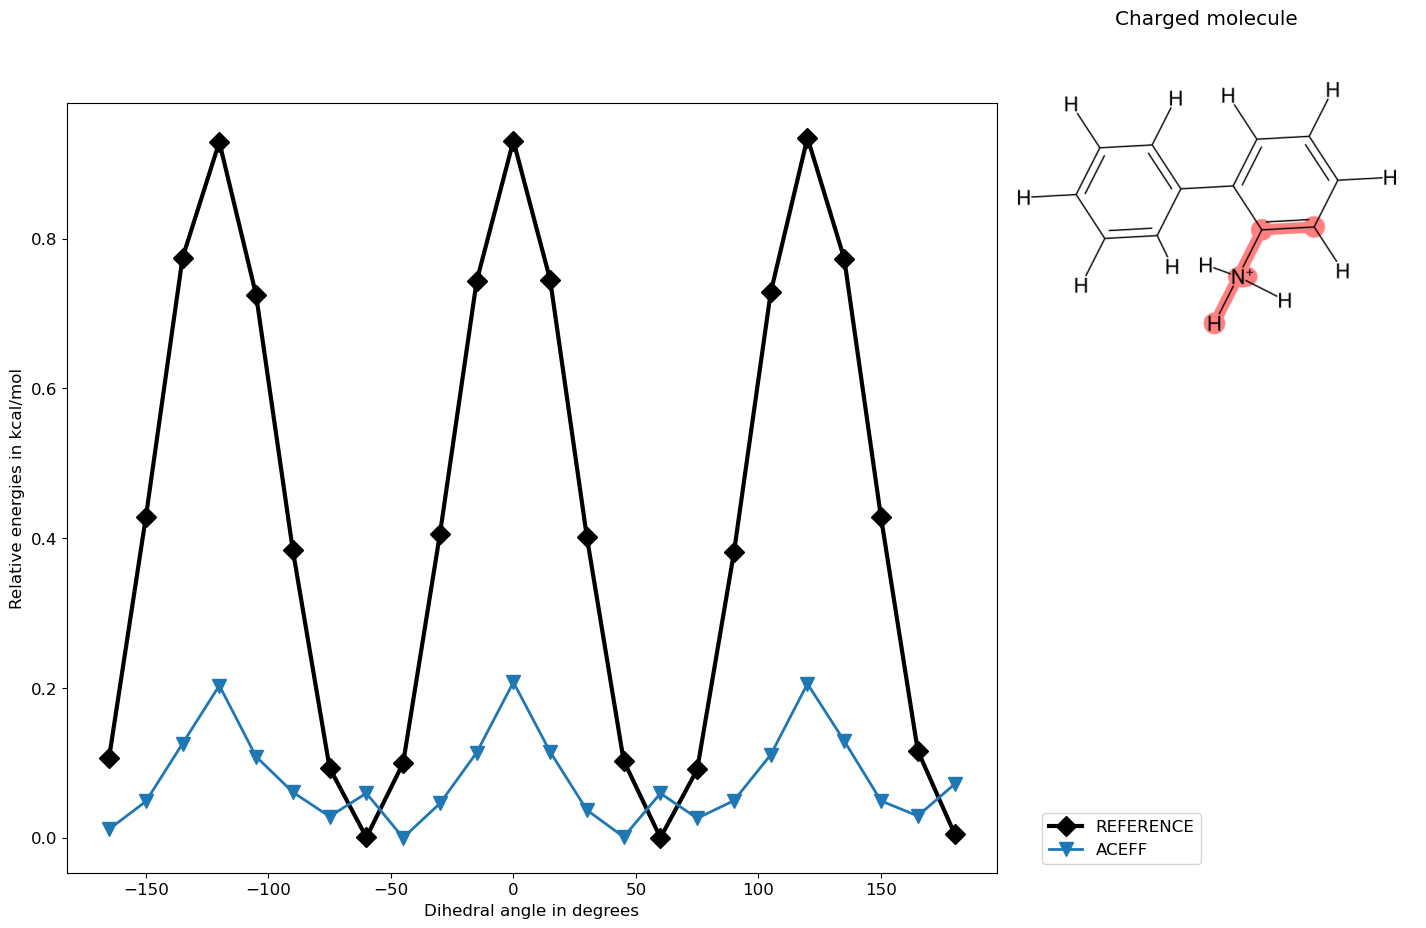

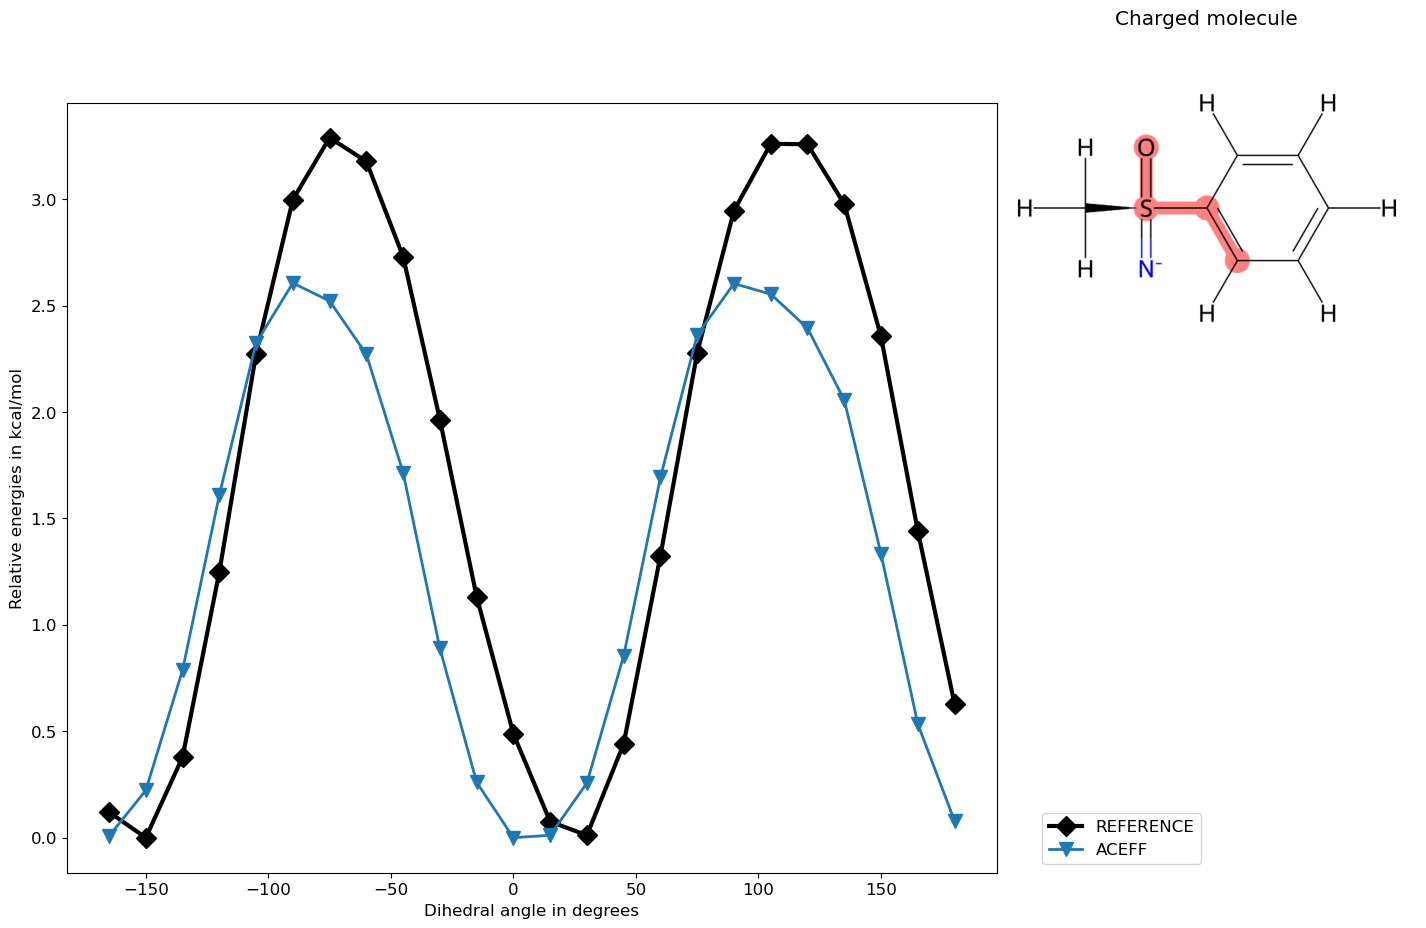

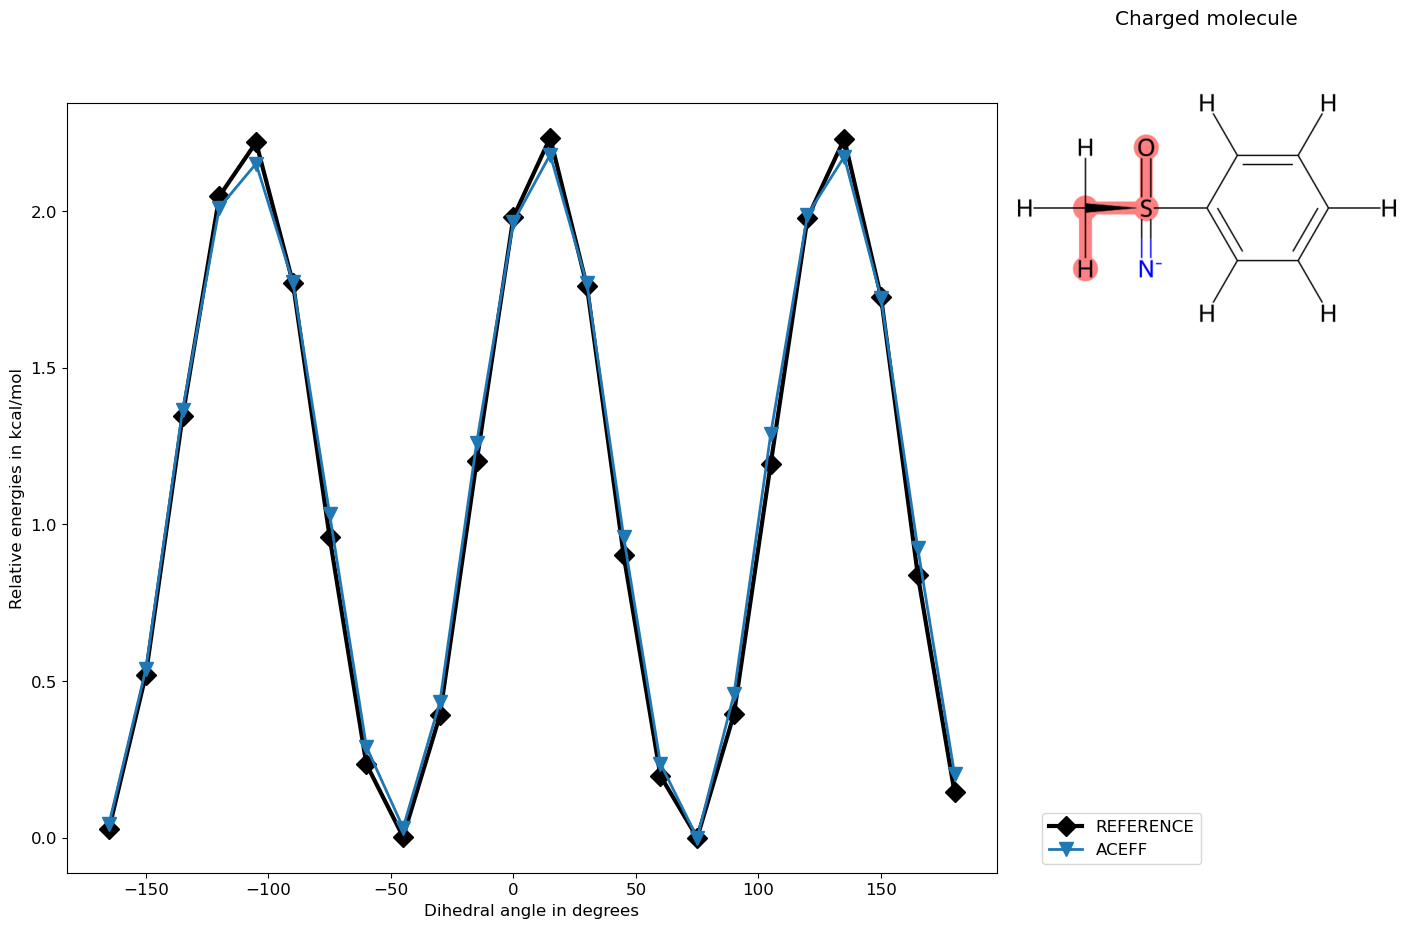

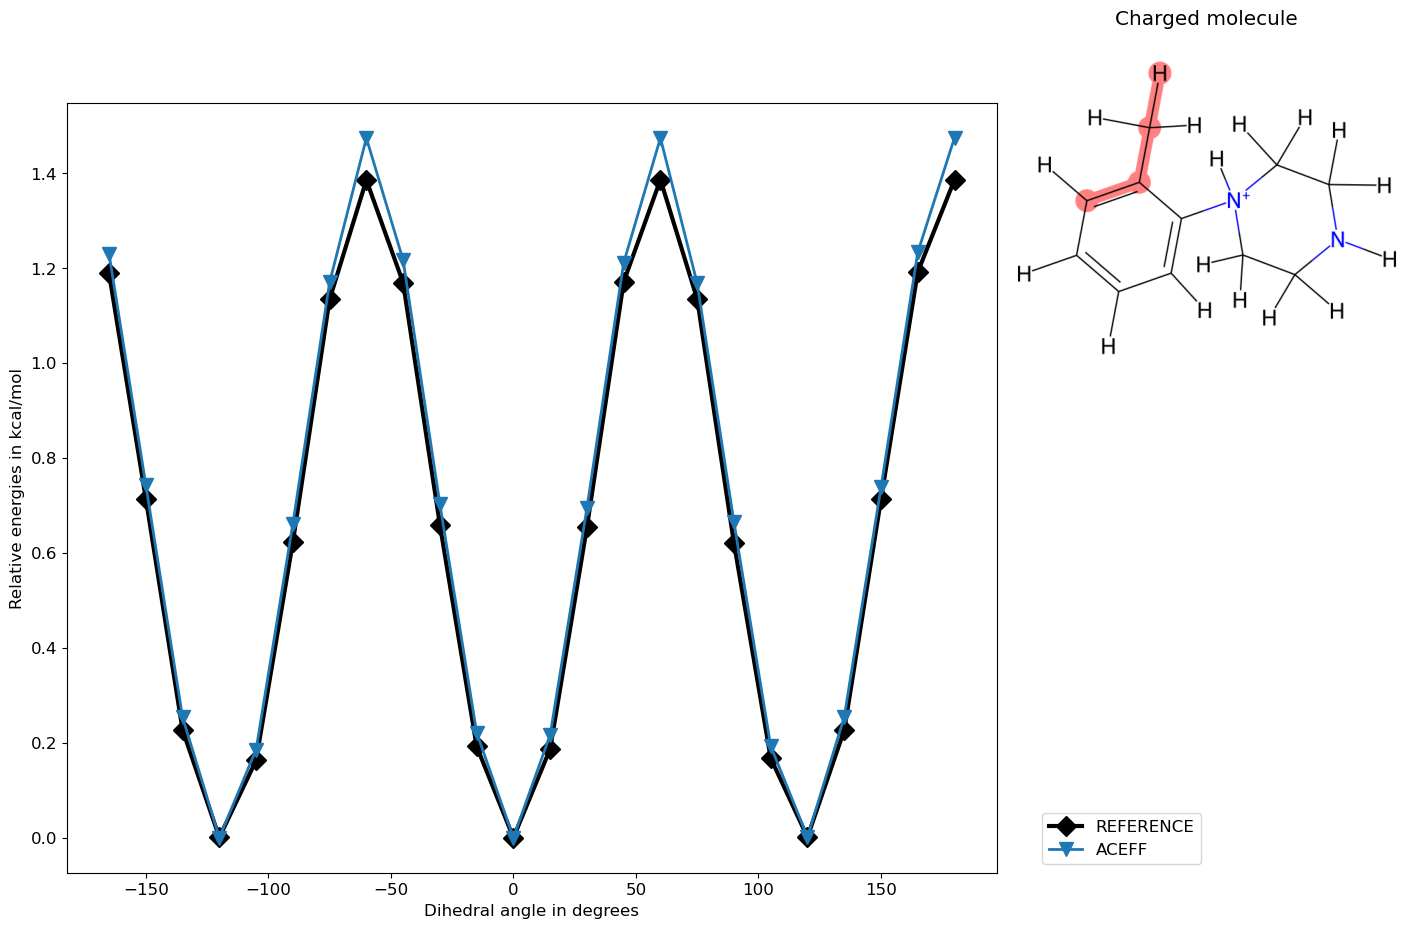

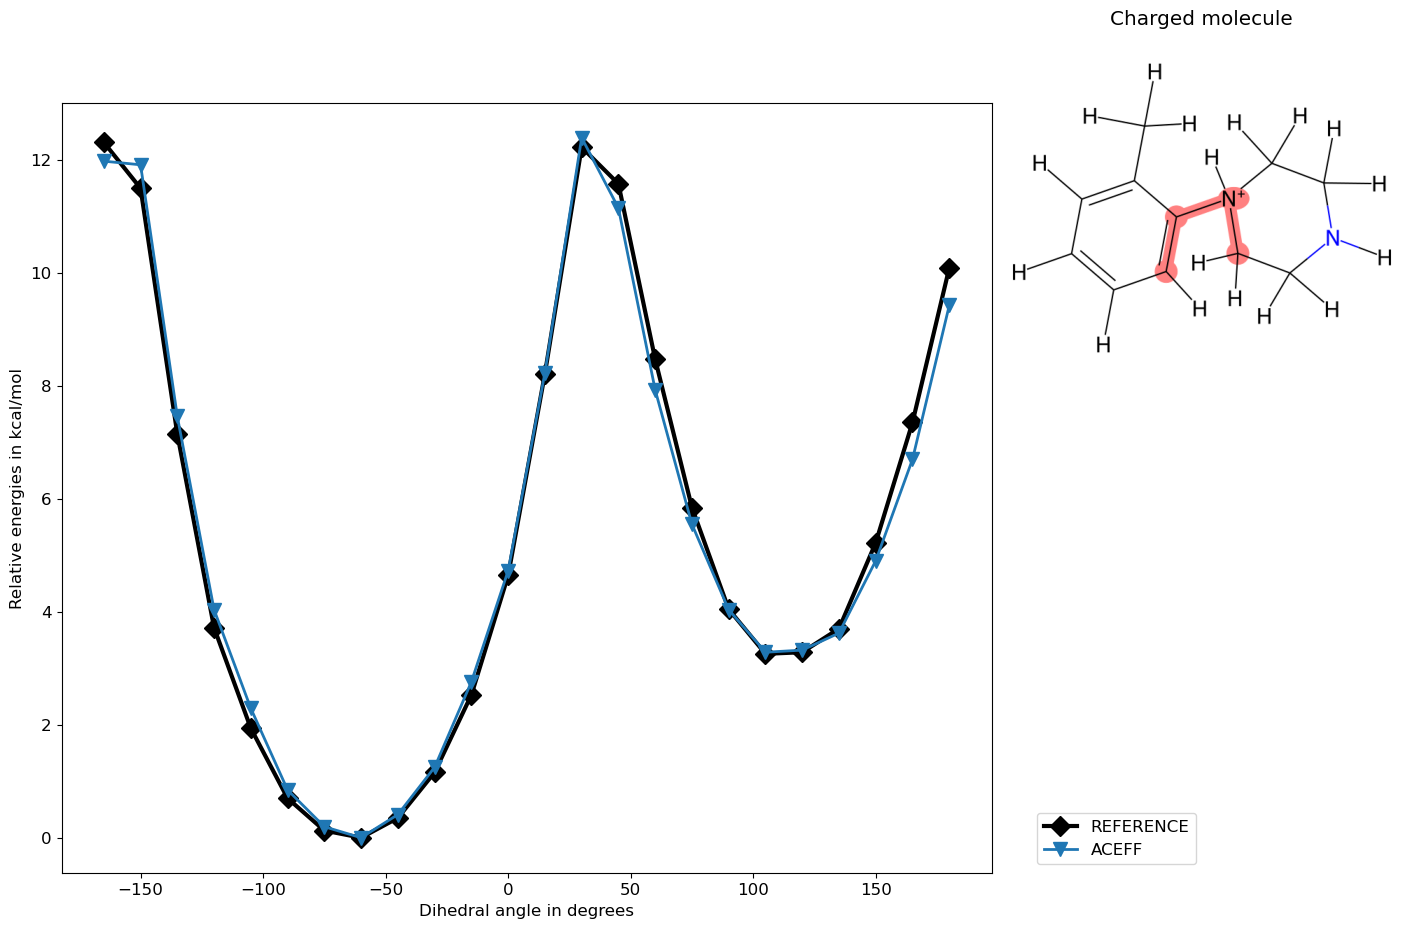

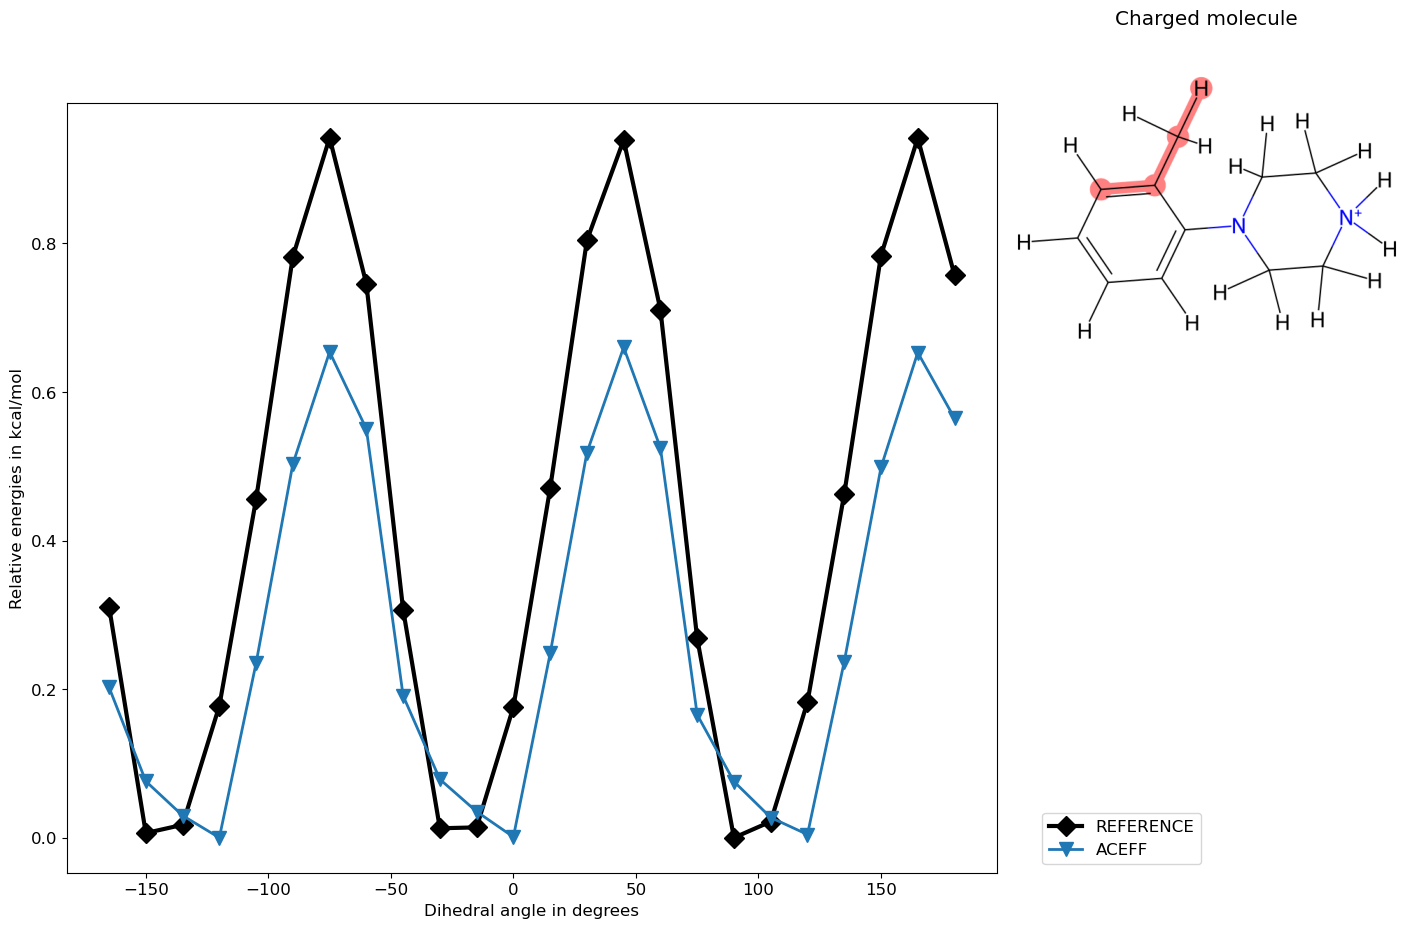

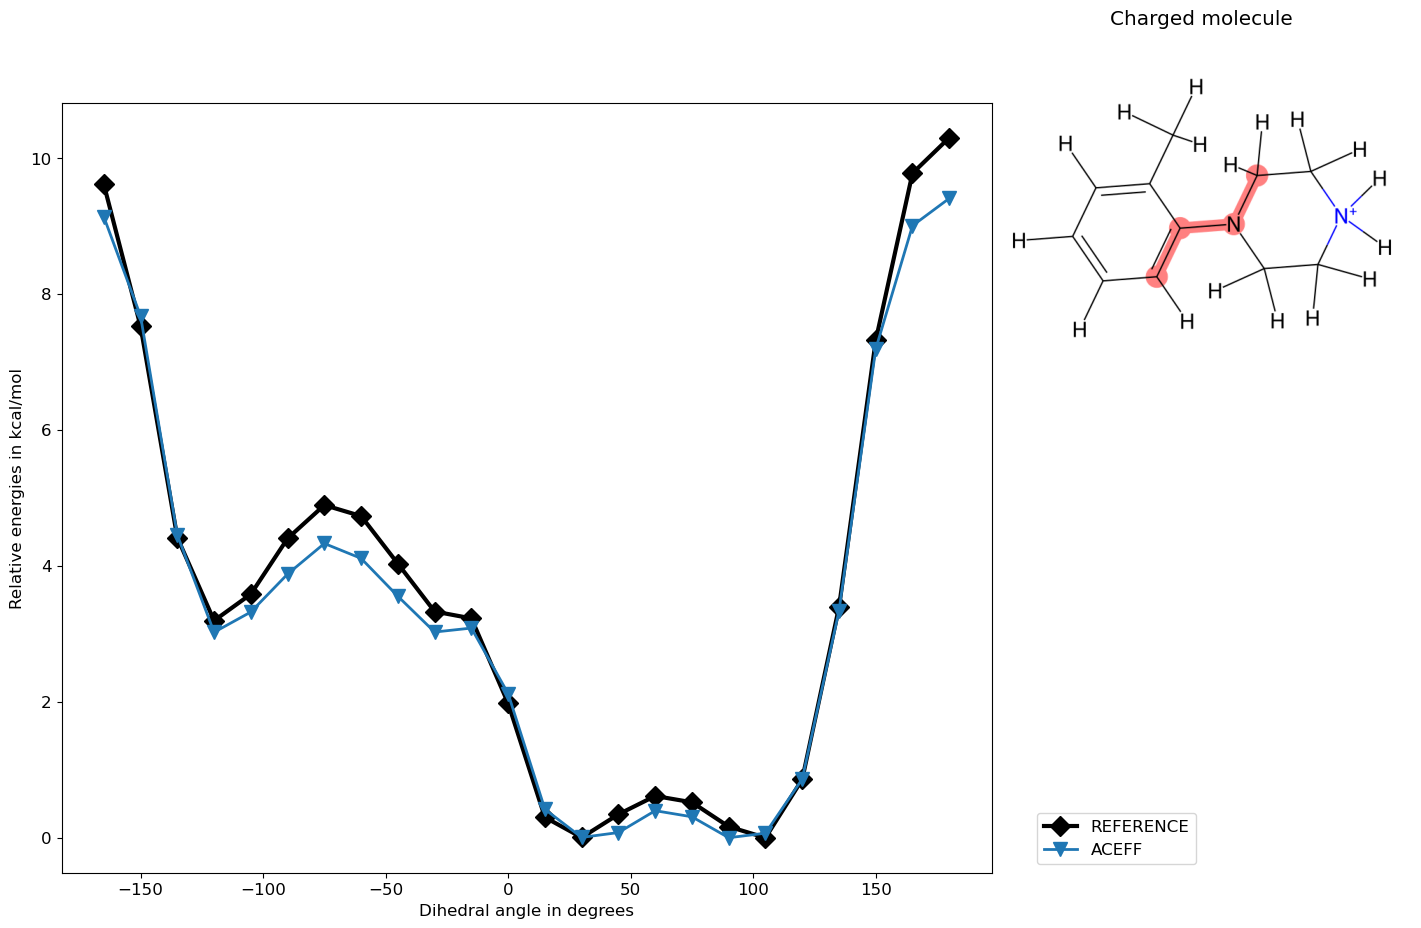

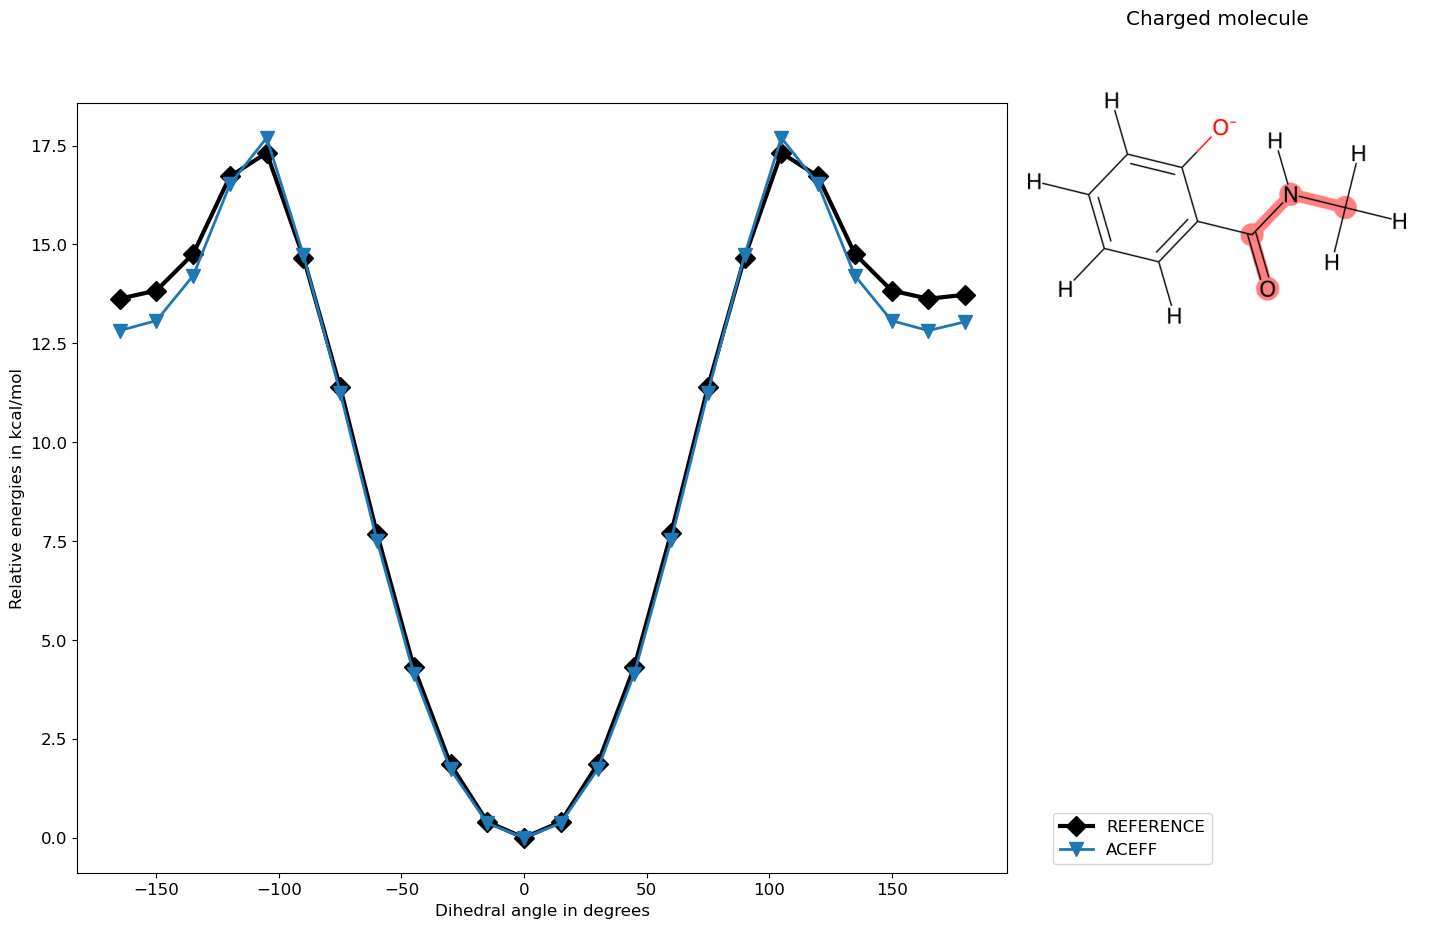

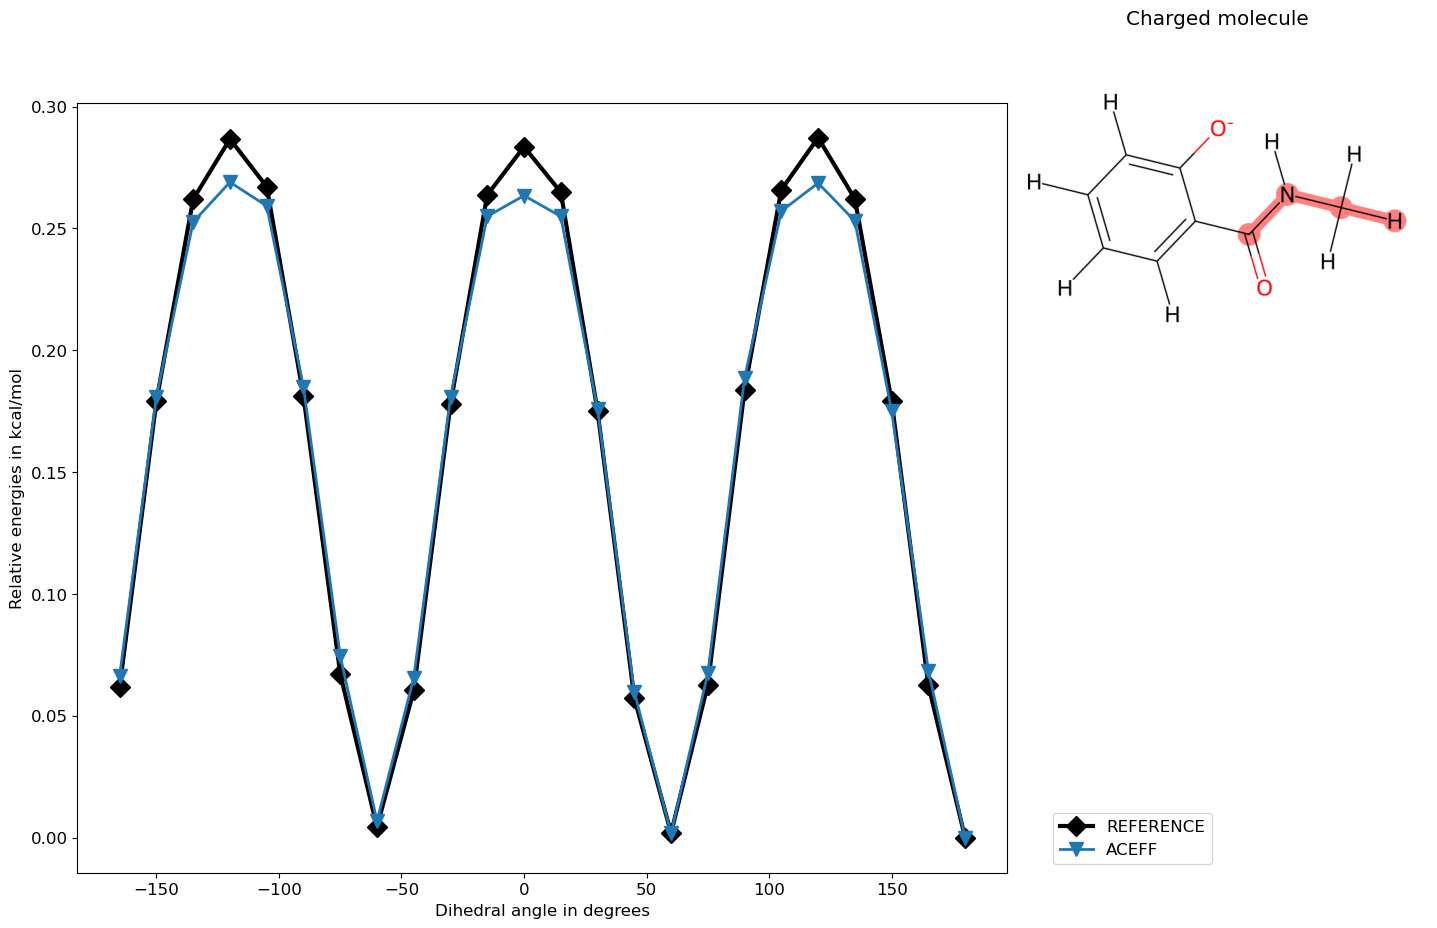

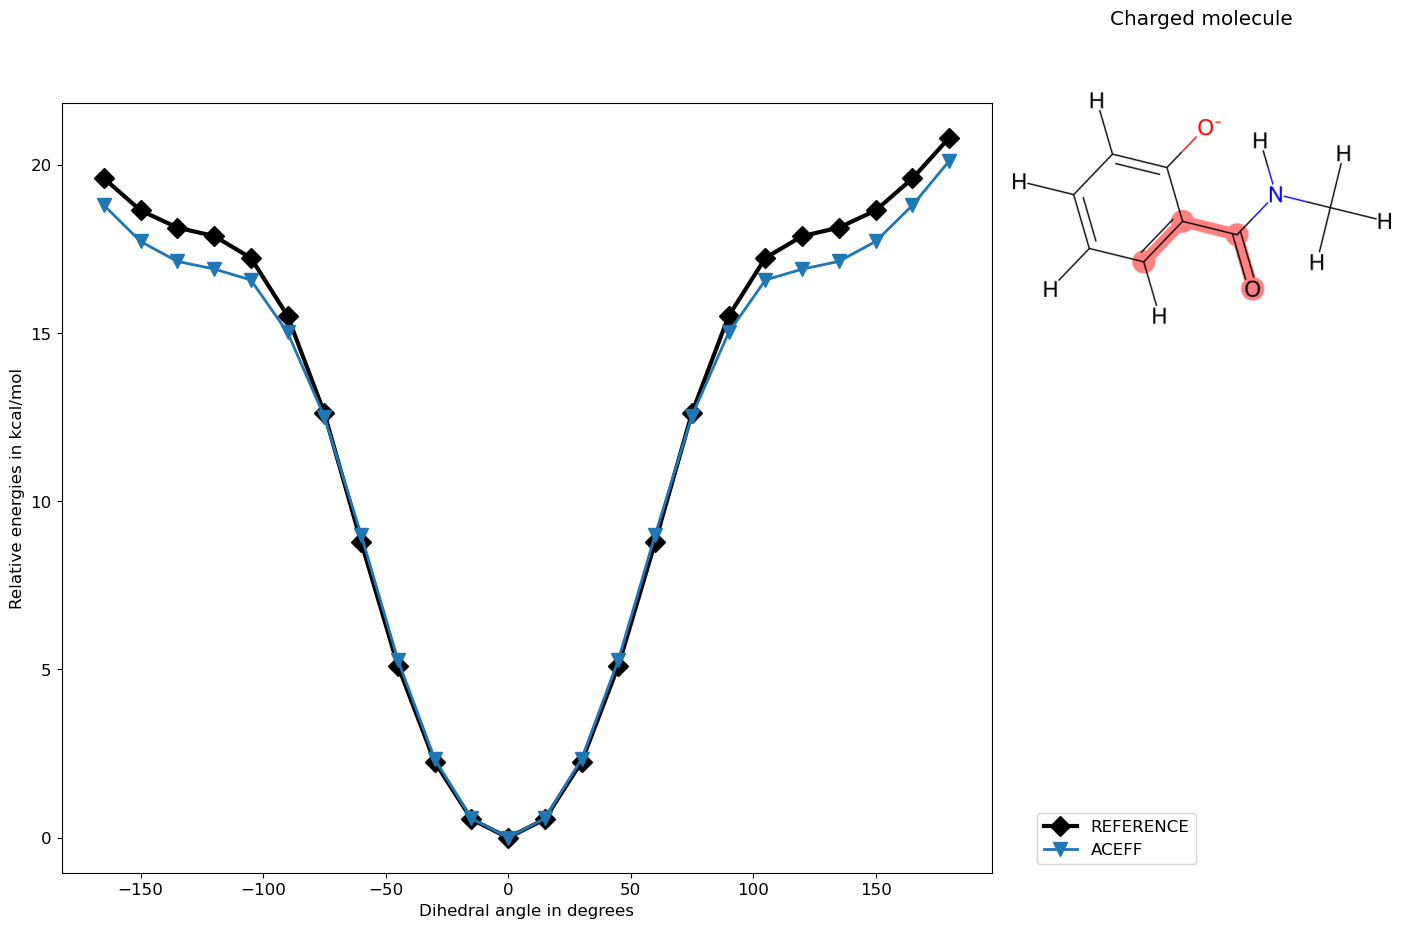

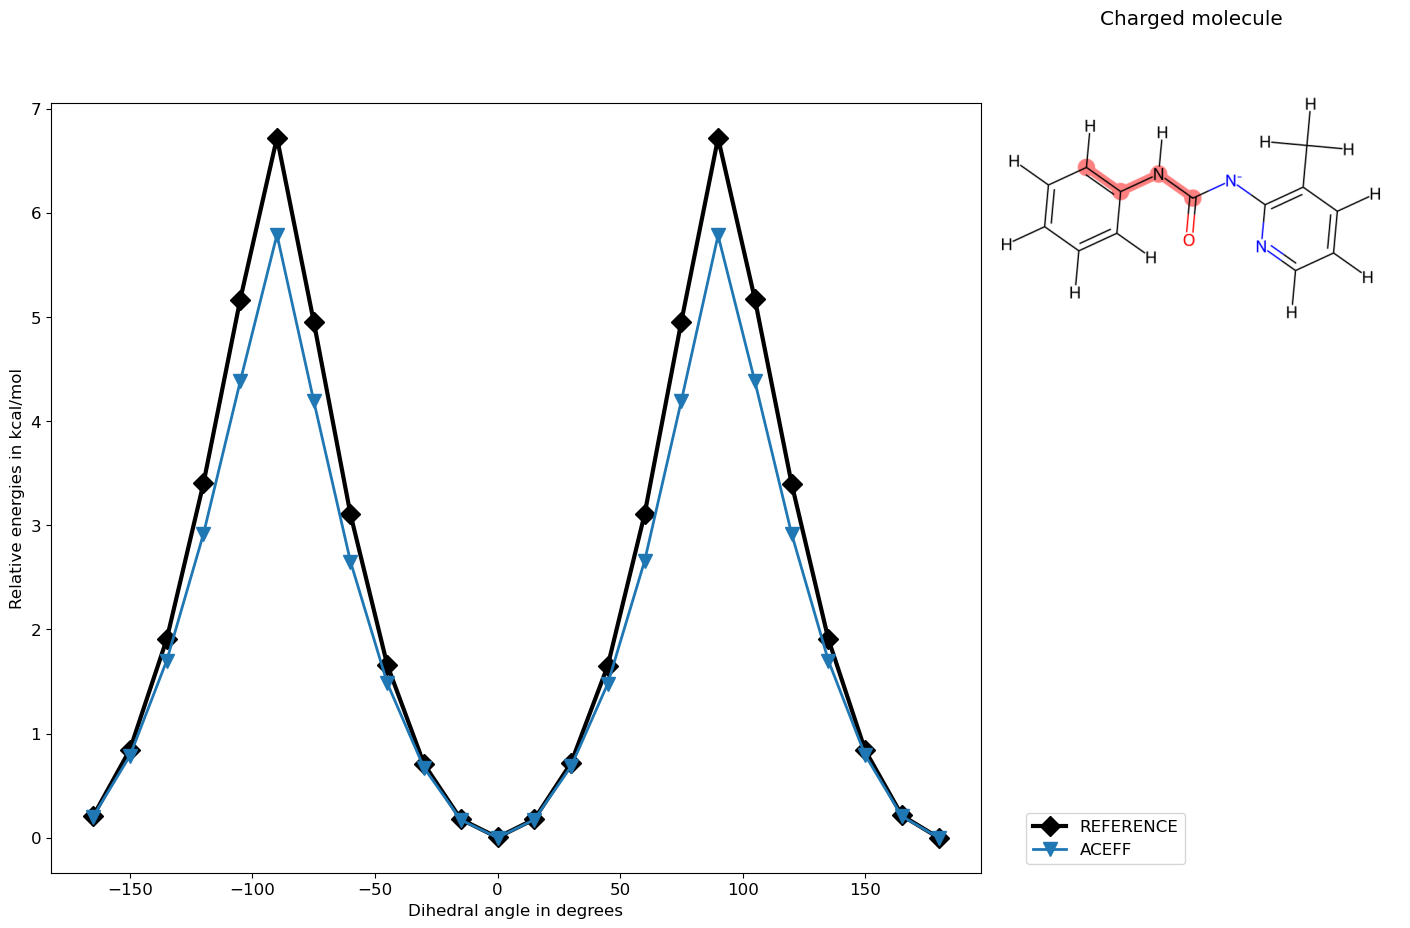

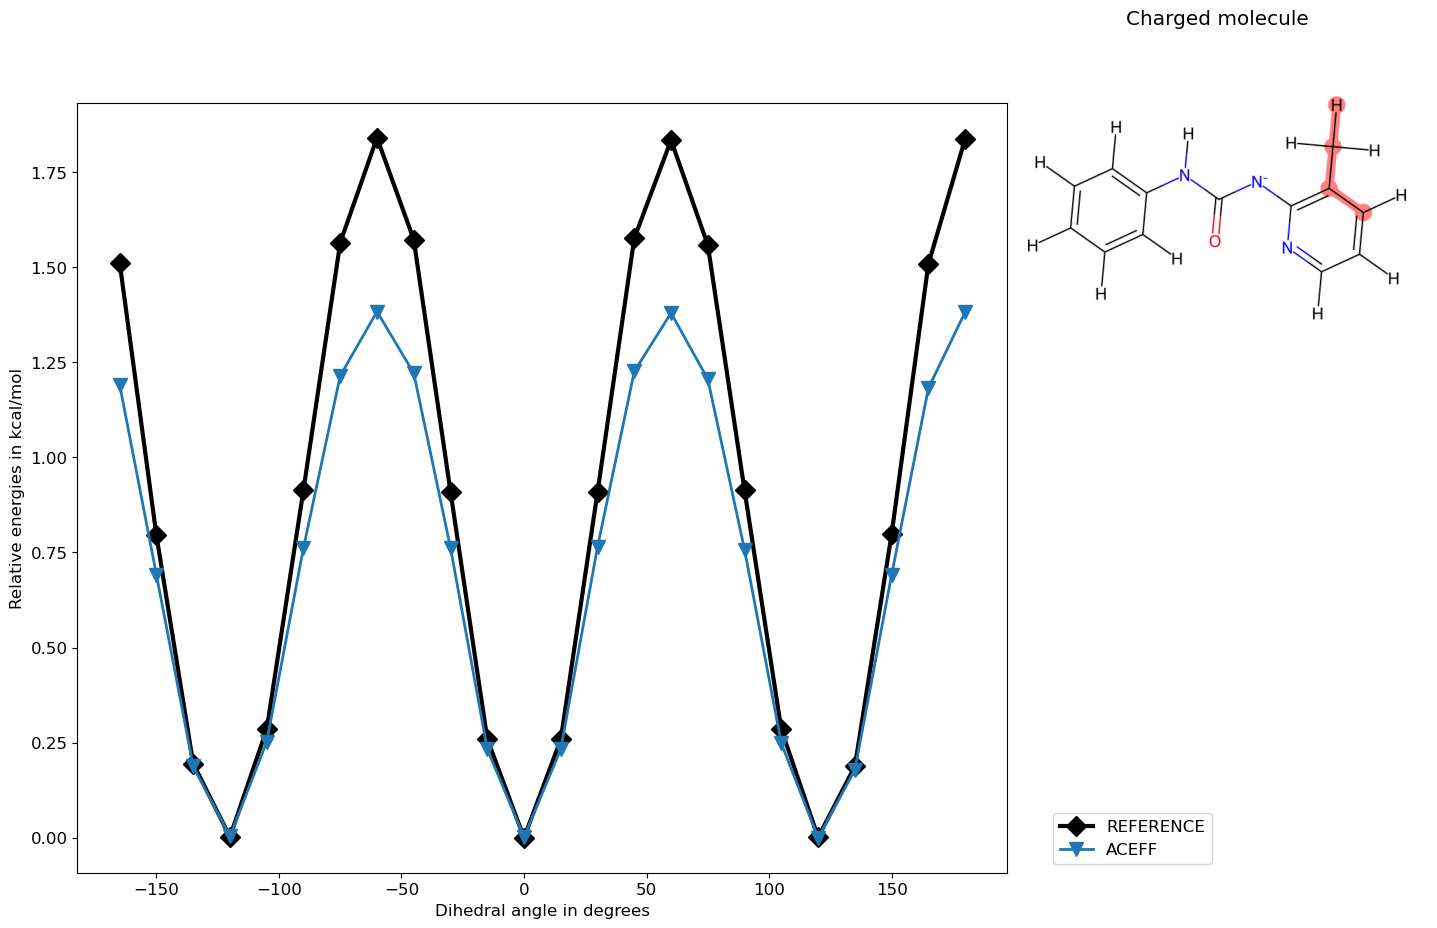

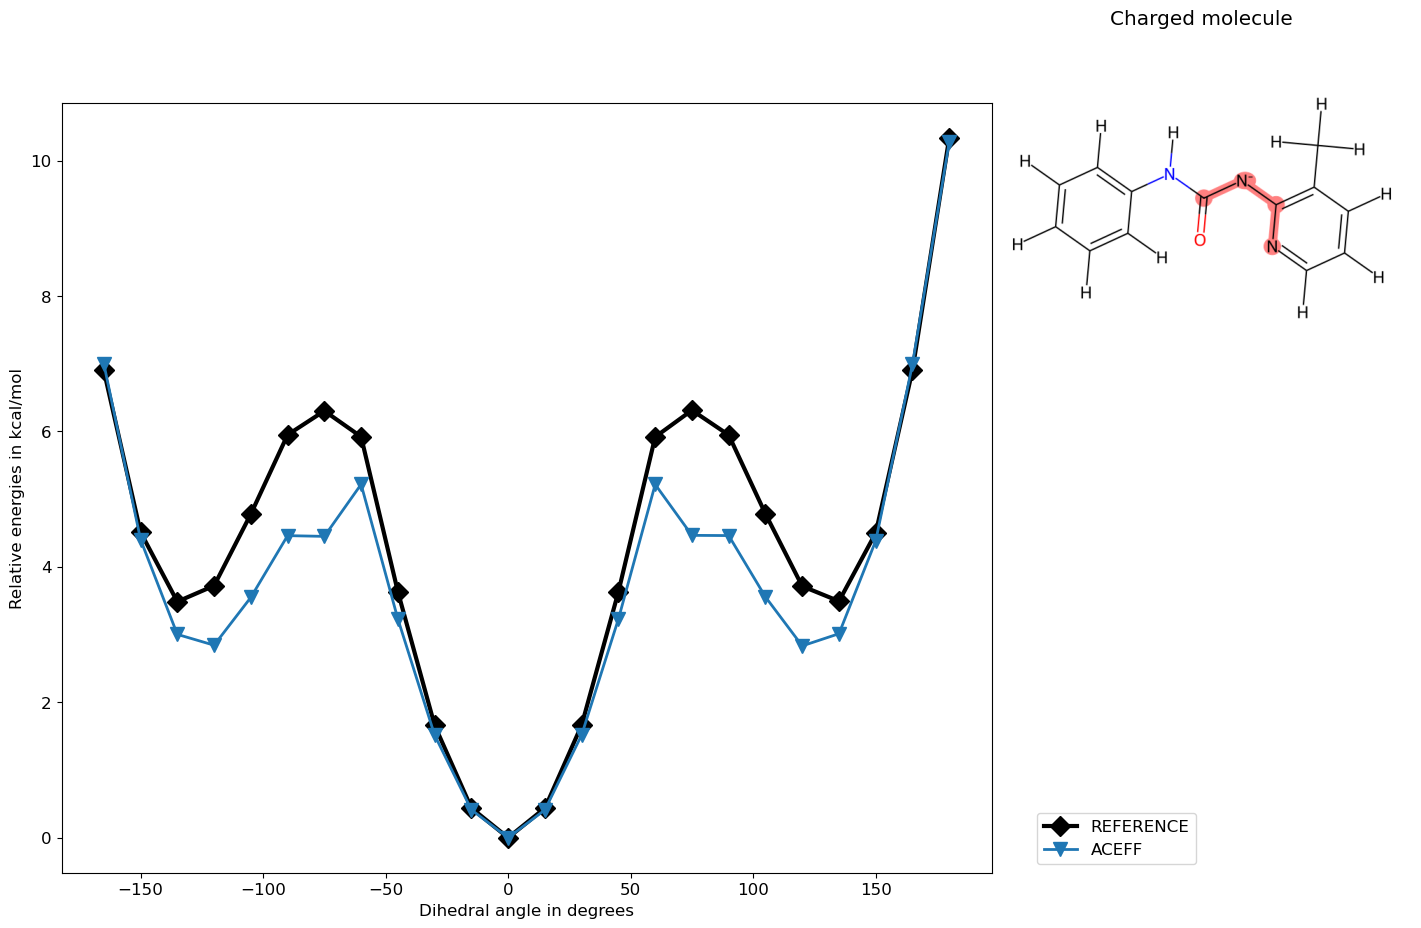

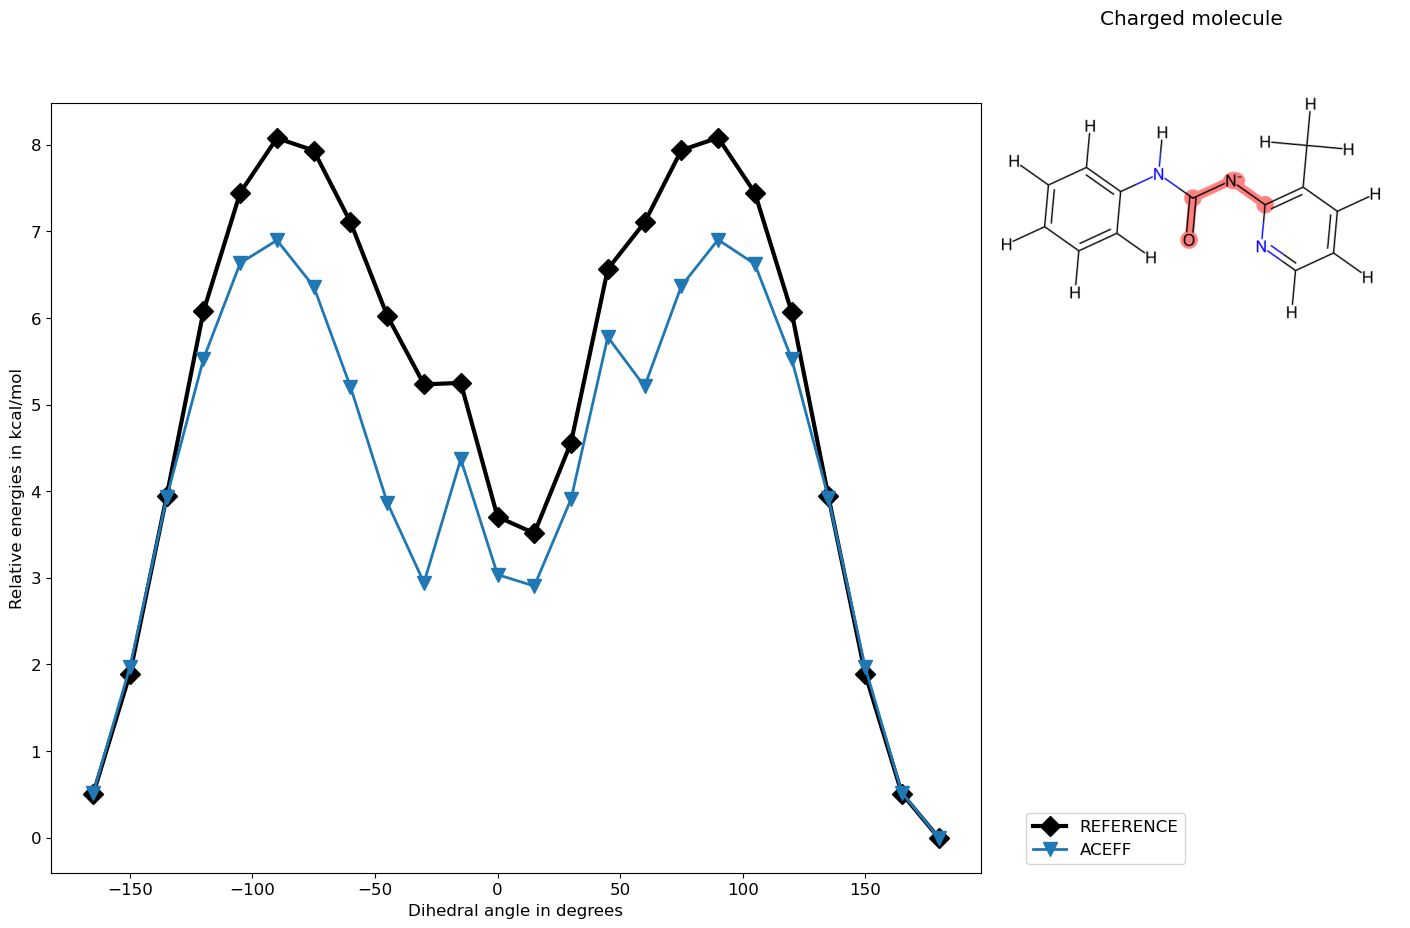

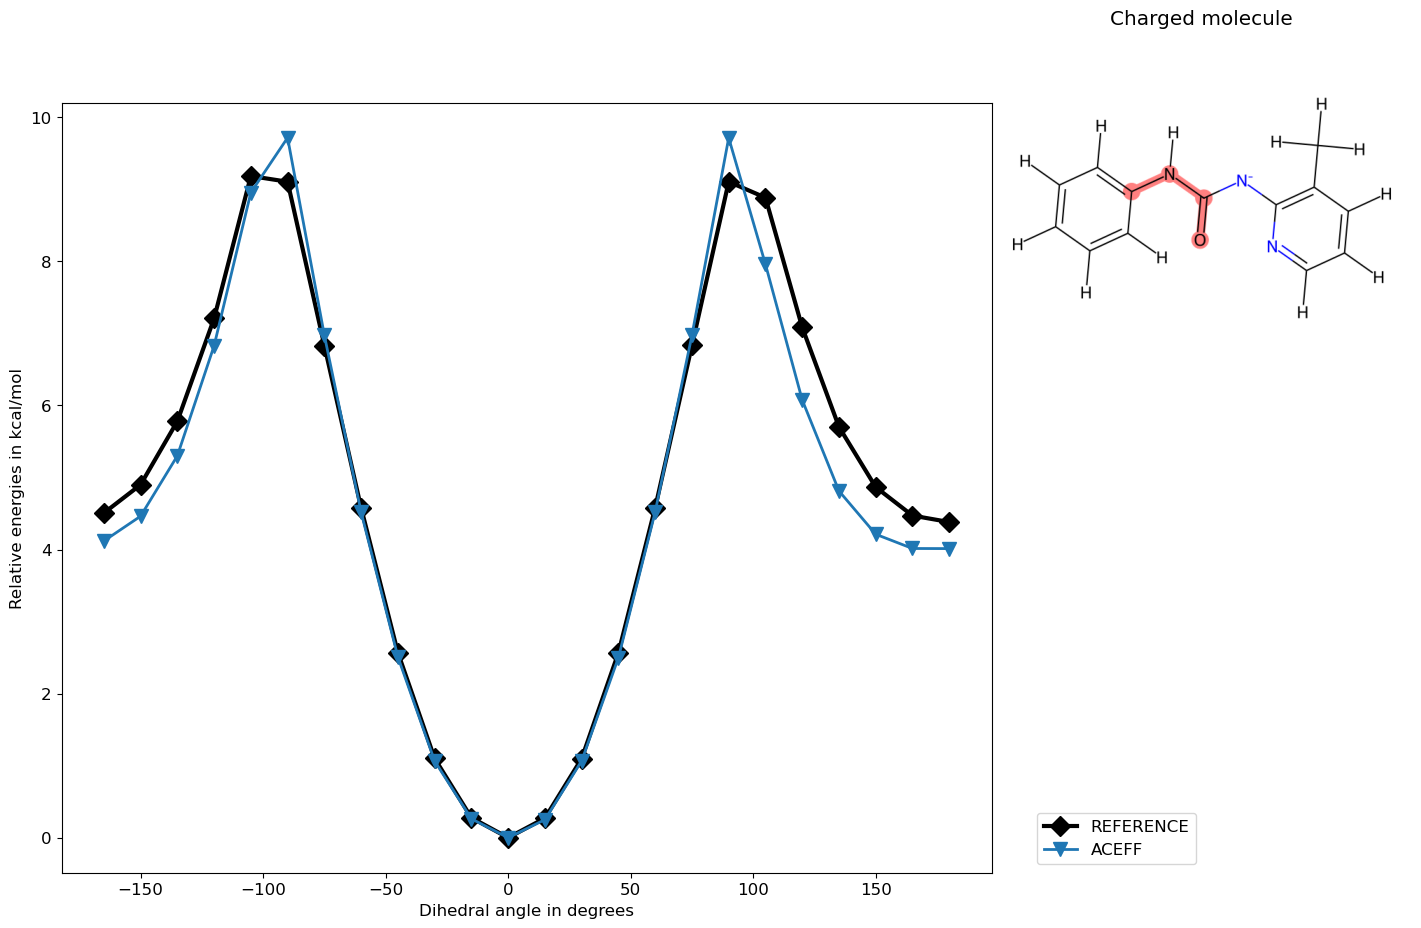

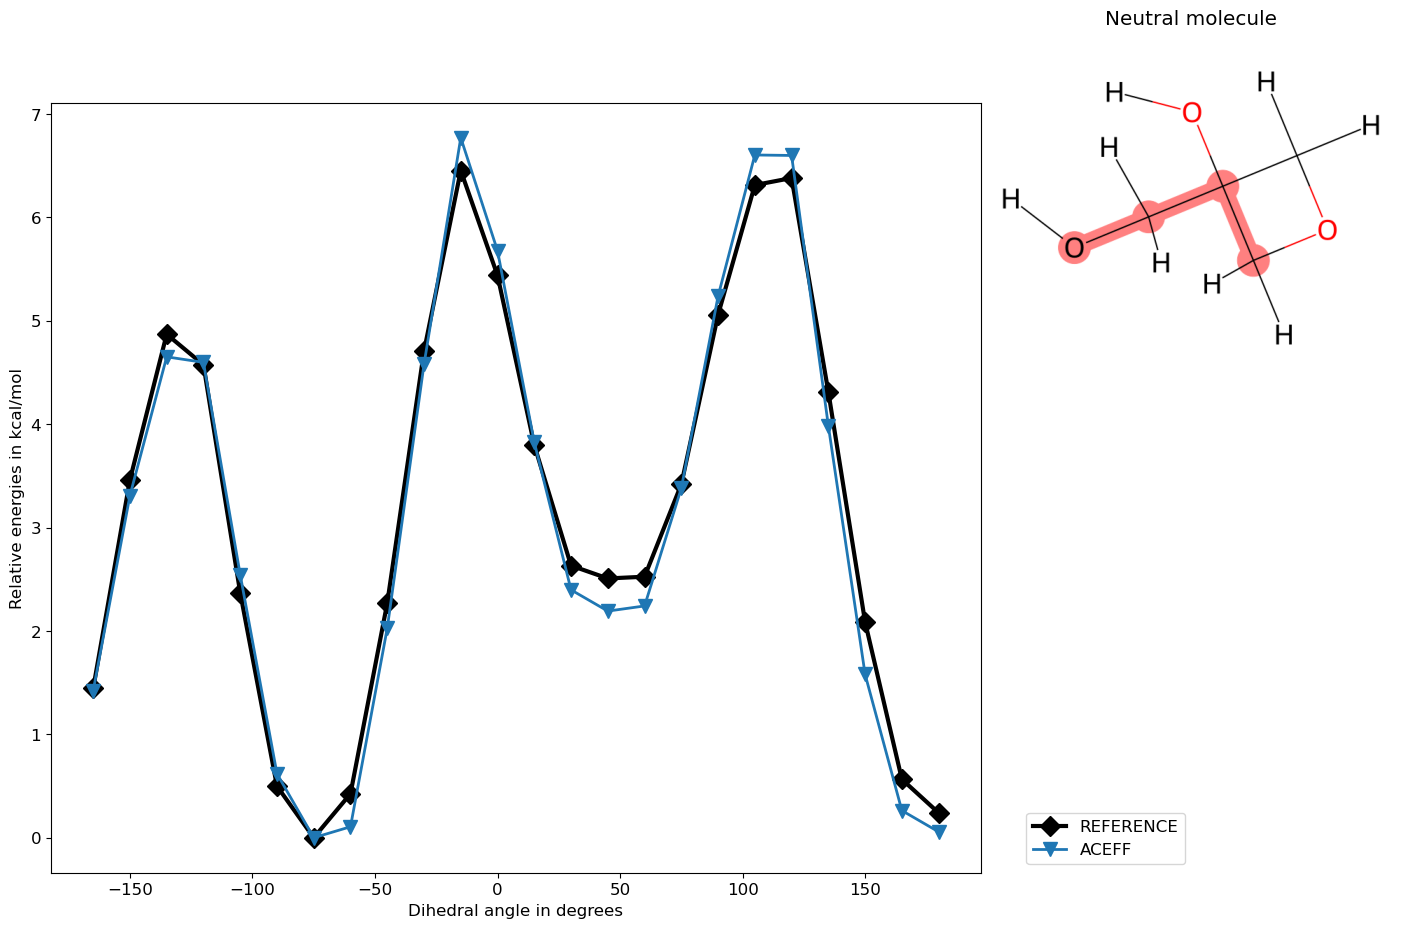

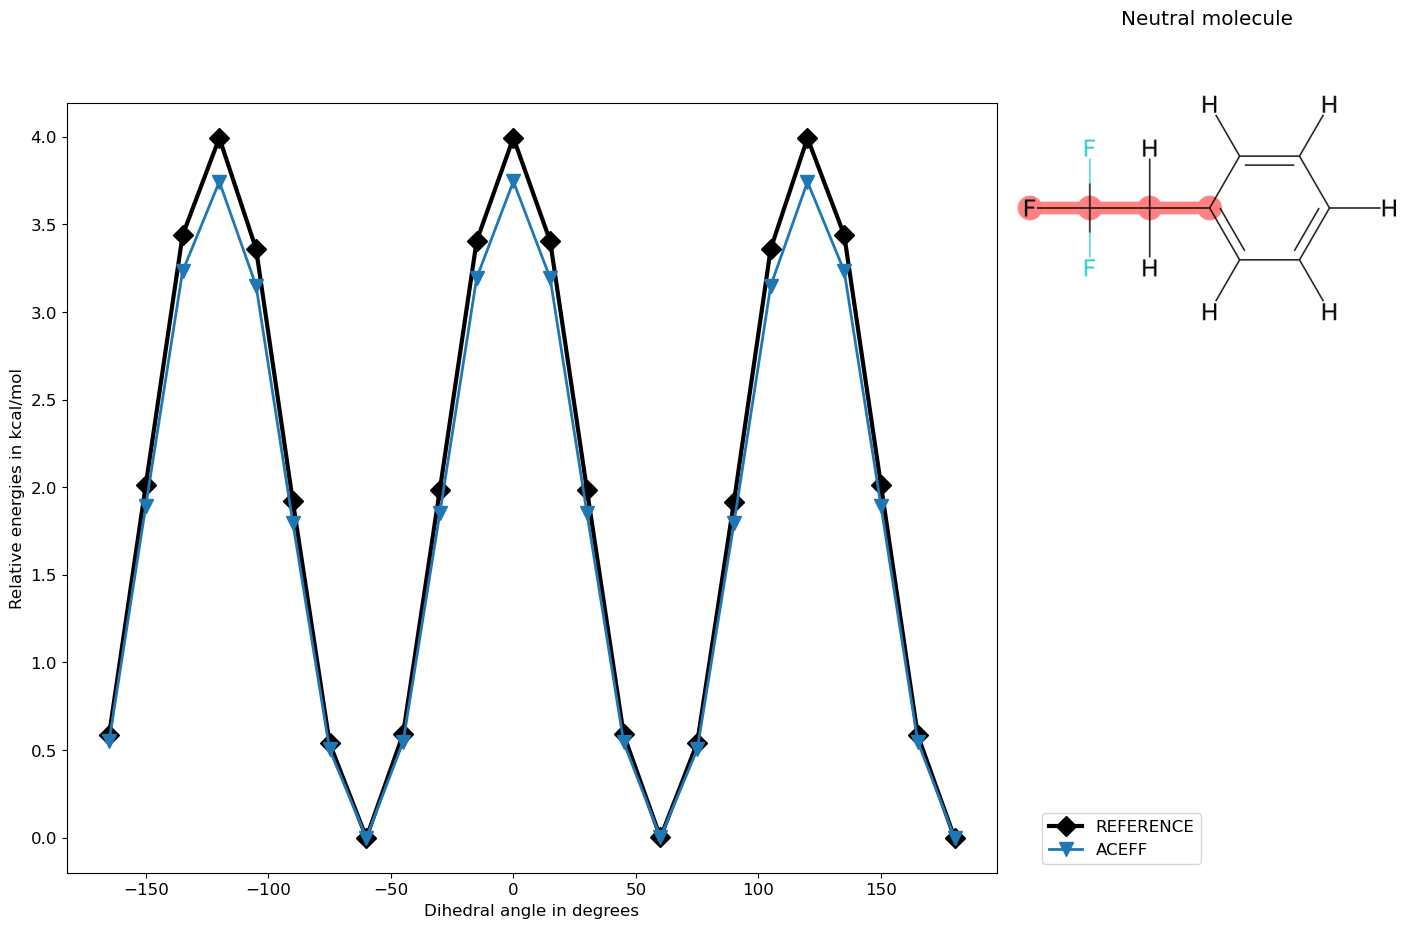

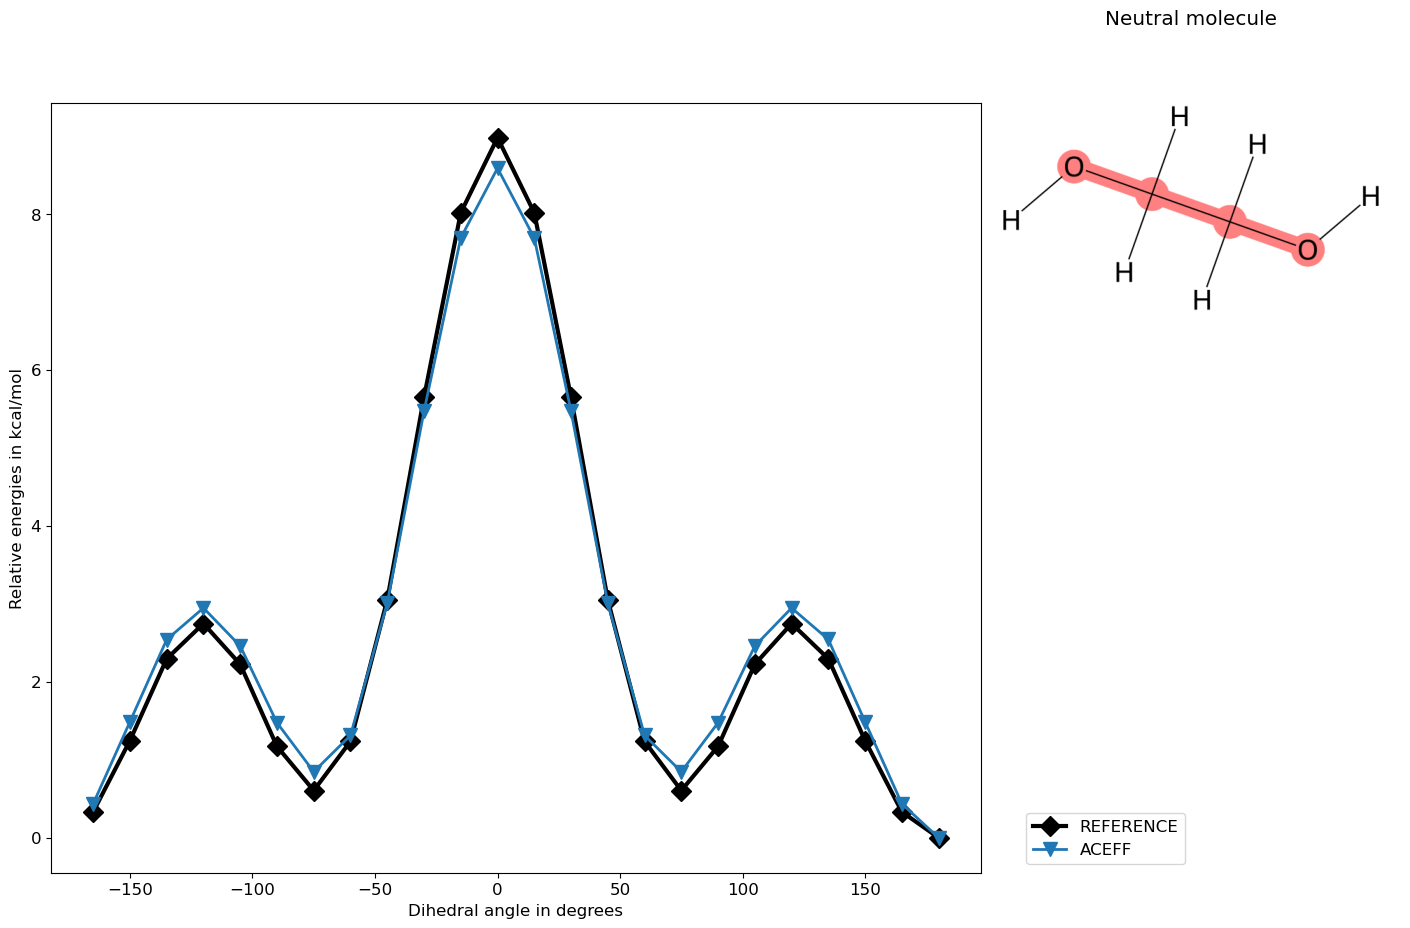

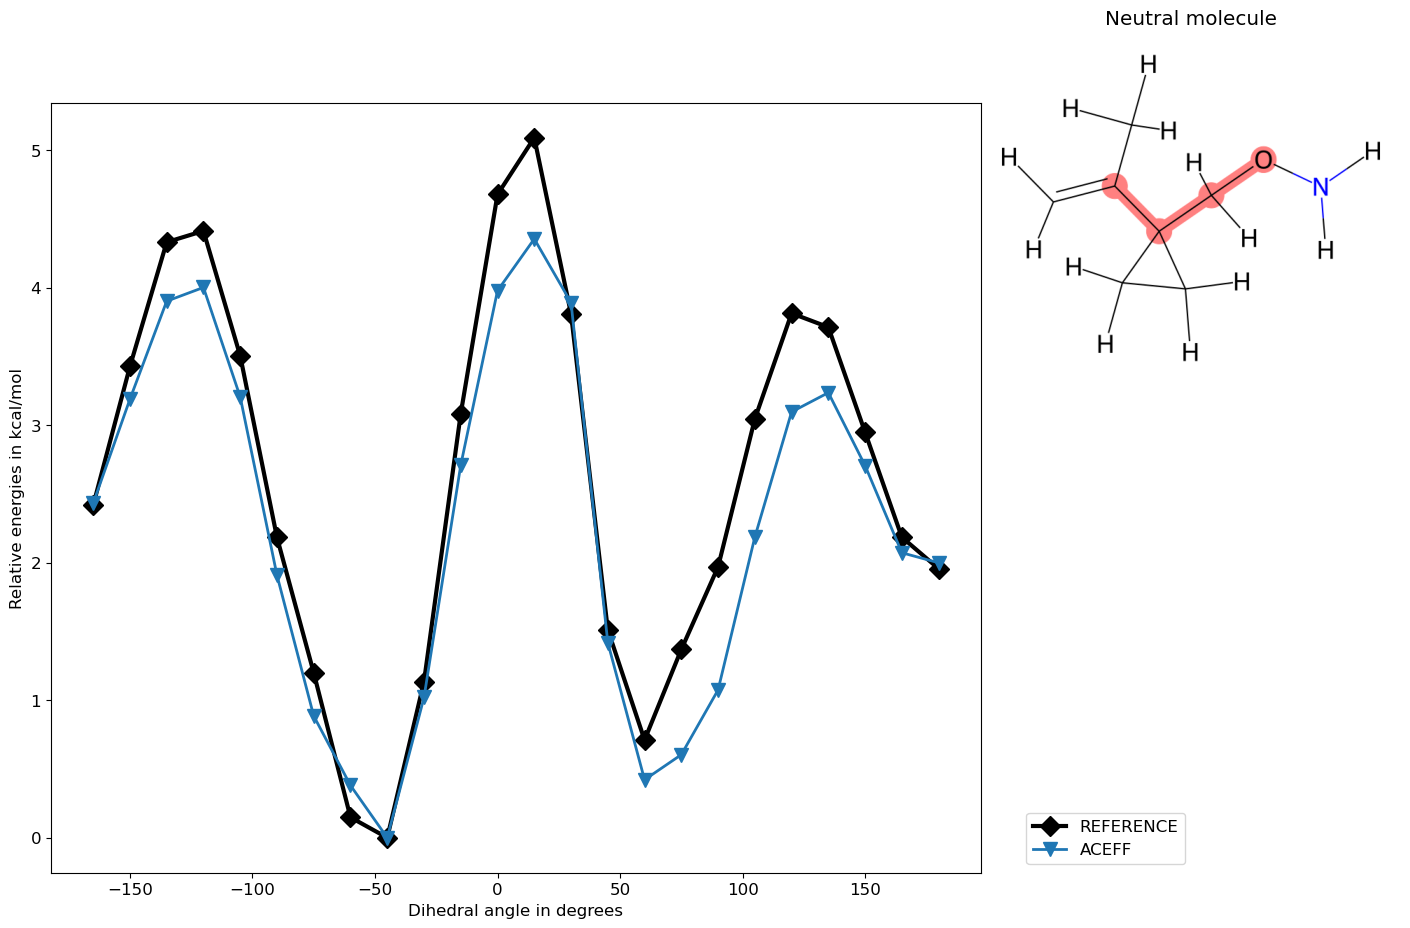

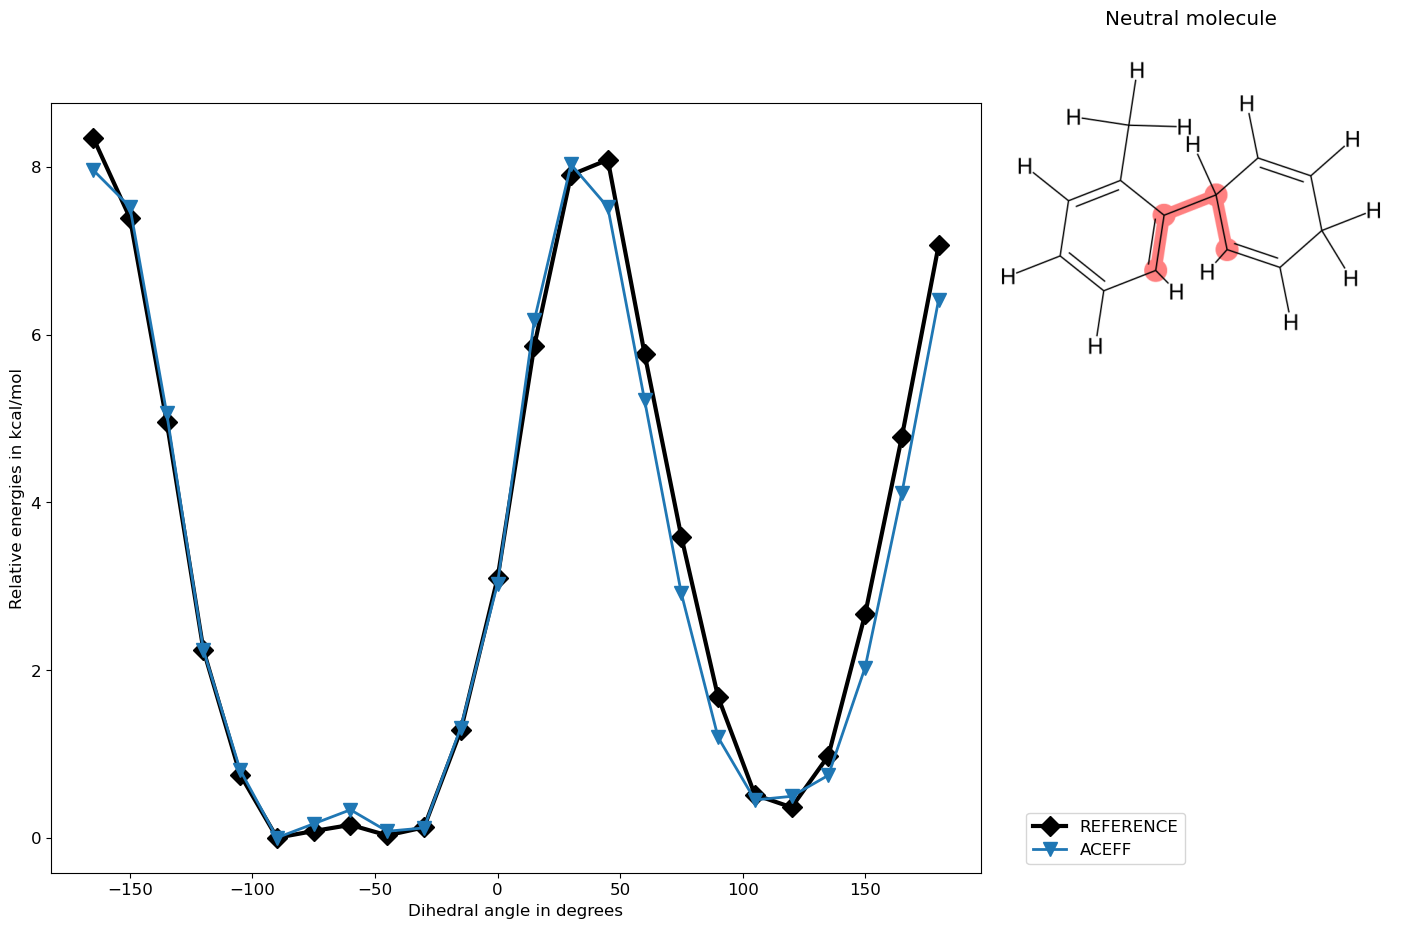

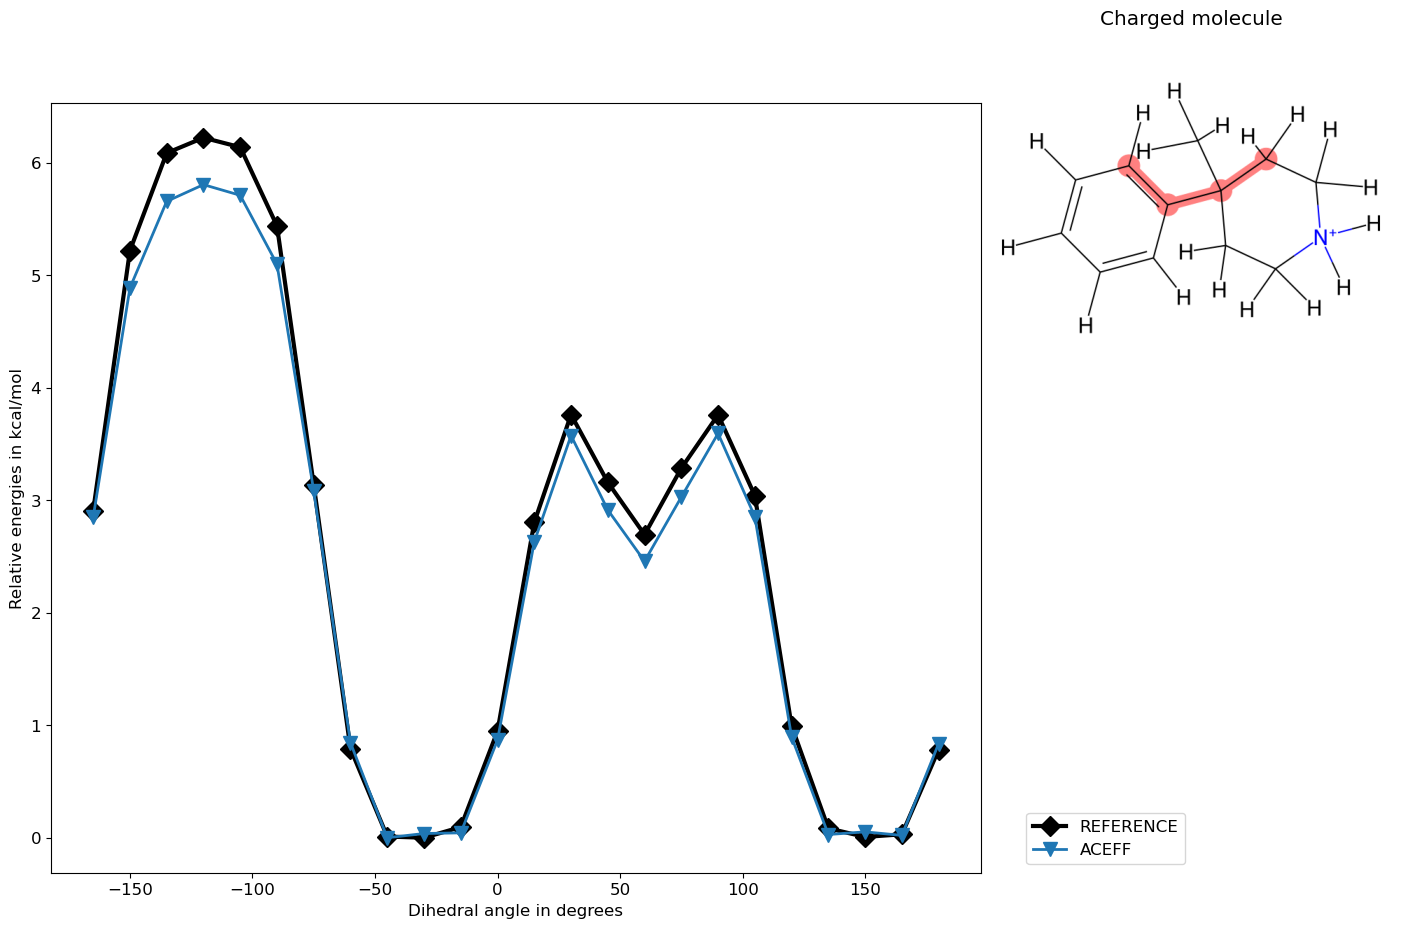

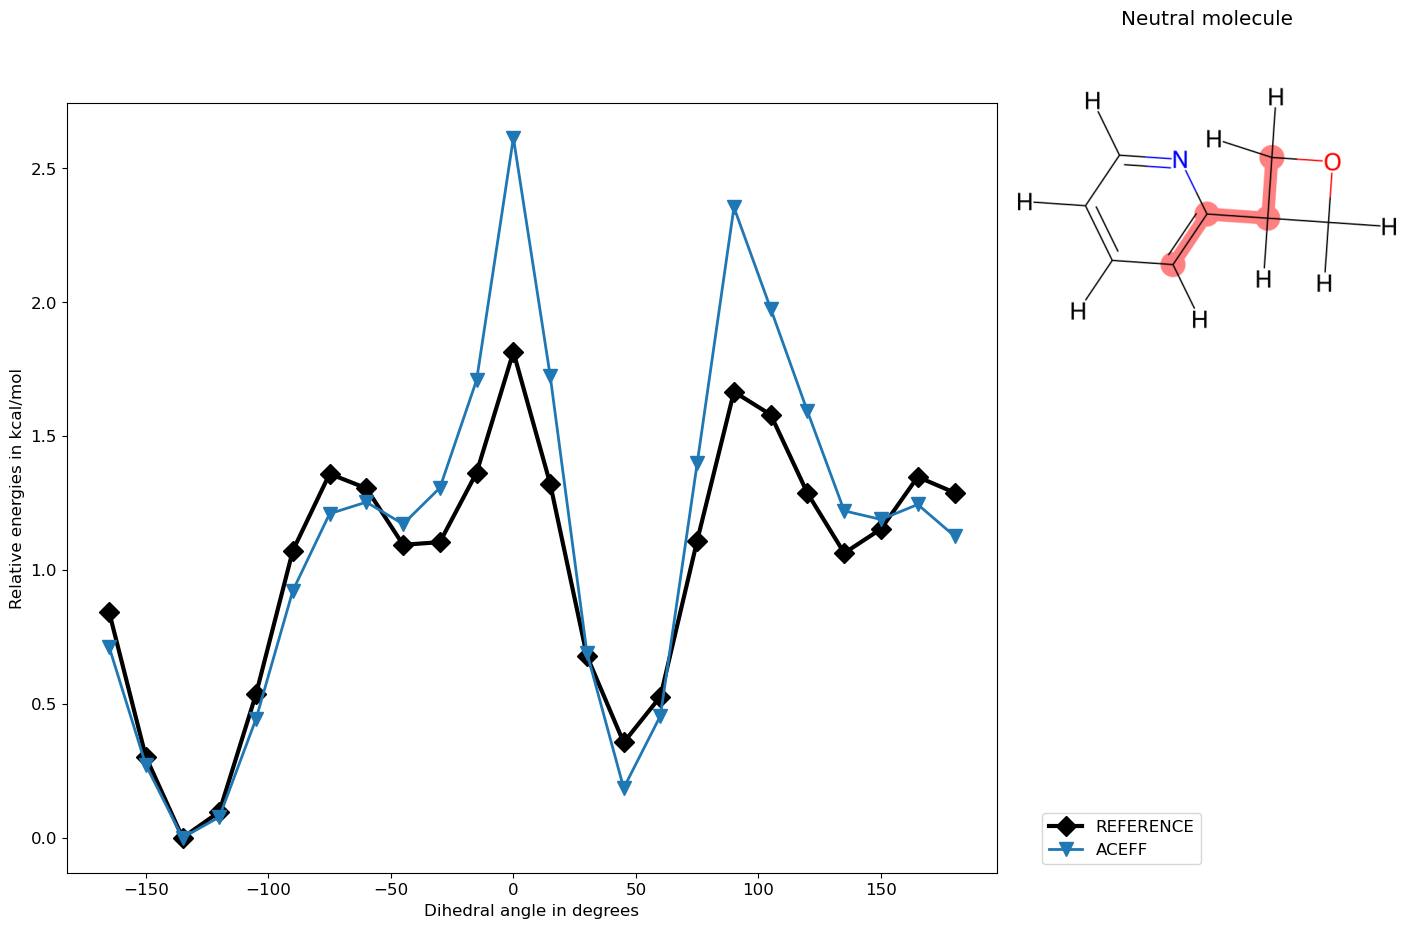

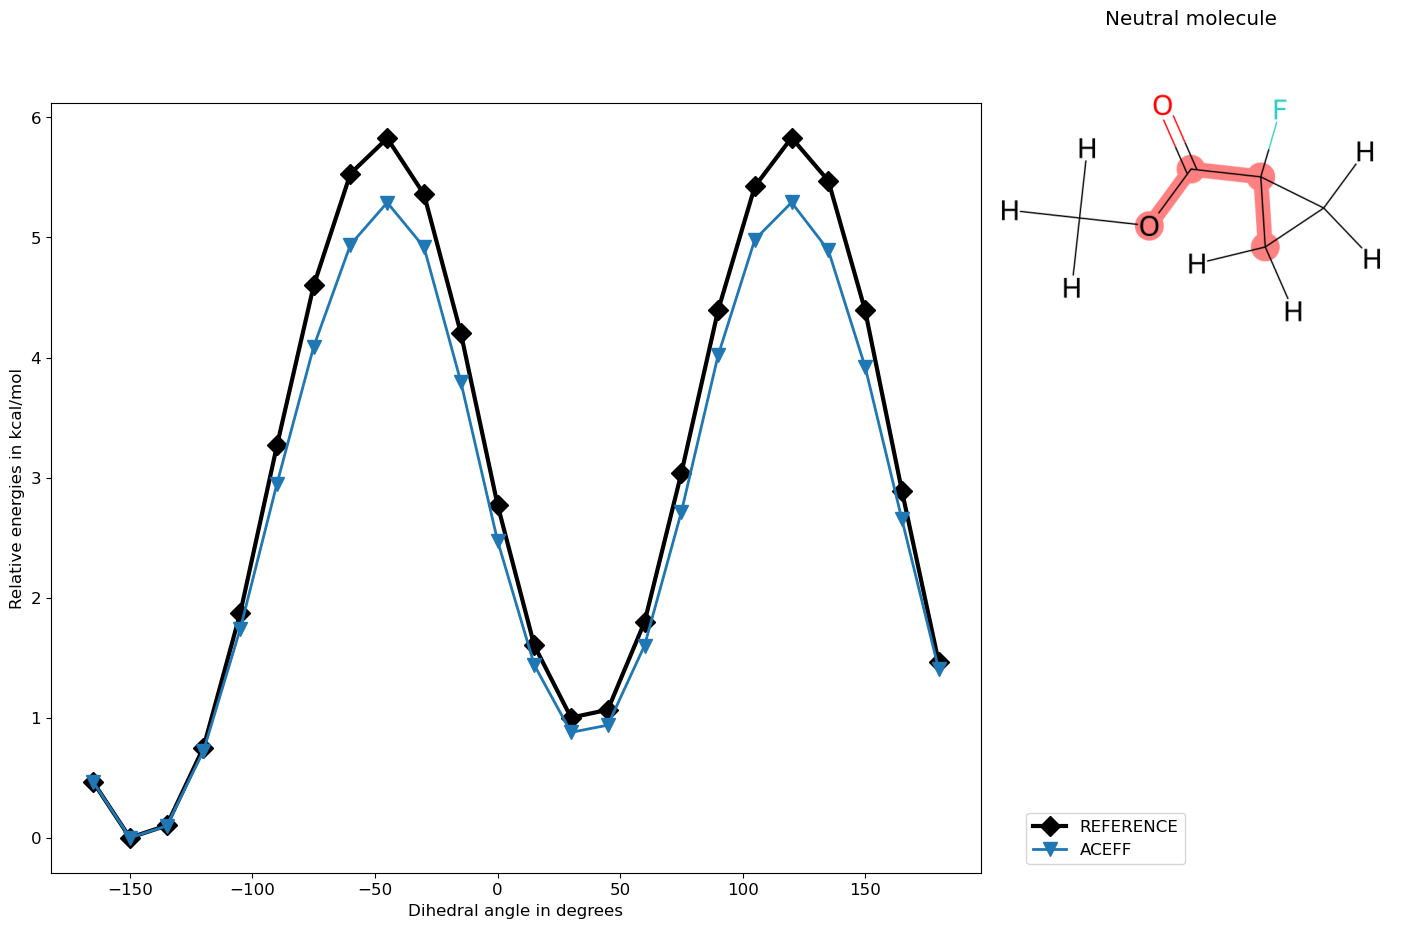

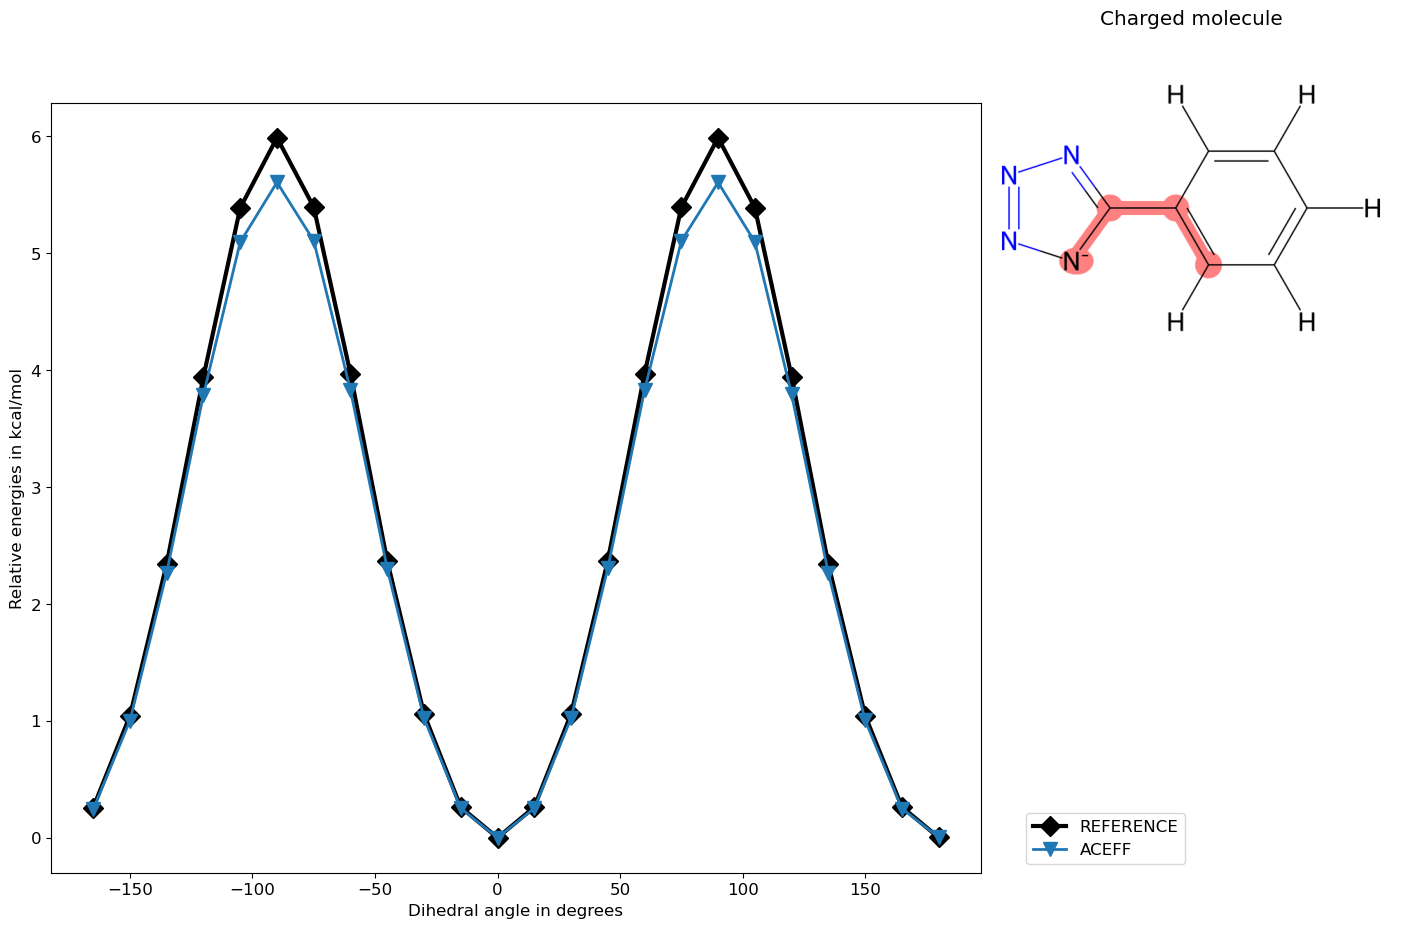

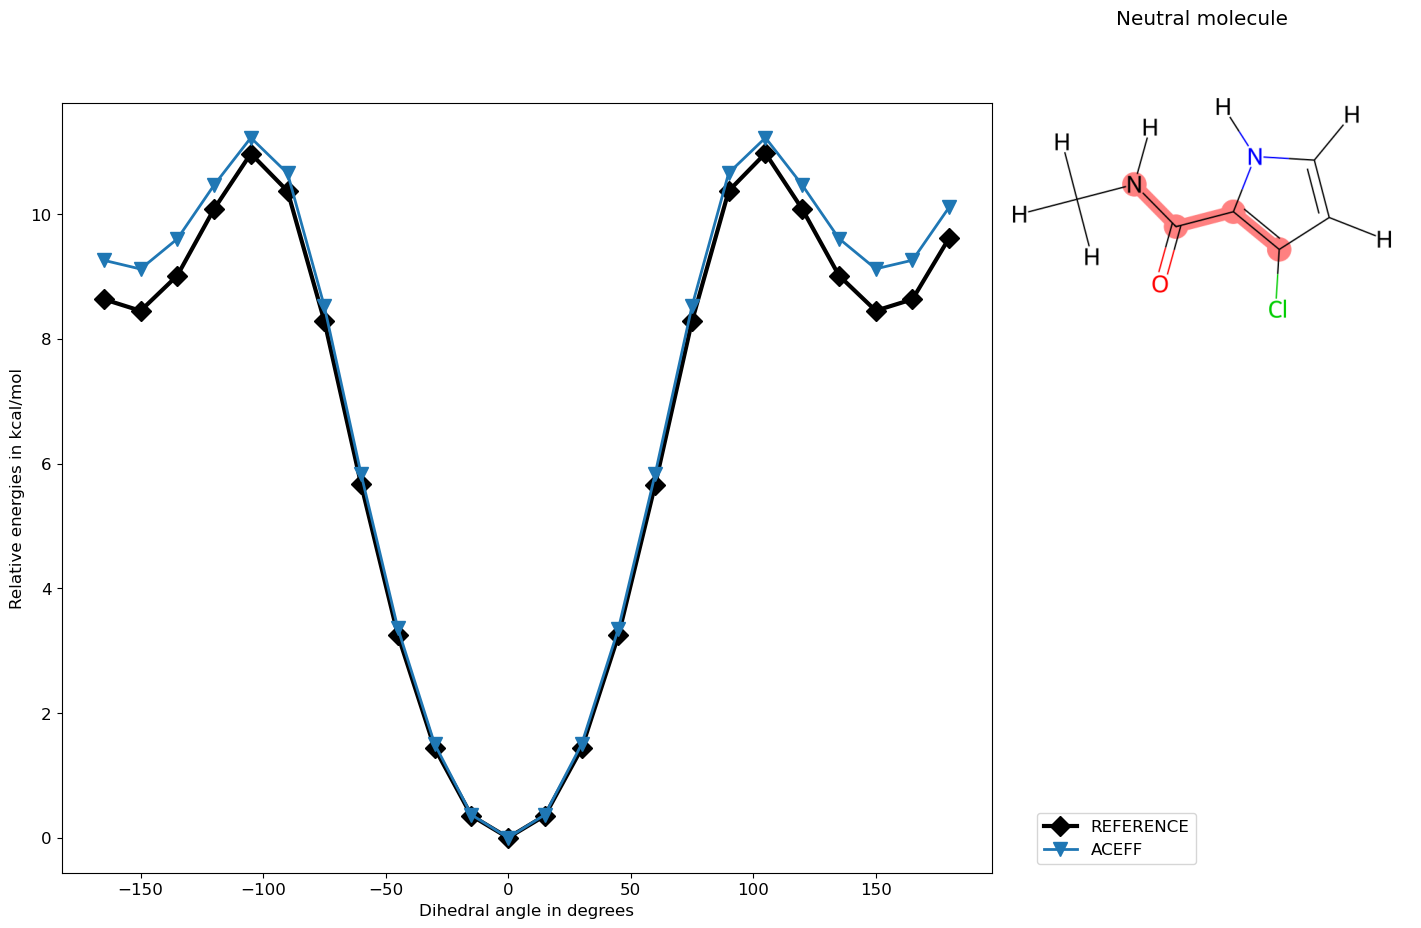

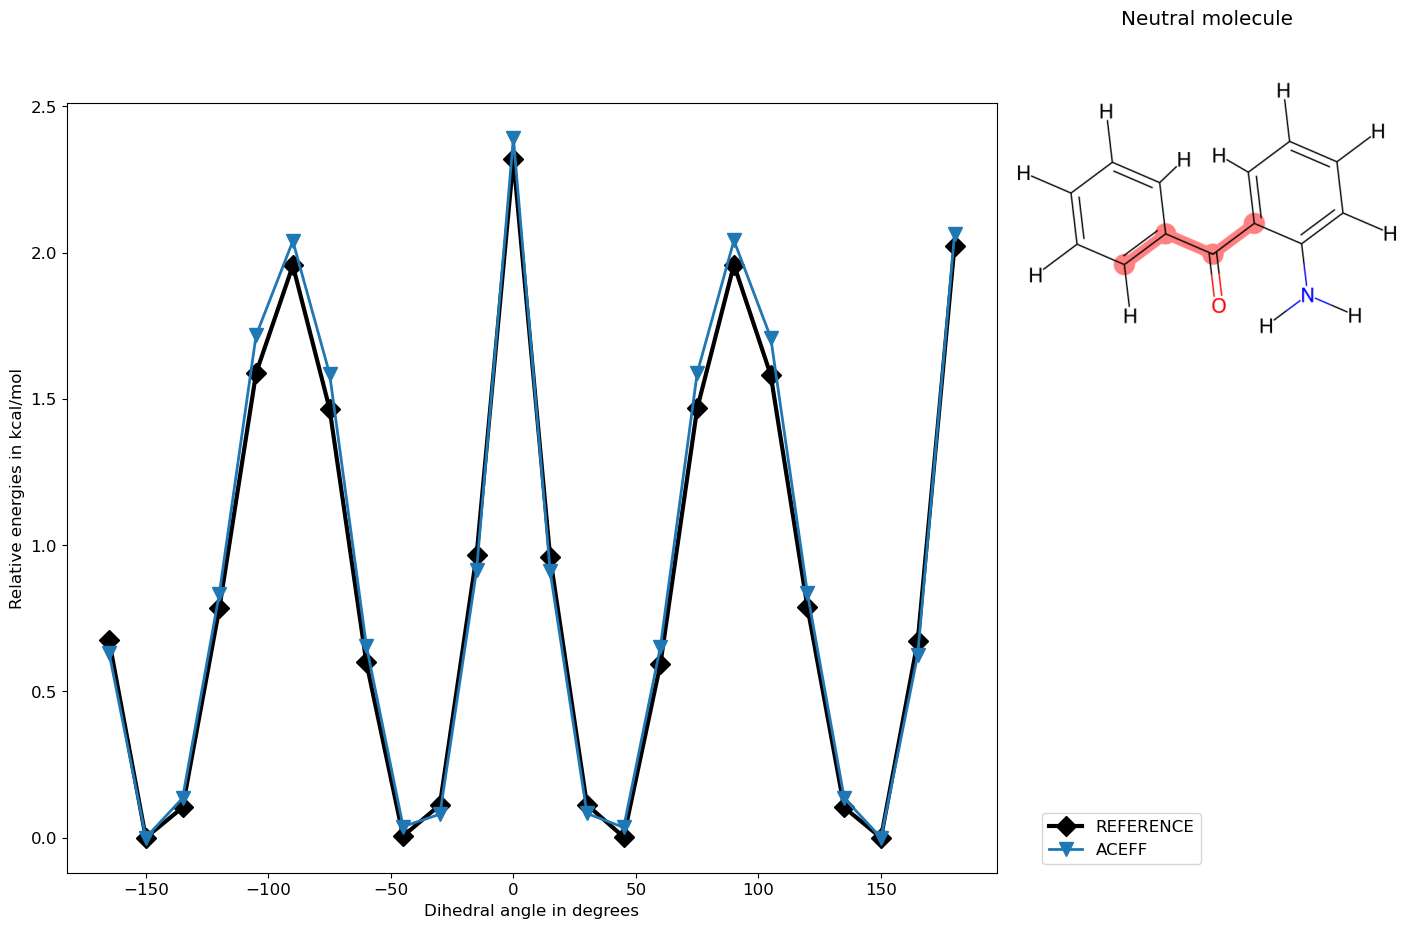

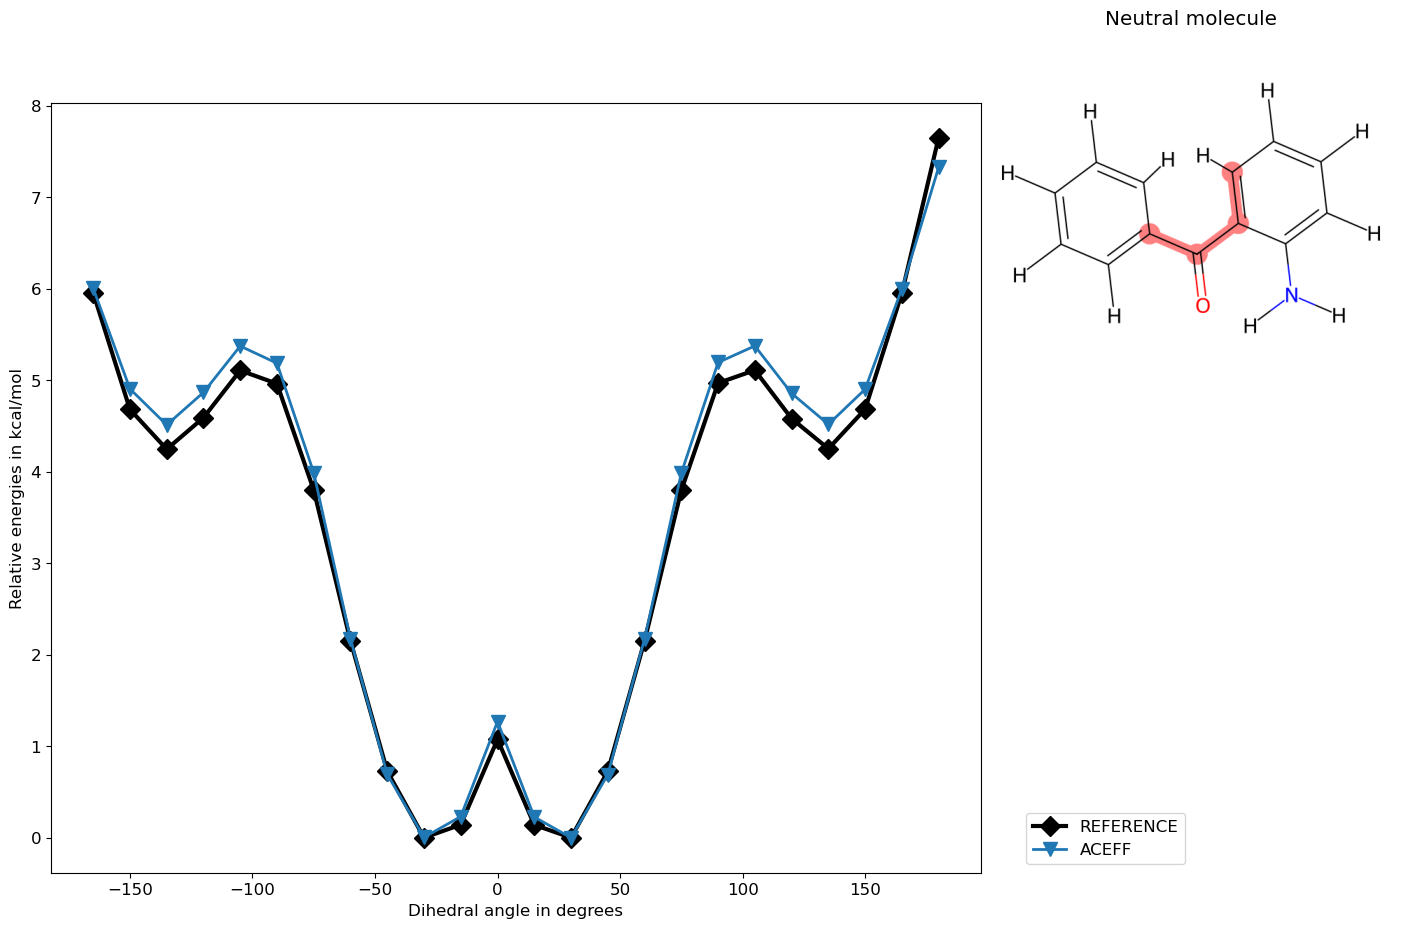

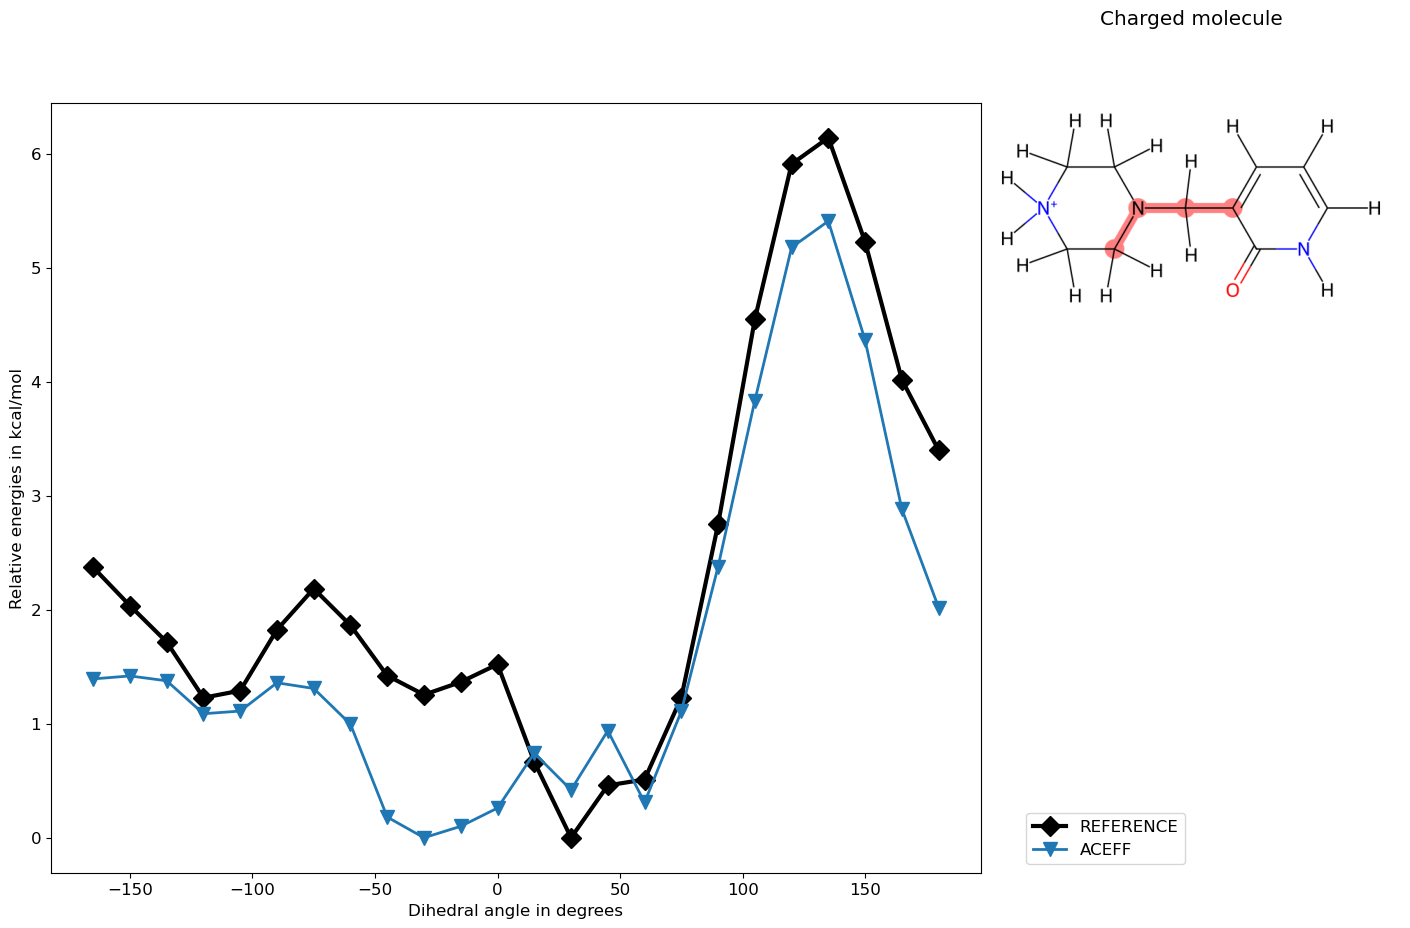

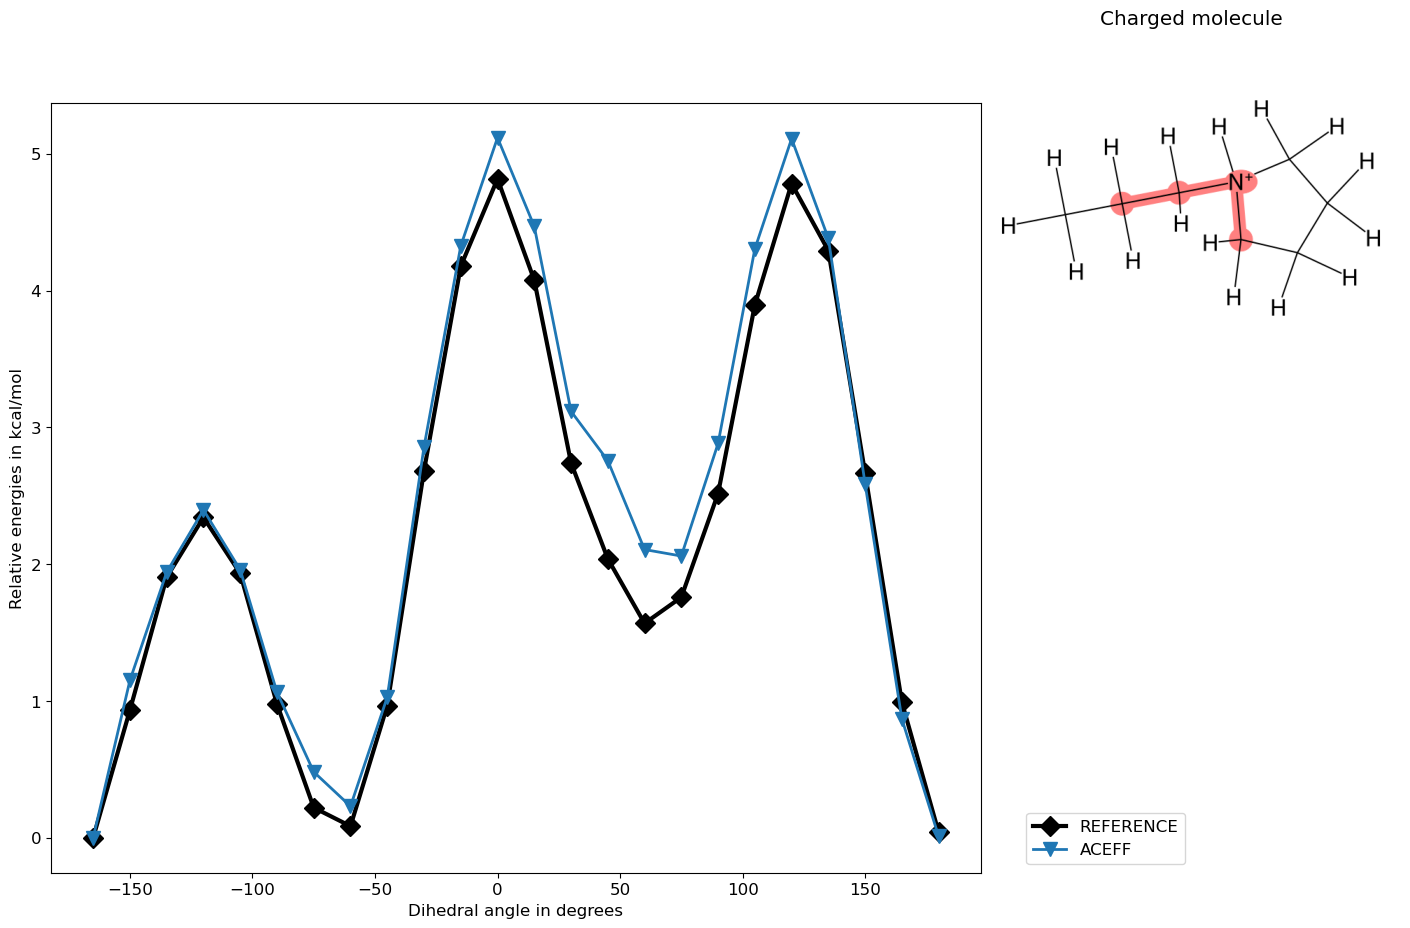

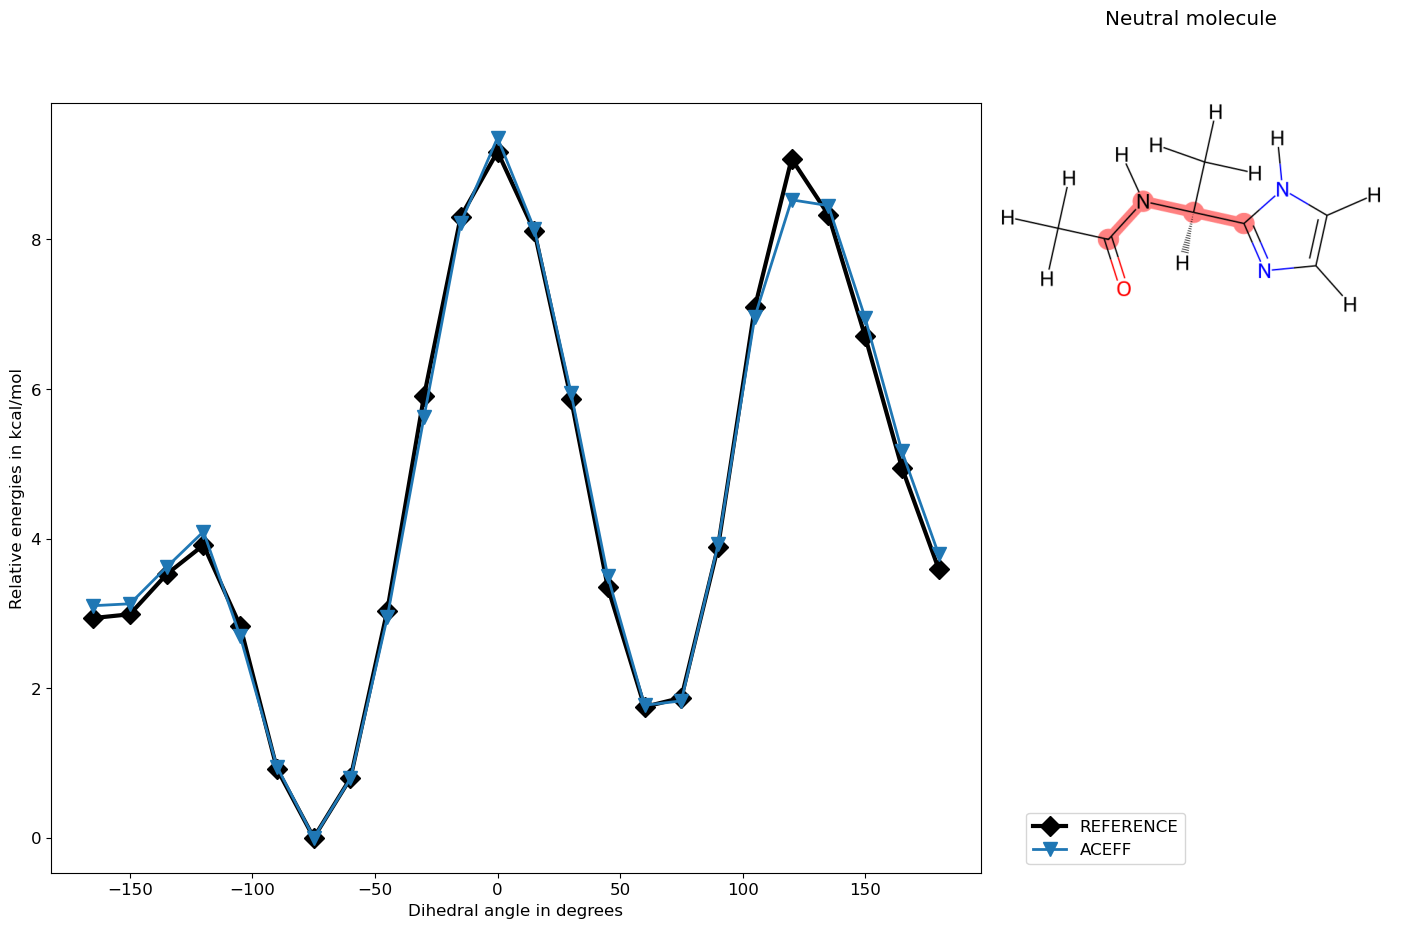

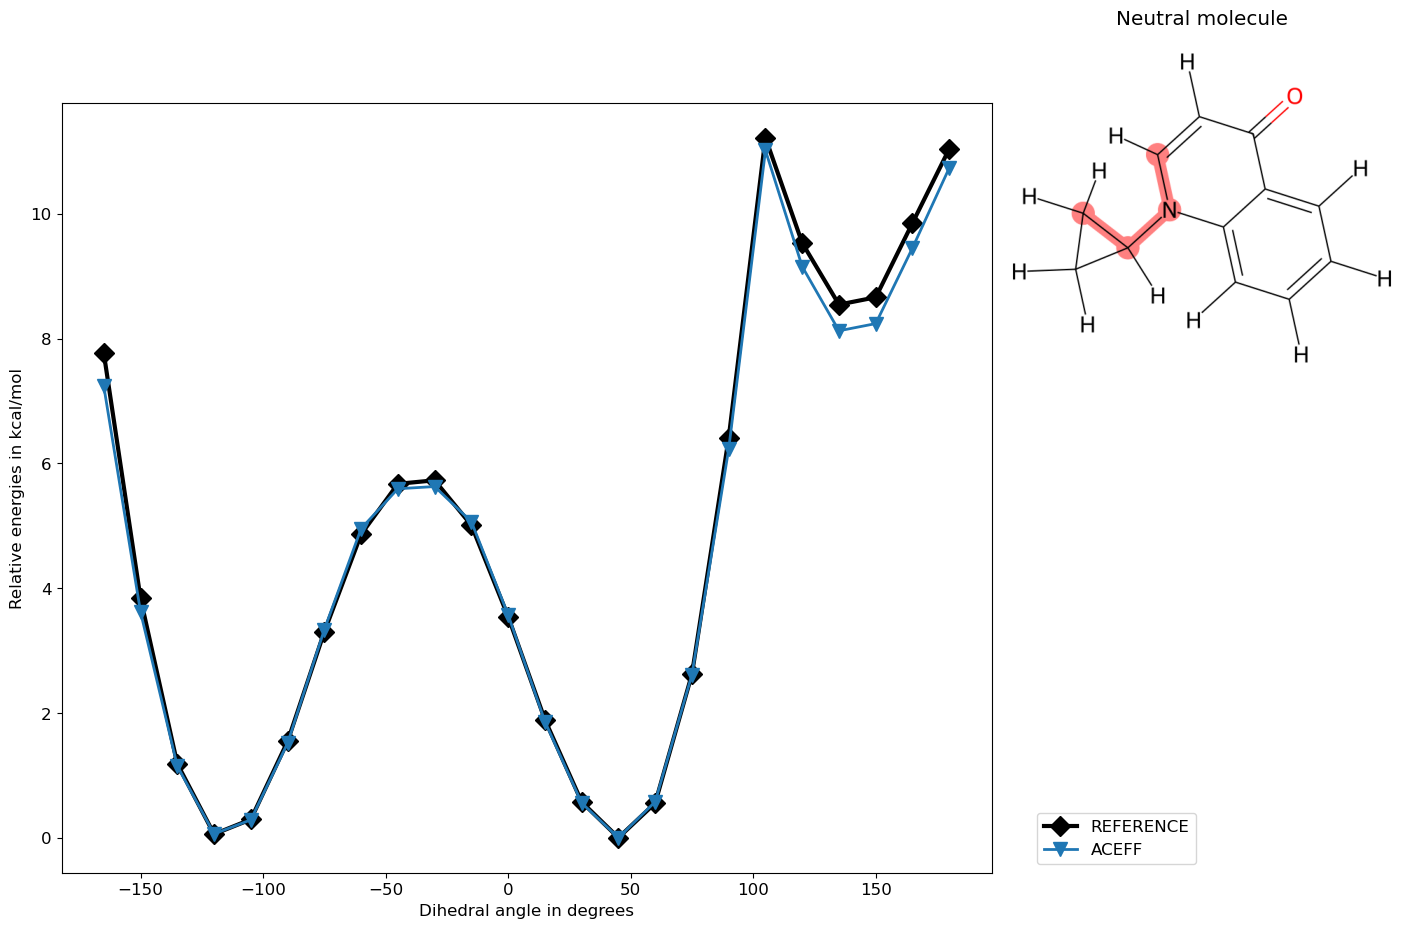

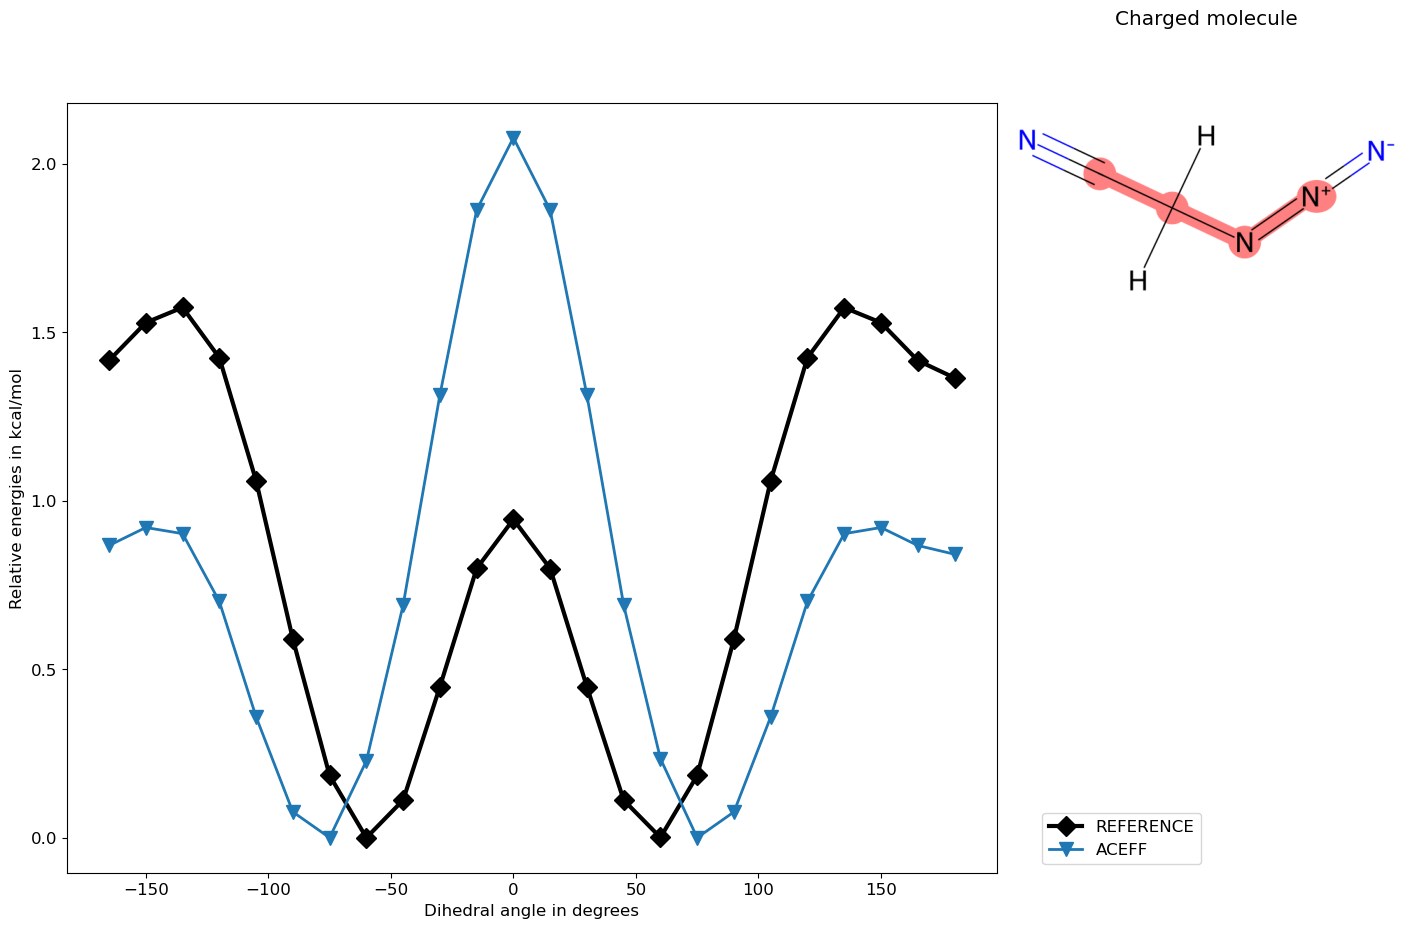

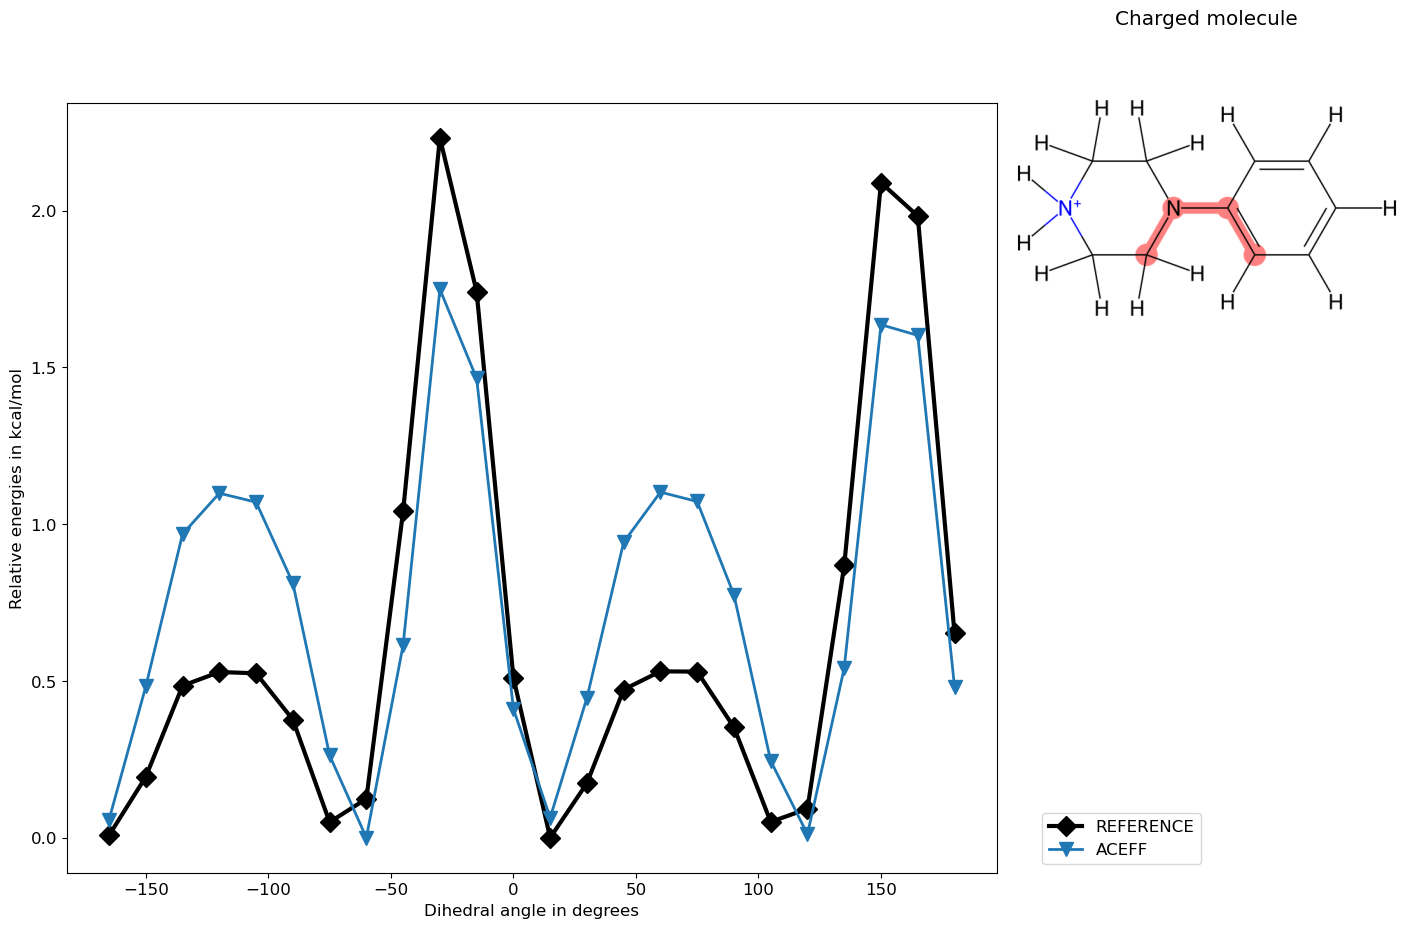

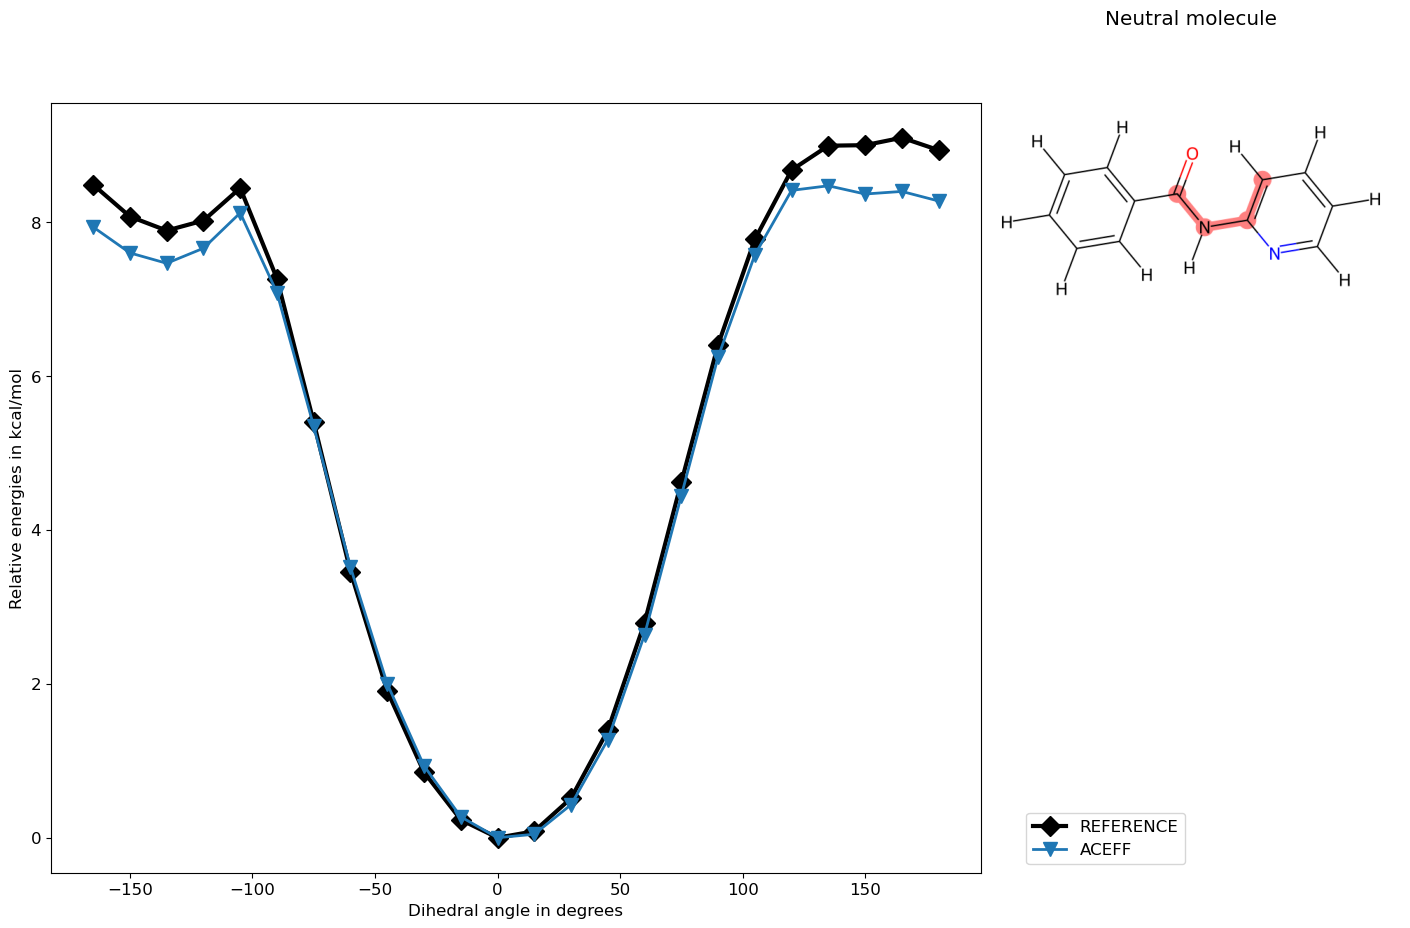

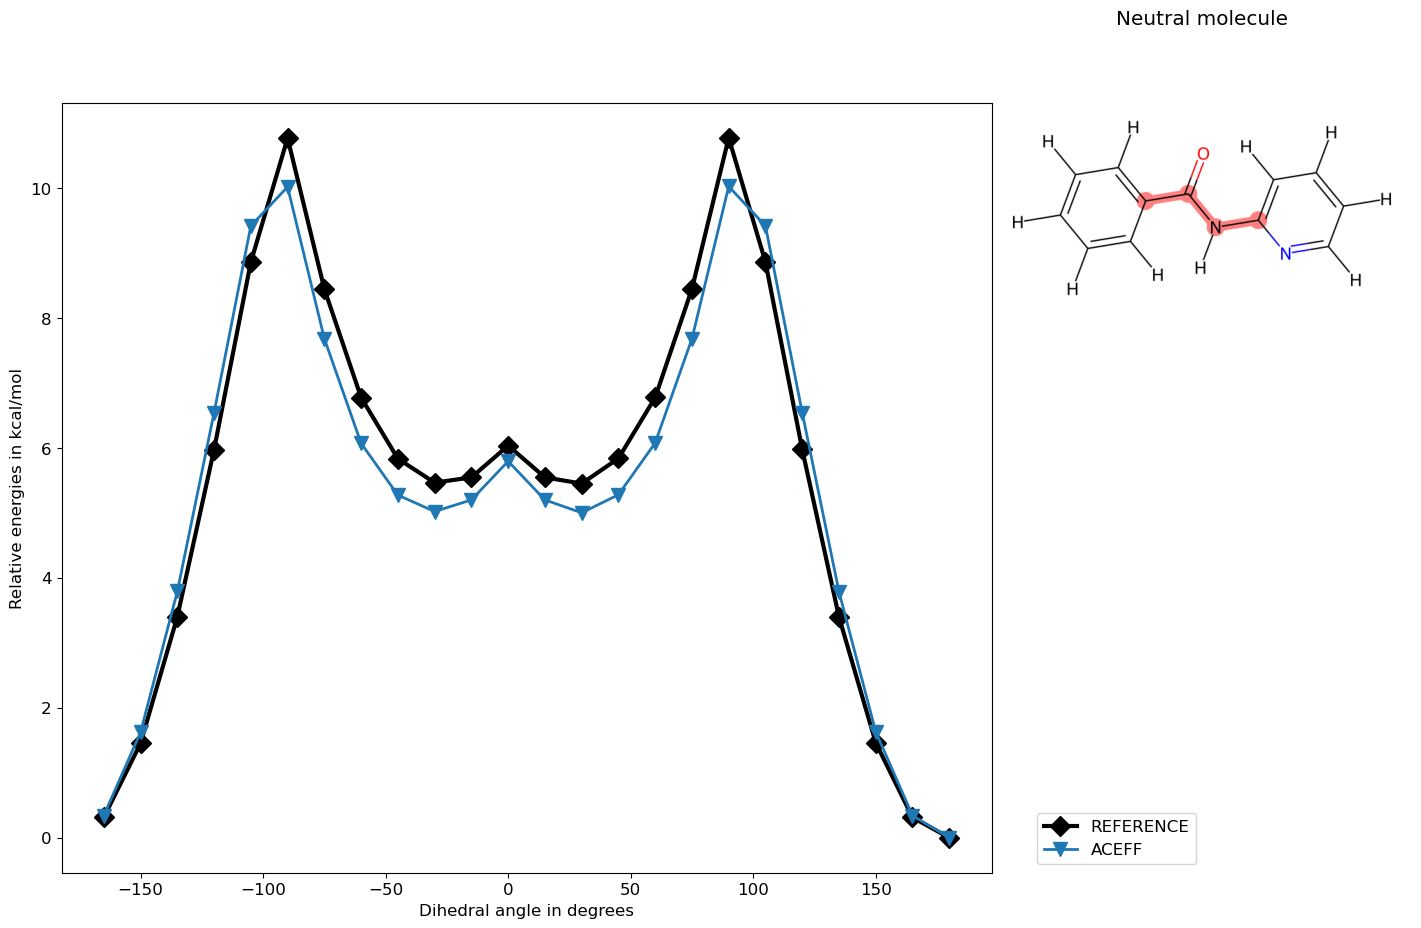

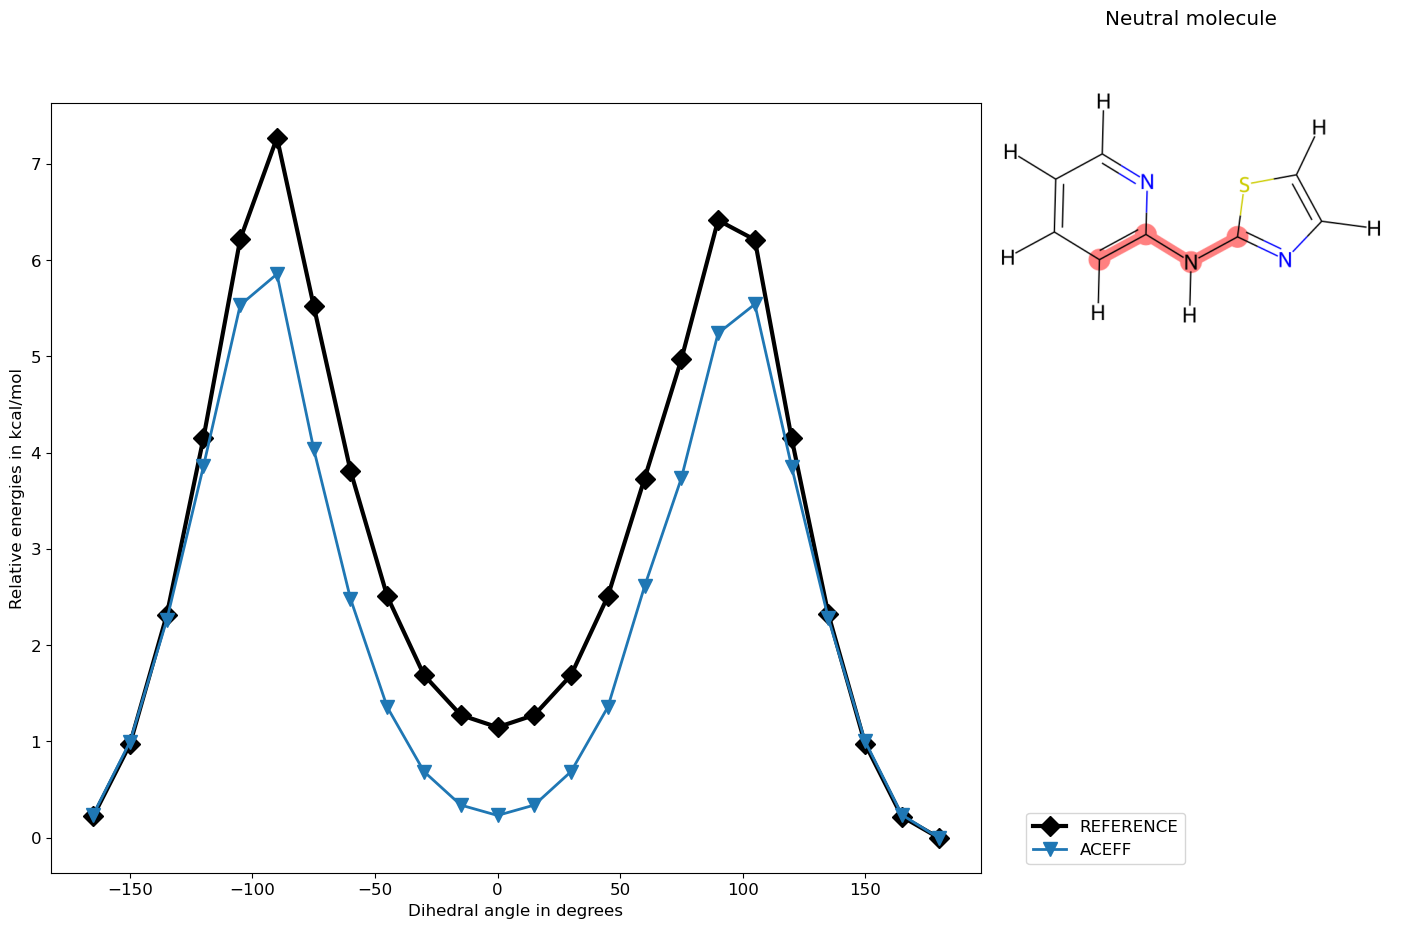

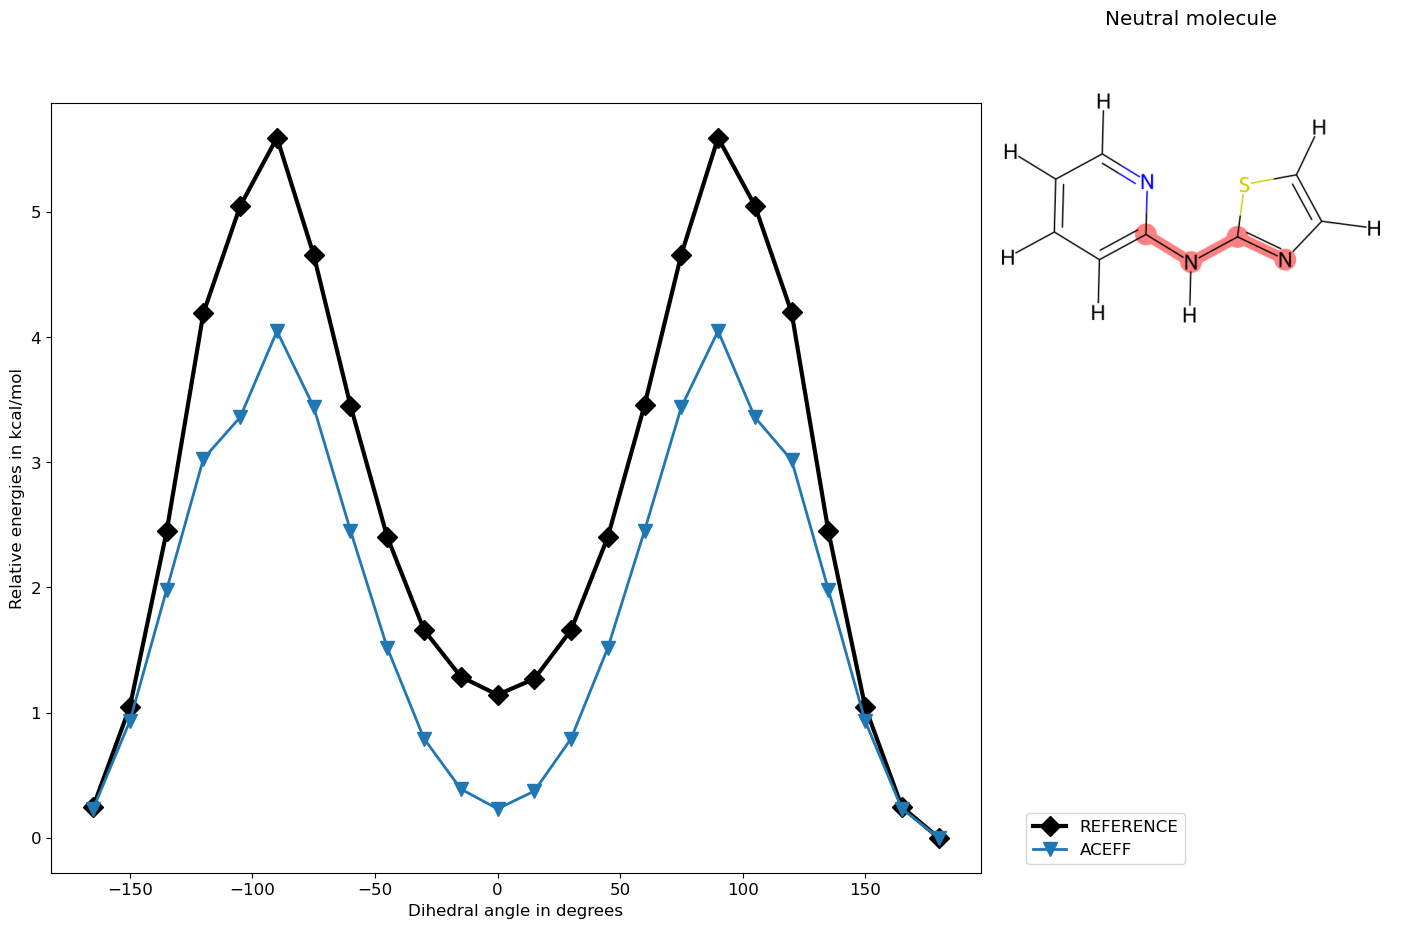

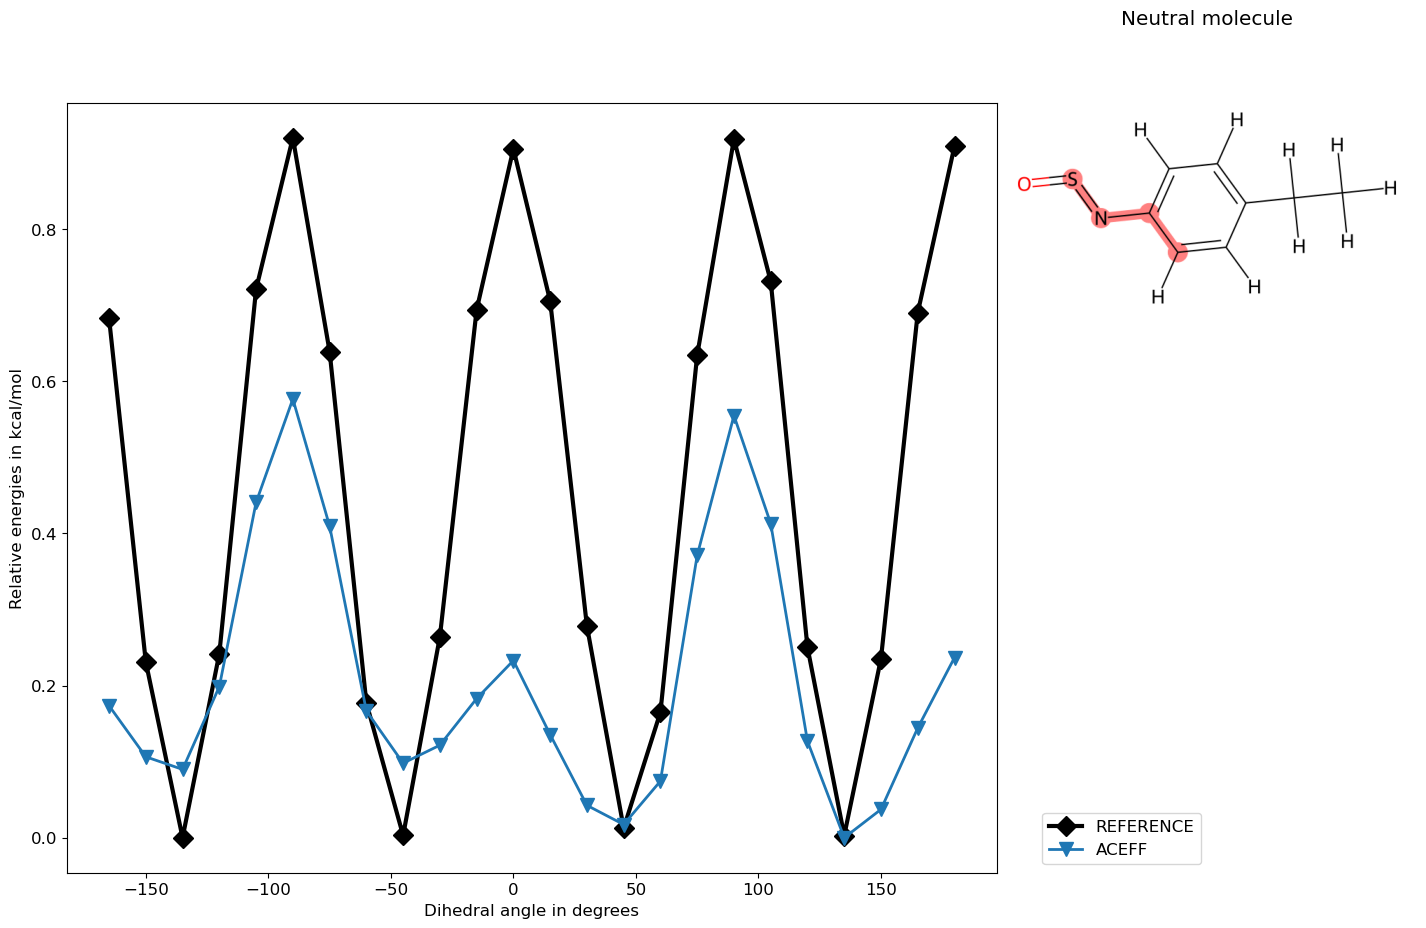

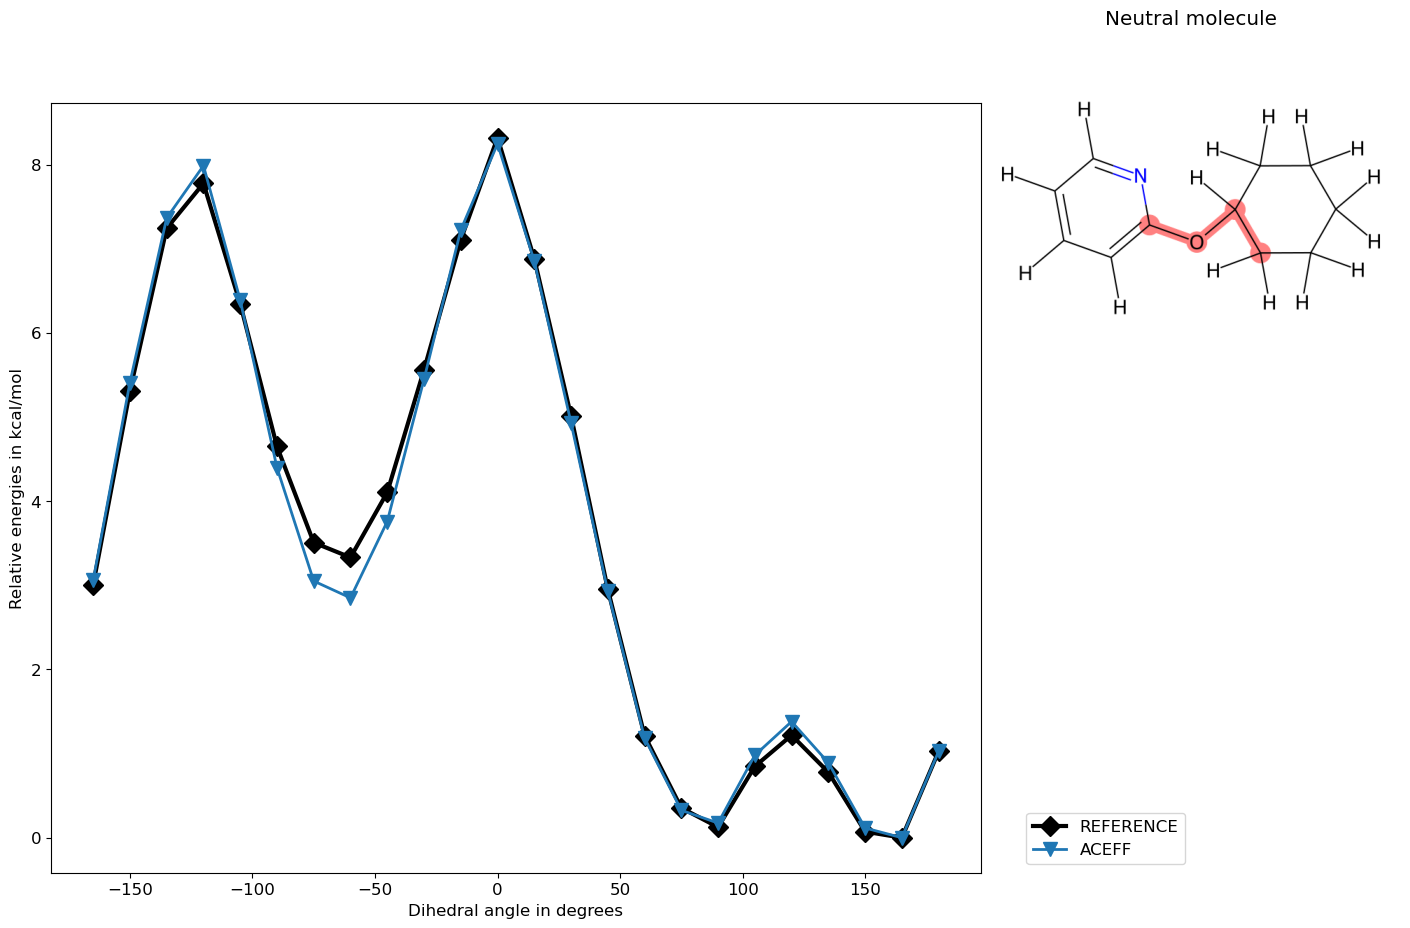

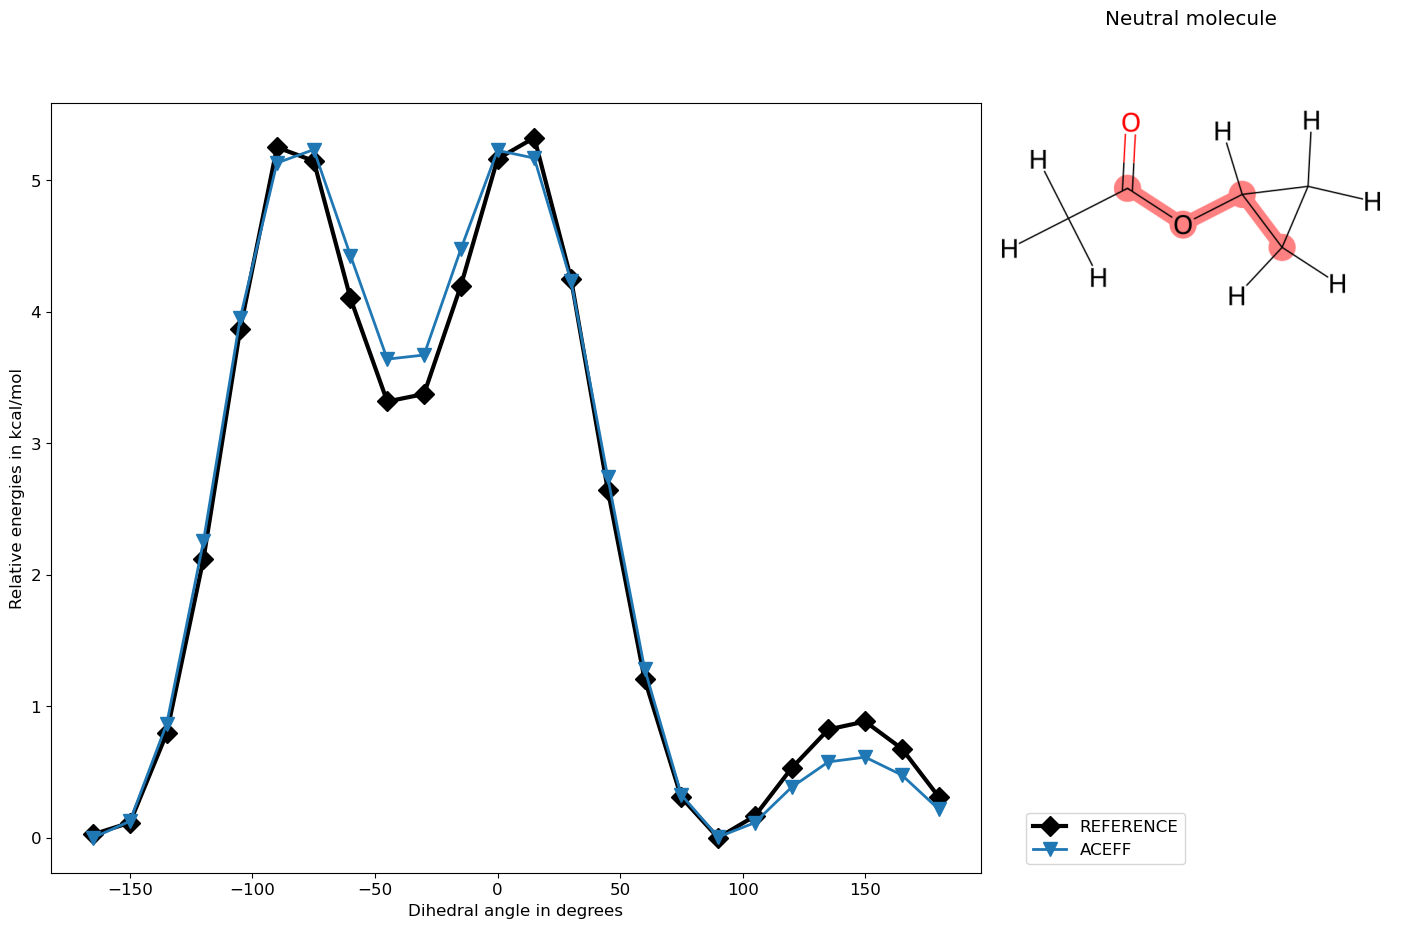

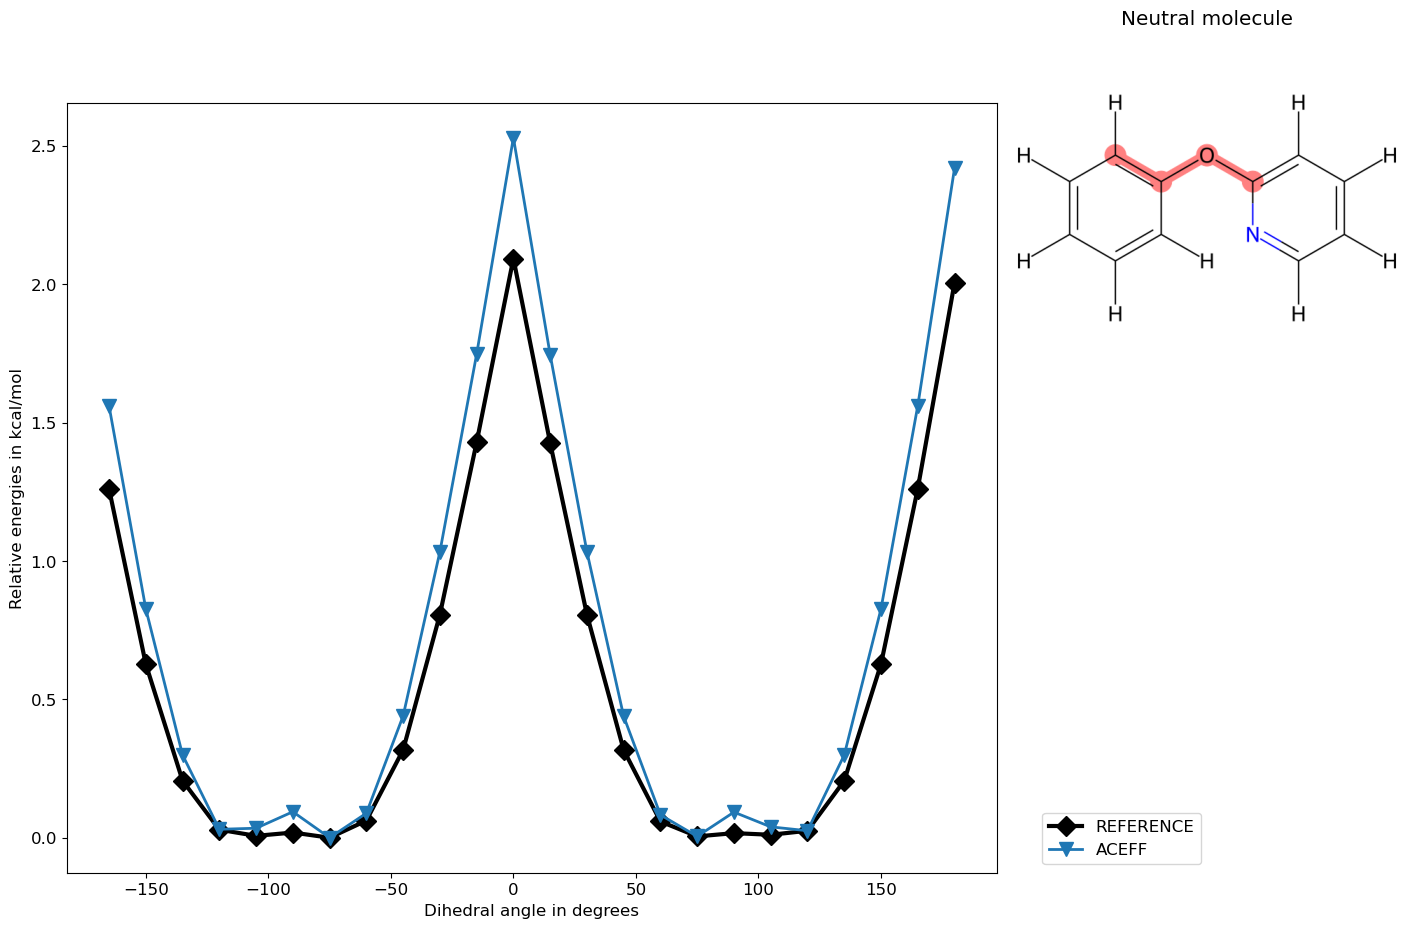

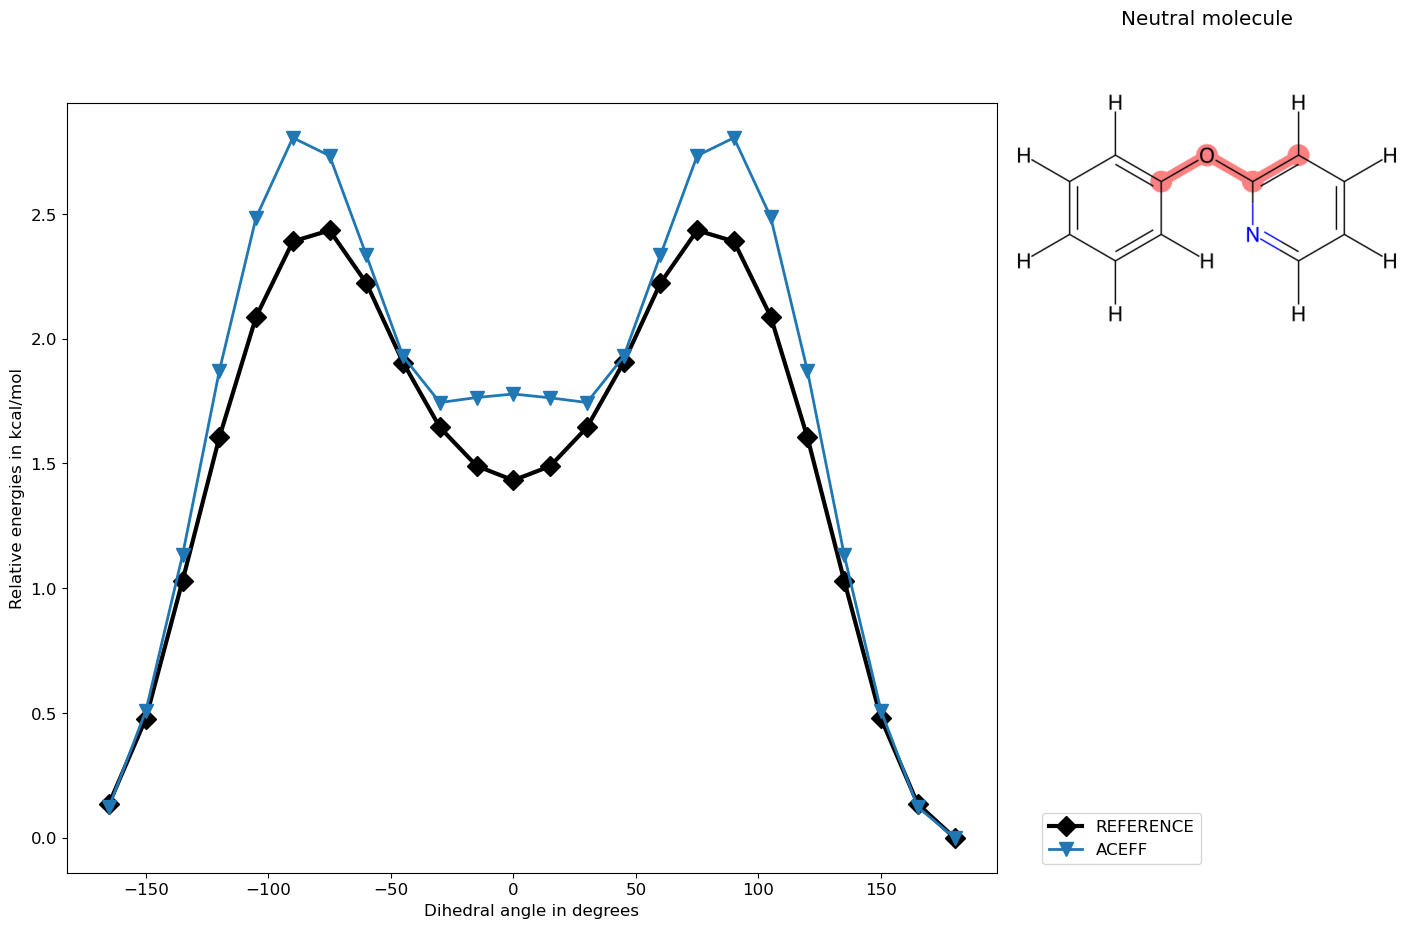

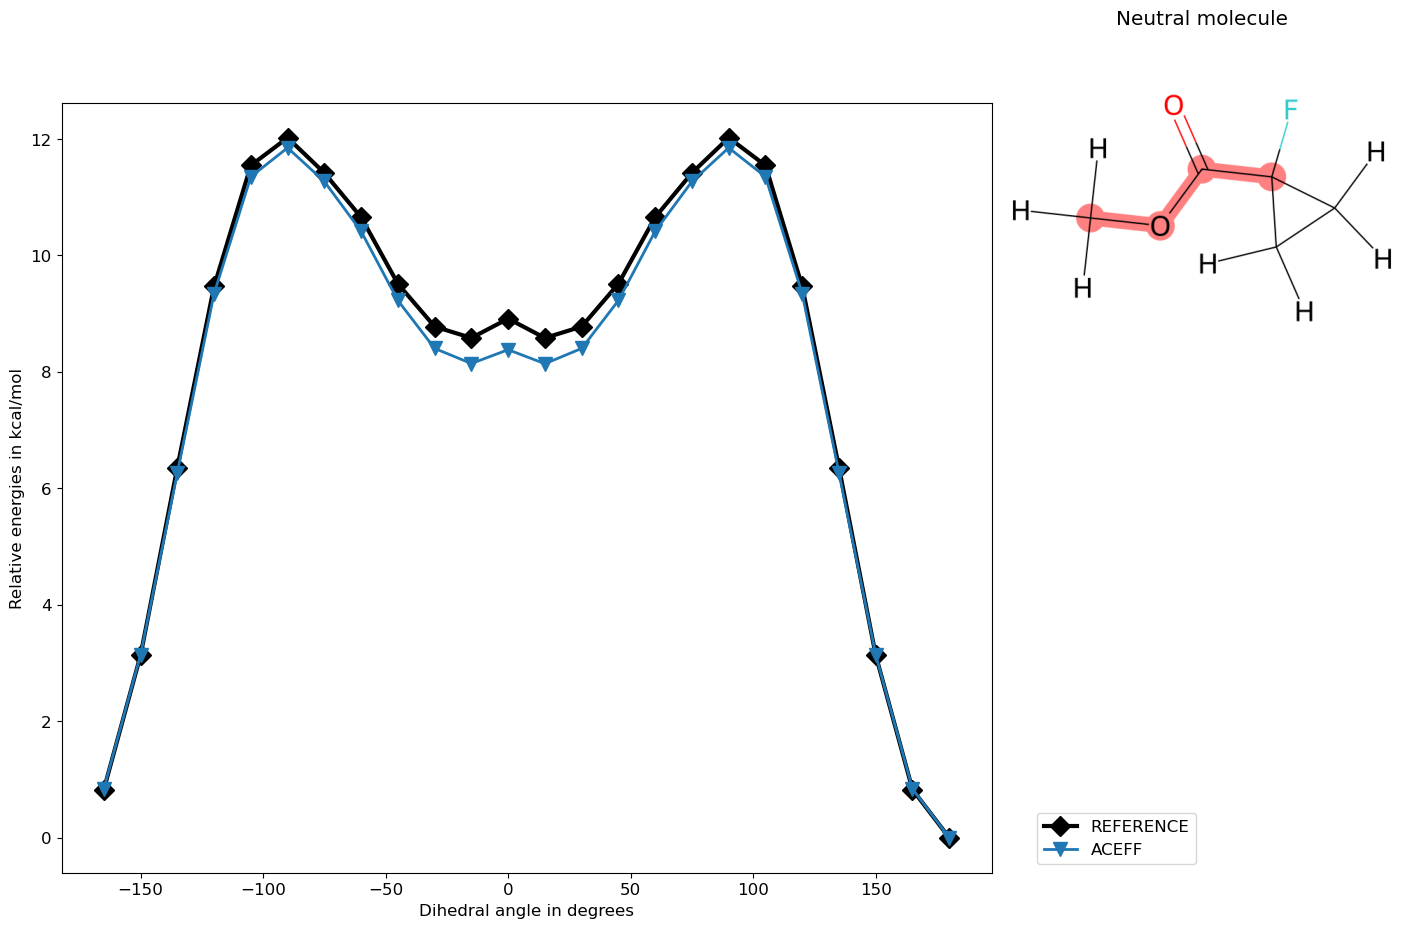

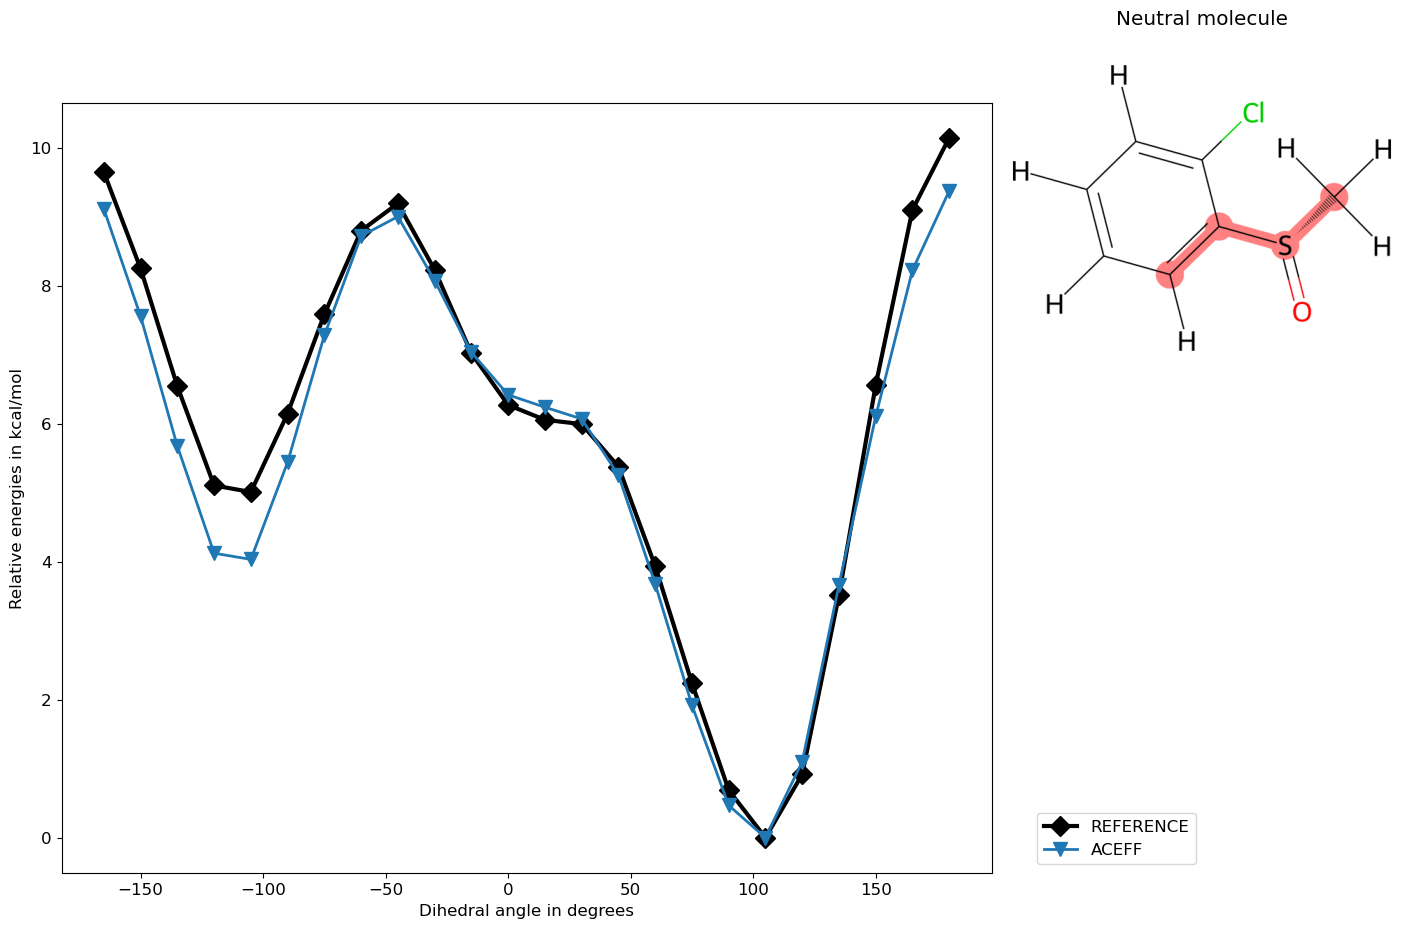

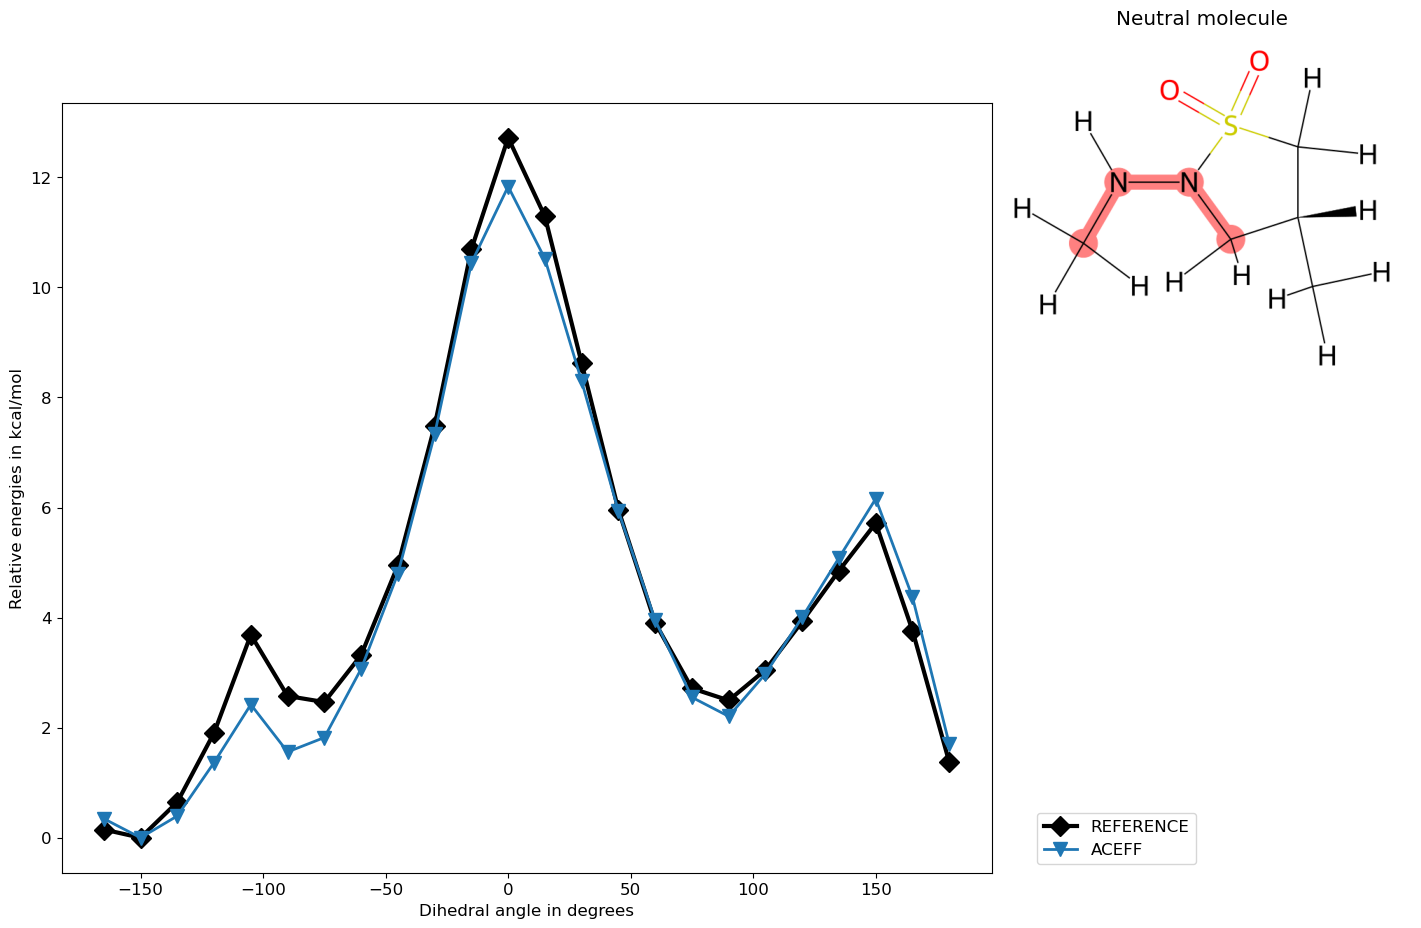

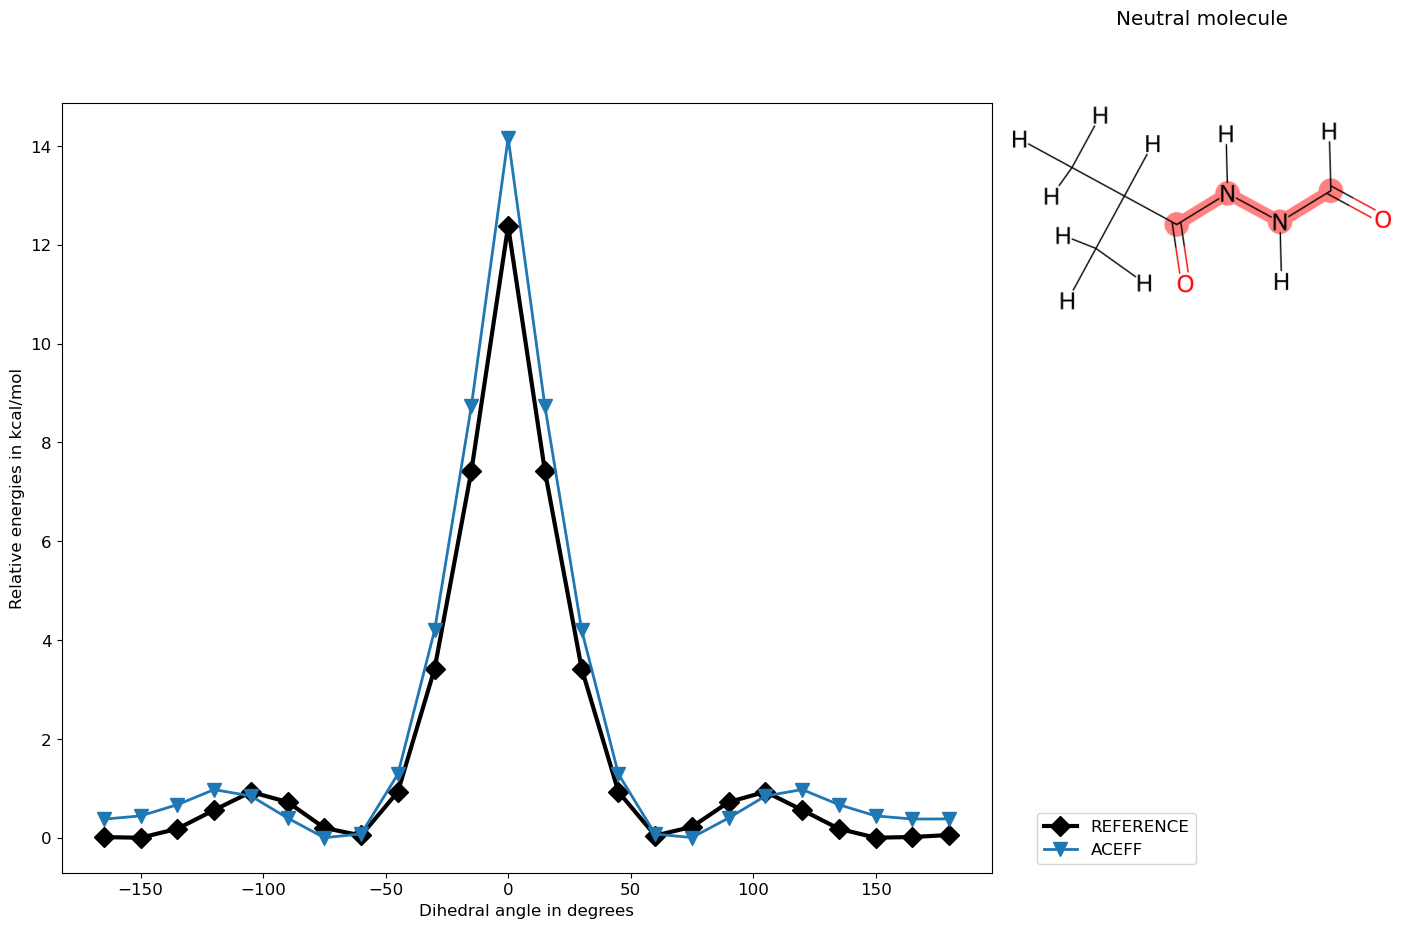

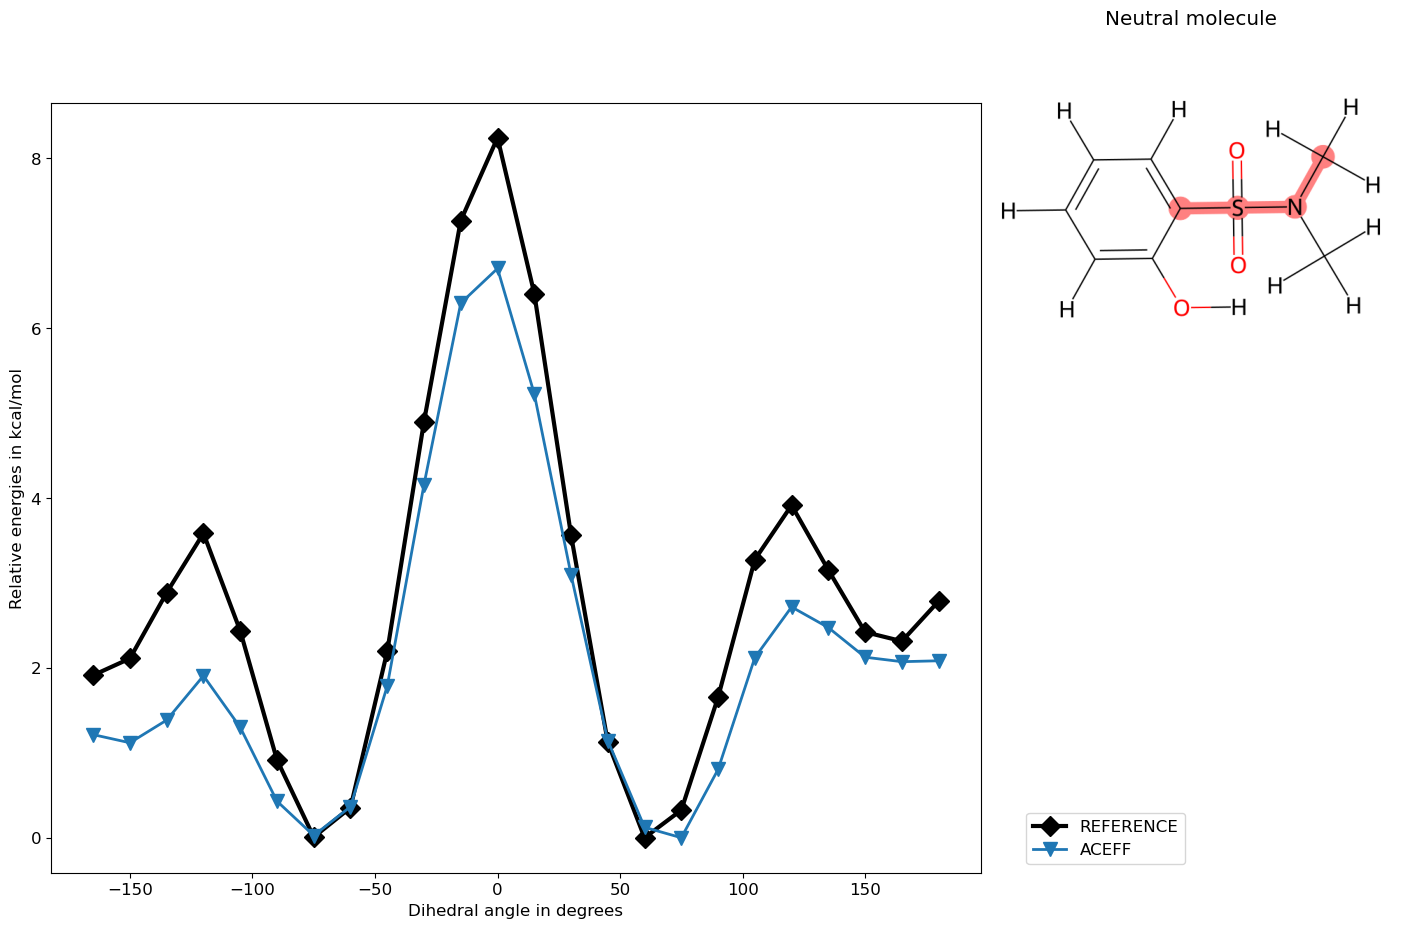

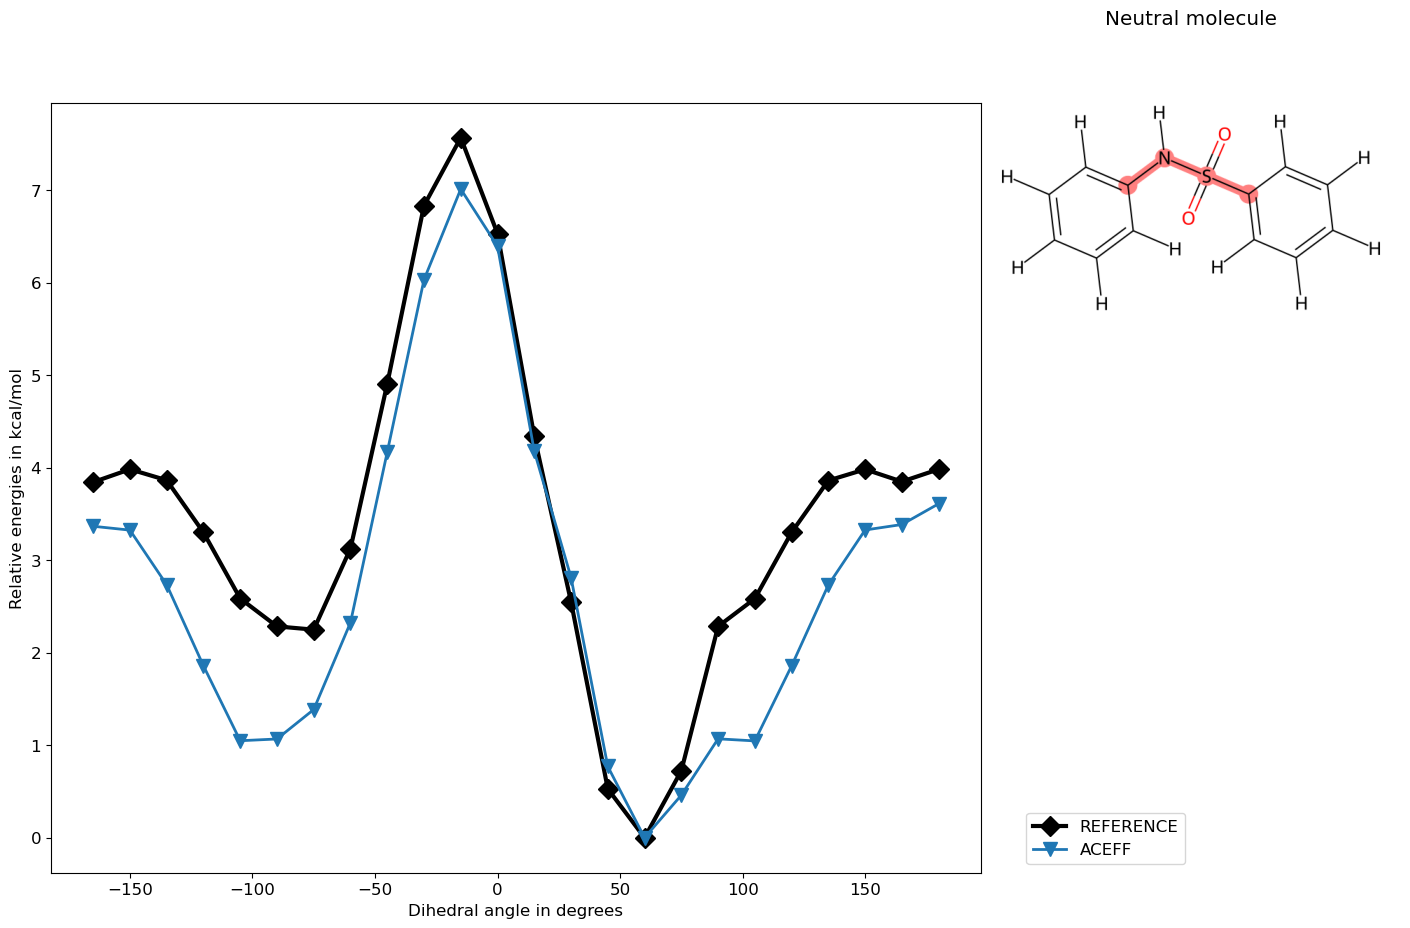

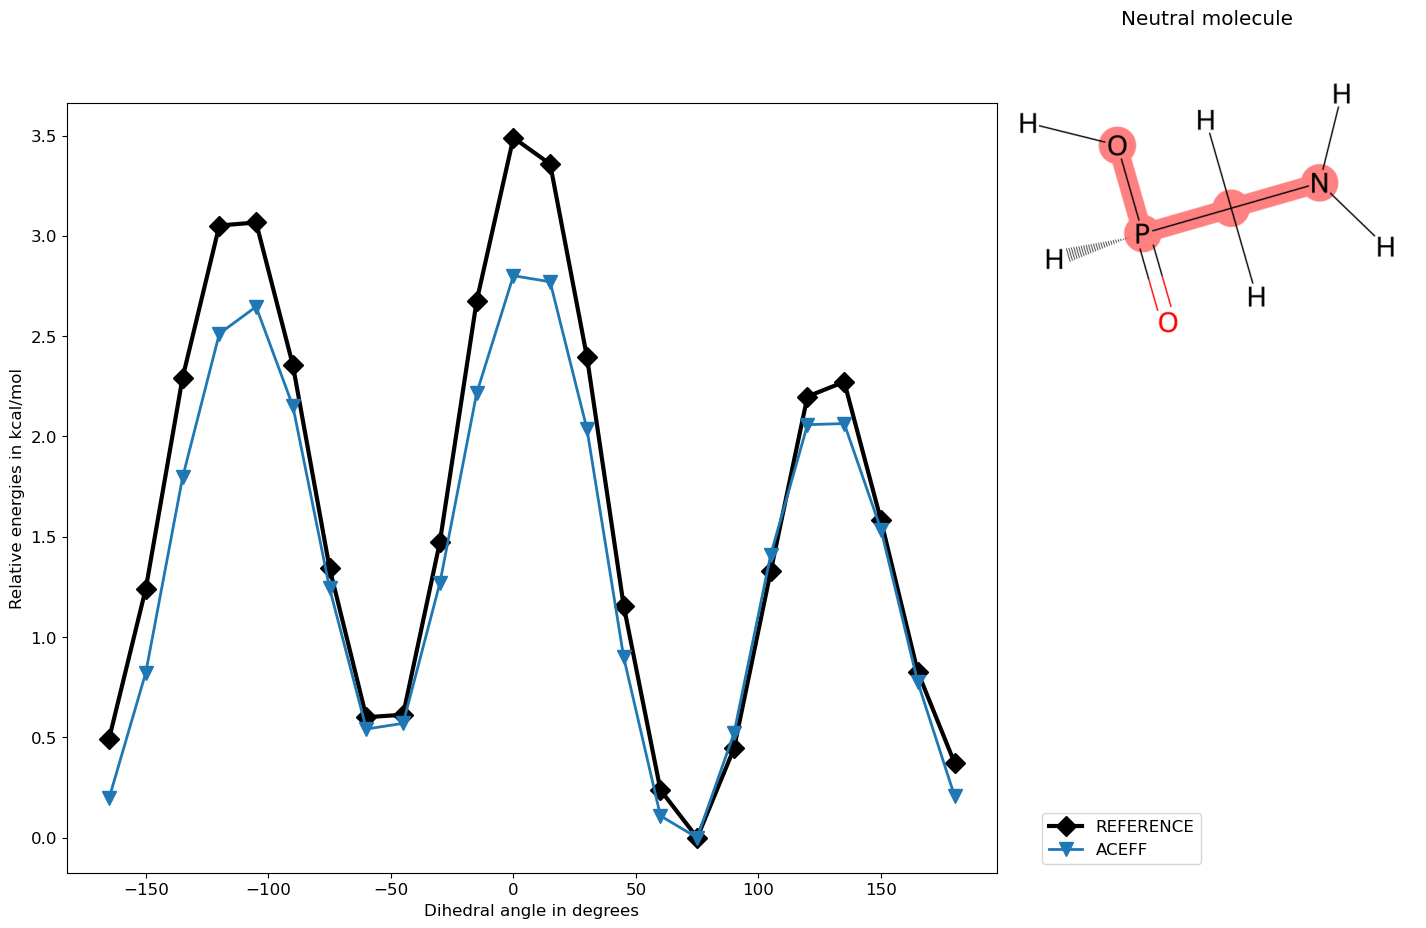

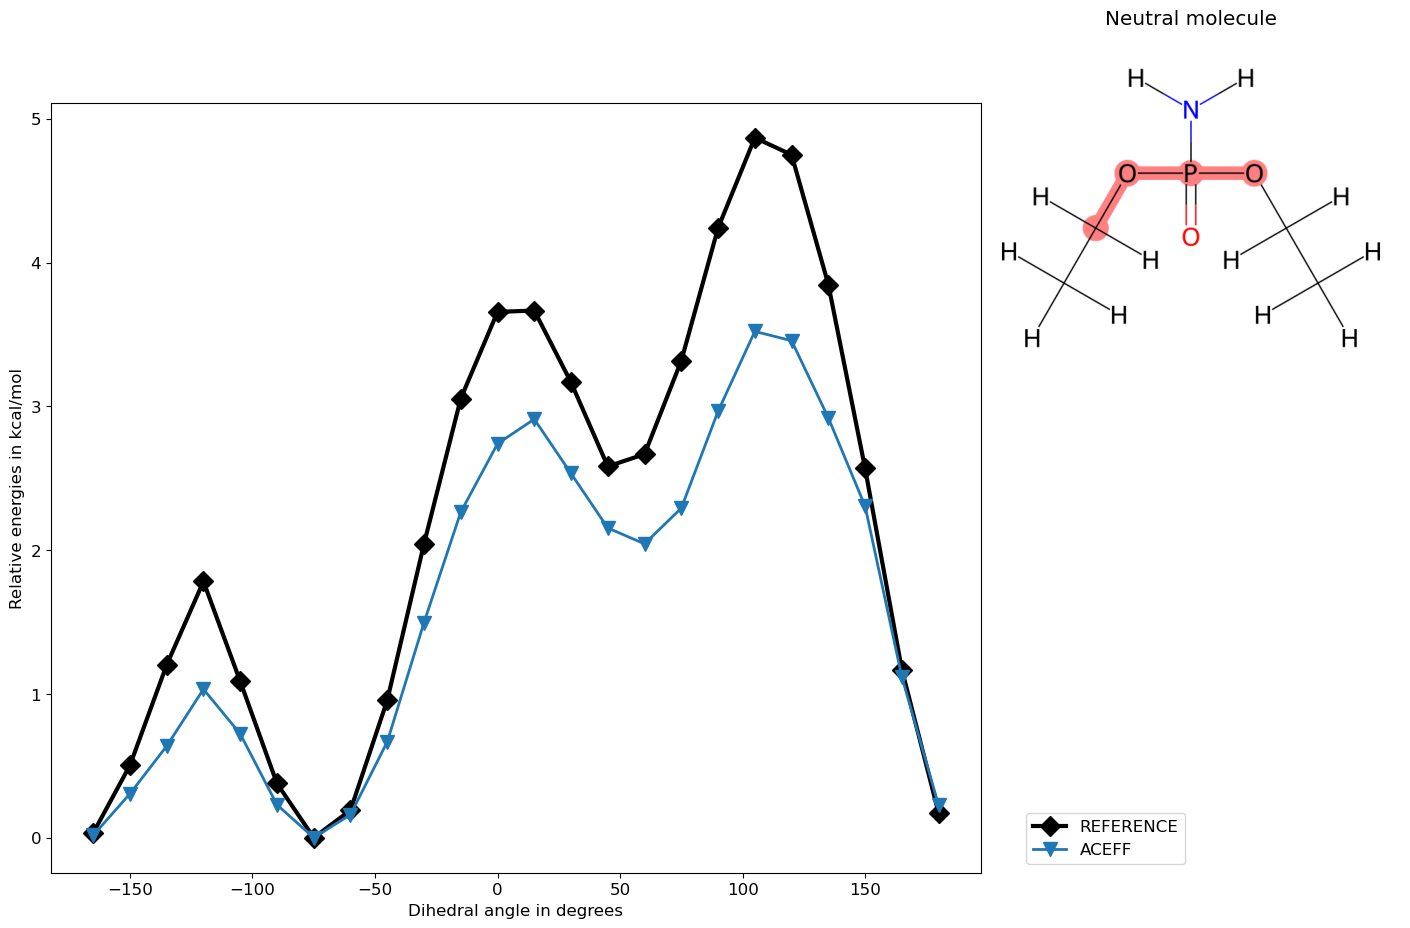

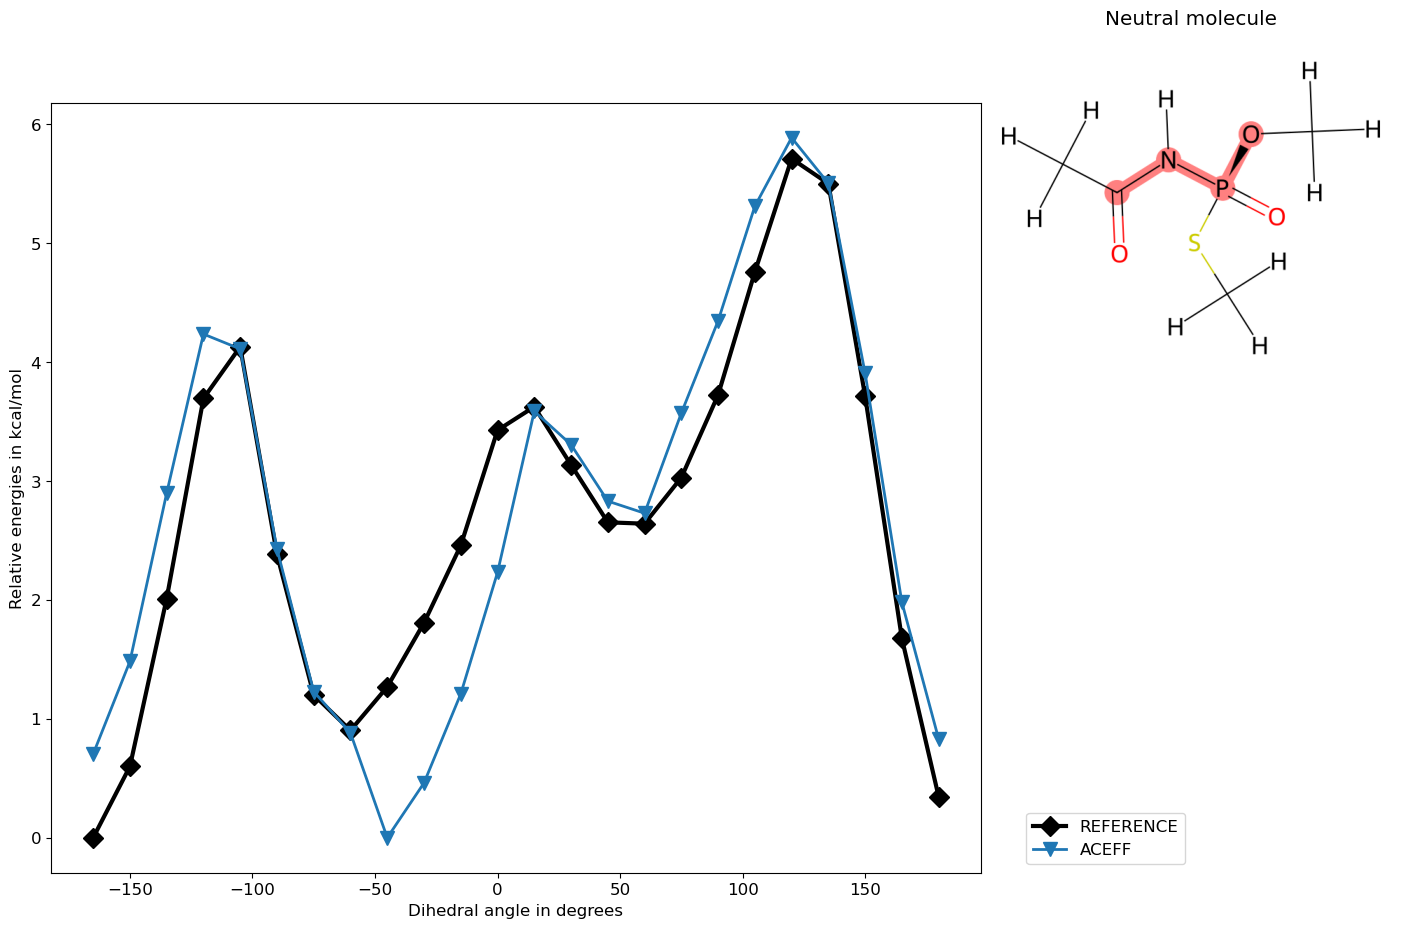

In [9]:
rmse = defaultdict(float)
mae = defaultdict(float)
all_energies = []
neutral_energies = []
charged_energies = []
neutral_ref = []
charged_ref = []
all_ref = []

for i in range(59):
    ref_energies = np.array(get_relative_energies(ref_dict[str(i)]['total energies'], HARTREE_TO_KCALMOL))
    ref_angles = ref_dict[str(i)]['angles']
    mapped_smiles = mp2_data[str(i)]['metadata']['mapped_smiles']
    dihedrals = mp2_data[str(i)]['metadata']['dihedral scanned'][0]
    mol_charge = mp2_data[str(i)]['metadata']['mol_charge']
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    flag_neutral = True
    if mol_charge != 0:
        flag_neutral = False
    elif mol_charge == 0  and mapped_smiles.find('+') != -1:
        flag_neutral = False
    
    all_ref.extend(ref_energies)
    if flag_neutral:
        neutral_ref.extend(ref_energies)
    else:
        charged_ref.extend(ref_energies)
        
    fig, ax = plt.subplots(figsize=[12, 10])
    ax.plot(
            ref_angles,
            ref_energies,
            "-D",
            label="REFERENCE",
            linewidth=3.0,
            c="k",
            markersize=10,
        )
    aceff_energies = []
    numbers = [atom.atomic_number for atom in offmol.atoms]
    for j in range(24):
        coord = np.array(mp2_data[str(i)]['final_geometries'][j]) * 0.529177
        atoms = ase.Atoms(positions=coord, numbers=numbers)
        # initial_charges = get_atom_charges(mapped_smiles, len(atoms))        
        # atoms.set_initial_charges(initial_charges)
        atoms.calc = calc
        atoms.info["charge"] = float(mol_charge)
        aceff_energies.append(calc.get_potential_energy(atoms))

    energies = np.array(get_relative_energies(aceff_energies, eV_to_kcalmol_conversion_factor))
    all_energies.extend(energies)
    if flag_neutral:
        neutral_energies.extend(energies)
    else:
        charged_energies.extend(energies)
    
    rmse_energies = np.sqrt(np.mean((energies - ref_energies) ** 2))
    mae_energies = np.mean(np.abs(energies - ref_energies))
    rmse[i] = rmse_energies
    mae[i] = mae_energies
    ax.plot(
            ref_angles,
            energies,
            "-v",
            label='ACEFF',
            linewidth=2.0,
            markersize=10,
        )
        
    
    plt.xlabel(
        "Dihedral angle in degrees",
    )
    plt.ylabel("Relative energies in kcal/mol")
    
    plt.legend(loc="lower left", bbox_to_anchor=(1.04, 0), fontsize=12)

    # 1. Convert OpenFF molecule to RDKit
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import rdMolDraw2D
    rdmol = offmol.to_rdkit()

    # 2. Prepare the drawer (PNG)
    d2d = rdMolDraw2D.MolDraw2DCairo(600, 500)
    opts = d2d.drawOptions()

    # Highlight atom indices (the dihedrals) if provided
    highlight_atoms = dihedrals

    # 3. Draw the molecule
    d2d.DrawMolecule(rdmol, highlightAtoms=highlight_atoms)
    d2d.FinishDrawing()

    # 4. Convert the PNG data to a numpy array for Matplotlib
    img_data = d2d.GetDrawingText()
    img = Image.open(io.BytesIO(img_data))
    im_arr = np.asarray(img)

    # 5. Add to your existing Matplotlib figure
    newax = fig.add_axes([0.9, 0.6, 0.35, 0.35], anchor="SW", zorder=-1)
    newax.imshow(im_arr)
    newax.axis("off")
    if flag_neutral:
        plt.title('Neutral molecule')
    else:
        plt.title('Charged molecule')
    plt.show()
    pdf.savefig(fig, dpi=600, bbox_inches="tight")

In [11]:
table = []
all_ref = np.array(all_ref)
print(all_ref.shape)
method_energies = np.array(all_energies)
print(method_energies.shape)
rmse_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='RMSE')
mue_stats = bootstrap_statistic(y_true=all_ref, y_pred=method_energies, statistic='MUE')   
neutral_stats = bootstrap_statistic(y_true=neutral_ref, y_pred=np.array(neutral_energies), statistic='RMSE')
charged_stats = bootstrap_statistic(y_true=charged_ref, y_pred=np.array(charged_energies), statistic='RMSE')
lt_five_rmse_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='RMSE')
lt_five_mue_stats = bootstrap_statistic(y_true=all_ref[np.abs(all_ref) < 5], y_pred=method_energies[np.abs(all_ref) < 5], statistic='MUE')
table.append(['aceff',
              "%.4f" % rmse_stats['mle'],"%.4f" % rmse_stats['low'],"%.4f" % rmse_stats['high'],
              "%.4f" % mue_stats['mle'],"%.4f" % mue_stats['low'],"%.4f" % mue_stats['high'],
              "%.4f" % neutral_stats['mle'],"%.4f" % neutral_stats['low'],"%.4f" % neutral_stats['high'],
              "%.4f" % charged_stats['mle'],"%.4f" % charged_stats['low'],"%.4f" % charged_stats['high'],
              "%.4f" % lt_five_rmse_stats['mle'],"%.4f" % lt_five_rmse_stats['low'],"%.4f" % lt_five_rmse_stats['high']])

(1416,)
(1416,)


In [12]:
pdf.close()

print(
    tabulate(
        table,
        headers=["Specification", 
                 "RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "MAE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Neutral RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "Charged RMSE in kcal/mol", "low 95% ci", "high 95% ci", 
                 "lt_five_RMSE in kcal/mol", "low 95% ci", "high 95% ci"],
        tablefmt="orgtbl",
    )
)
print("* closer to zero the better")

| Specification   |   RMSE in kcal/mol |   low 95% ci |   high 95% ci |   MAE in kcal/mol |   low 95% ci |   high 95% ci |   Neutral RMSE in kcal/mol |   low 95% ci |   high 95% ci |   Charged RMSE in kcal/mol |   low 95% ci |   high 95% ci |   lt_five_RMSE in kcal/mol |   low 95% ci |   high 95% ci |
|-----------------+--------------------+--------------+---------------+-------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------+----------------------------+--------------+---------------|
| aceff           |             0.5617 |       0.5313 |        0.5921 |            0.3735 |       0.3536 |        0.3951 |                     0.4794 |       0.4448 |        0.5132 |                     0.6358 |       0.5884 |        0.6837 |                     0.5216 |       0.4868 |        0.5589 |
* closer to zero the better


In [13]:
# For latex table entries
print("RMSE Neutral Charged")
for item in table:
    print(
        f"{item[0].upper()} & ${{{item[1]}}}^{{{item[2]}}}_{{{item[3]}"
        f"}}$ & ${{{item[7]}}}^{{{item[8]}}}_{{{item[9]}}}$ & ${{{item[10]}}}^{{{item[11]}}}_{{{item[12]}}}$\\\\ \\vspace{{2mm}}")

RMSE Neutral Charged
ACEFF & ${0.5617}^{0.5313}_{0.5921}$ & ${0.4794}^{0.4448}_{0.5132}$ & ${0.6358}^{0.5884}_{0.6837}$\\ \vspace{2mm}


In [14]:
energies_dict = defaultdict(list)
for i in range(59):
    energies_dict[i] = all_energies[i*24:(i+1)*24]
with open('../data/aceff_single_points_data.json', 'w') as outfile:
    json.dump(energies_dict, outfile) 